In [ ]:
!pip install -r /content/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.8/264.8 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.6/263.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 79.6 MB/s eta 0:00:00
  Created wheel for infomap: filename=infomap-2.8.0-cp312-cp312-linux_x86_64.whl size=7716615 sha256=e07c1d95028bb084bc1f7e7ac44ff85f7f140bd25547ad054730f7caec6fd441
  Stored in directory: /root/.cache/pip/wheels/0a/d5/d5/dab47e5b039fb1997c5ca2835ee7c9a7c7e1bf2615191aebb1
Successfully built infomap


#Graph Loaders

In [ ]:
"""
Graph loading utilities for standard datasets and file formats.
"""
import networkx as nx
import numpy as np
from pathlib import Path
from typing import Tuple, Optional, Dict, Any
import urllib.request
import gzip
import io


def load_karate_club() -> Tuple[nx.Graph, Dict[int, int]]:
    """Load Zachary's Karate Club with ground truth communities."""
    G = nx.karate_club_graph()
    # Ground truth: Mr. Hi (0) vs Officer (1)
    ground_truth = {n: 0 if G.nodes[n]['club'] == 'Mr. Hi' else 1
                    for n in G.nodes()}
    return G, ground_truth


def load_edge_list(filepath: str,
                   delimiter: str = None,
                   comments: str = '#') -> nx.Graph:
    """Load graph from edge list file."""
    G = nx.read_edgelist(filepath, delimiter=delimiter, comments=comments,
                         nodetype=int)
    return G


def load_with_ground_truth(graph_path: str,
                           community_path: str) -> Tuple[nx.Graph, Dict[int, int]]:
    """
    Load graph and its ground truth communities from separate files.
    Community file format: node_id community_id (per line)
    """
    G = load_edge_list(graph_path)
    ground_truth = {}
    with open(community_path, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue
            parts = line.strip().split()
            if len(parts) >= 2:
                node, comm = int(parts[0]), int(parts[1])
                ground_truth[node] = comm
    return G, ground_truth


def download_snap_dataset(name: str, cache_dir: str = "./data") -> nx.Graph:
    """
    Download common SNAP datasets.
    Supported: 'email-eu-core', 'polblogs', 'facebook-ego'
    """
    urls = {
        'email-eu-core': 'https://snap.stanford.edu/data/email-Eu-core.txt.gz',
        'facebook-ego': 'https://snap.stanford.edu/data/facebook_combined. txt.gz',
    }

    if name not in urls:
        raise ValueError(f"Unknown dataset: {name}. Available: {list(urls.keys())}")

    cache_path = Path(cache_dir)
    cache_path.mkdir(exist_ok=True)
    local_file = cache_path / f"{name}.txt"

    if not local_file.exists():
        print(f"Downloading {name}...")
        response = urllib.request. urlopen(urls[name])
        with gzip.open(io.BytesIO(response.read()), 'rt') as gz:
            local_file.write_text(gz.read())

    return load_edge_list(str(local_file))


def graph_summary(G: nx.Graph) -> Dict[str, Any]:
    """Return basic graph statistics."""
    return {
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'density': nx.density(G),
        'avg_degree': 2 * G.number_of_edges() / G.number_of_nodes(),
        'connected_components': nx.number_connected_components(G),
    }

#Synthetic Graph Generators (SBM & LFR)

In [ ]:
"""
Synthetic benchmark graph generators: SBM, DC-SBM, LFR.
"""
import networkx as nx
import numpy as np
from typing import List, Tuple, Dict, Optional


def generate_sbm(sizes: List[int],
                 p_in: float,
                 p_out: float,
                 seed: int = None) -> Tuple[nx.Graph, Dict[int, int]]:
    """
    Generate Stochastic Block Model graph.

    Args:
        sizes: List of community sizes [n1, n2, ...]
        p_in: Intra-community edge probability
        p_out: Inter-community edge probability
        seed: Random seed for reproducibility

    Returns:
        G: Generated graph
        ground_truth: Dict mapping node -> community_id
    """
    k = len(sizes)
    # Build probability matrix
    probs = np.full((k, k), p_out)
    np.fill_diagonal(probs, p_in)

    G = nx.stochastic_block_model(sizes, probs, seed=seed)

    # Extract ground truth from block attribute
    ground_truth = {n: G.nodes[n]['block'] for n in G.nodes()}

    return G, ground_truth


def generate_dcsbm(sizes: List[int],
                   p_matrix: np.ndarray,
                   degree_seq: List[float] = None,
                   seed: int = None) -> Tuple[nx.Graph, Dict[int, int]]:
    """
    Generate Degree-Corrected SBM.

    Args:
        sizes: Community sizes
        p_matrix: k x k probability matrix
        degree_seq: Expected degree for each node (optional)
        seed: Random seed
    """
    if seed is not None:
        np.random.seed(seed)

    n = sum(sizes)

    # Assign communities
    communities = []
    for i, size in enumerate(sizes):
        communities.extend([i] * size)

    # Generate degree parameters (theta) if not provided
    if degree_seq is None:
        # Power-law-ish degree heterogeneity
        degree_seq = np.random.pareto(2.5, n) + 1
        degree_seq = degree_seq / degree_seq.max()

    # Generate edges
    G = nx.Graph()
    G.add_nodes_from(range(n))

    for i in range(n):
        for j in range(i + 1, n):
            ci, cj = communities[i], communities[j]
            p = p_matrix[ci, cj] * degree_seq[i] * degree_seq[j]
            p = min(p, 1.0)  # Ensure valid probability
            if np.random.random() < p:
                G.add_edge(i, j)

    ground_truth = {i: communities[i] for i in range(n)}
    return G, ground_truth


def generate_lfr(n: int = 1000,
                 tau1: float = 2.5,
                 tau2: float = 1.5,
                 mu: float = 0.1,
                 average_degree: float = 20,
                 min_community: int = 20,
                 seed: int = None) -> Tuple[nx.Graph, Dict[int, int]]:
    """
    Generate LFR benchmark graph using networkx.

    Args:
        n: Number of nodes
        tau1: Power law exponent for degree distribution
        tau2: Power law exponent for community size distribution
        mu: Mixing parameter (fraction of inter-community edges)
        average_degree: Target average degree
        min_community: Minimum community size
        seed: Random seed

    Returns:
        G: Generated graph
        ground_truth: Node to community mapping
    """
    G = nx.LFR_benchmark_graph(
        n=n,
        tau1=tau1,
        tau2=tau2,
        mu=mu,
        average_degree=average_degree,
        min_community=min_community,
        seed=seed
    )

    # Extract ground truth from 'community' attribute (set of communities)
    ground_truth = {}
    communities = {frozenset(G. nodes[n]['community']) for n in G}
    comm_to_id = {c: i for i, c in enumerate(communities)}

    for node in G.nodes():
        comm = frozenset(G. nodes[node]['community'])
        ground_truth[node] = comm_to_id[comm]

    # Remove the community attribute to clean up
    for node in G.nodes():
        del G.nodes[node]['community']

    return G, ground_truth


def sbm_parameter_sweep(n_per_block: int = 100,
                        k: int = 4,
                        p_in: float = 0.3,
                        mu_values: List[float] = None,
                        seed: int = 42) -> List[Tuple[float, nx.Graph, Dict]]:
    """
    Generate SBMs with varying mixing parameter for phase transition study.

    Args:
        n_per_block: Nodes per community
        k: Number of communities
        p_in: Intra-community probability
        mu_values: List of mixing ratios (p_out/p_in)

    Returns:
        List of (mu, Graph, ground_truth) tuples
    """
    if mu_values is None:
        mu_values = np.linspace(0.0, 1.0, 11)

    results = []
    sizes = [n_per_block] * k

    for mu in mu_values:
        p_out = mu * p_in
        G, gt = generate_sbm(sizes, p_in, p_out, seed=seed)
        results.append((mu, G, gt))

    return results

#Community Detection Algorithms

In [ ]:
"""
Community detection algorithm wrappers.
"""
import networkx as nx
import numpy as np
from typing import Dict, List, Optional, Tuple
from collections import defaultdict


def run_louvain(G: nx.Graph,
                resolution: float = 1.0,
                seed: int = None) -> Dict[int, int]:
    """
    Run Louvain algorithm using python-igraph.

    Args:
        G: NetworkX graph
        resolution: Resolution parameter (gamma)
        seed: Random seed
    """
    import igraph as ig

    # Convert to igraph
    mapping = {n: i for i, n in enumerate(G.nodes())}
    reverse_mapping = {i: n for n, i in mapping.items()}

    edges = [(mapping[u], mapping[v]) for u, v in G.edges()]
    ig_graph = ig.Graph(edges=edges, directed=False)

    # Run Louvain
    partition = ig_graph.community_multilevel(resolution=resolution)

    # Convert back to node -> community dict
    communities = {}
    for comm_id, members in enumerate(partition):
        for node_idx in members:
            communities[reverse_mapping[node_idx]] = comm_id

    return communities


def run_leiden(G: nx. Graph,
               resolution: float = 1.0,
               n_iterations: int = -1,
               seed: int = None) -> Dict[int, int]:
    """
    Run Leiden algorithm using leidenalg.

    Args:
        G: NetworkX graph
        resolution: Resolution parameter
        n_iterations: Number of iterations (-1 for until convergence)
        seed: Random seed
    """
    import igraph as ig
    import leidenalg

    # Convert to igraph
    mapping = {n: i for i, n in enumerate(G.nodes())}
    reverse_mapping = {i: n for n, i in mapping.items()}

    edges = [(mapping[u], mapping[v]) for u, v in G.edges()]
    ig_graph = ig.Graph(edges=edges, directed=False)

    # Run Leiden with RBConfiguration for resolution parameter
    partition = leidenalg.find_partition(
        ig_graph,
        leidenalg. RBConfigurationVertexPartition,
        resolution_parameter=resolution,
        n_iterations=n_iterations,
        seed=seed
    )

    communities = {}
    for comm_id, members in enumerate(partition):
        for node_idx in members:
            communities[reverse_mapping[node_idx]] = comm_id

    return communities


def run_infomap(G: nx.Graph,
                seed: int = None,
                num_trials: int = 10) -> Dict[int, int]:
    """
    Run Infomap algorithm.

    Args:
        G: NetworkX graph
        seed: Random seed
        num_trials: Number of optimization attempts
    """
    from infomap import Infomap

    # Create Infomap instance
    im = Infomap(silent=True, seed=seed if seed else 0, num_trials=num_trials)

    # Build network
    mapping = {n: i for i, n in enumerate(G.nodes())}
    reverse_mapping = {i: n for n, i in mapping.items()}

    for u, v in G.edges():
        im.add_link(mapping[u], mapping[v])

    # Run
    im.run()

    # Extract communities
    communities = {}
    for node in im.tree:
        if node.is_leaf:
            communities[reverse_mapping[node.node_id]] = node.module_id

    return communities


def run_label_propagation(G: nx.Graph,
                          seed: int = None) -> Dict[int, int]:
    """
    Run Label Propagation Algorithm (LPA).

    Args:
        G: NetworkX graph
        seed: Random seed
    """
    if seed is not None:
        import random
        random.seed(seed)

    # NetworkX's asynchronous LPA
    communities_generator = nx.community.asyn_lpa_communities(G, seed=seed)

    result = {}
    for comm_id, members in enumerate(communities_generator):
        for node in members:
            result[node] = comm_id

    return result



def run_all_detectors(G: nx. Graph,
                      seed: int = 42,
                      resolution: float = 1.0,
                      include_spectral: bool = True) -> Dict[str, Dict[int, int]]:
    """
    Run all community detection algorithms on a graph.
    Updated to include spectral methods.
    """
    results = {}

    print("  Running Louvain...")
    results['louvain'] = run_louvain(G, resolution=resolution, seed=seed)

    print("  Running Leiden...")
    results['leiden'] = run_leiden(G, resolution=resolution, seed=seed)

    print("  Running Infomap...")
    results['infomap'] = run_infomap(G, seed=seed)

    print("  Running LPA...")
    results['lpa'] = run_label_propagation(G, seed=seed)

    if include_spectral:
        print("  Running Spectral (symmetric)...")
        results['spectral_sym'] = run_spectral(G, normalized='symmetric', seed=seed)

        print("  Running Spectral (unnormalized)...")
        results['spectral_unnorm'] = run_spectral(G, normalized='unnormalized', seed=seed)

    return results

#Evaluation Metrics

In [ ]:
"""
Evaluation metrics for community detection.
"""
import networkx as nx
import numpy as np
from typing import Dict, List, Tuple
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from collections import defaultdict


def partition_to_labels(partition: Dict[int, int],
                        nodes: List[int]) -> np.ndarray:
    """Convert partition dict to label array aligned with node order."""
    return np.array([partition.get(n, -1) for n in nodes])


def compute_nmi(partition: Dict[int, int],
                ground_truth: Dict[int, int]) -> float:
    """
    Compute Normalized Mutual Information between partition and ground truth.
    """
    nodes = sorted(set(partition.keys()) & set(ground_truth.keys()))
    pred = partition_to_labels(partition, nodes)
    true = partition_to_labels(ground_truth, nodes)
    return normalized_mutual_info_score(true, pred)


def compute_ari(partition: Dict[int, int],
                ground_truth: Dict[int, int]) -> float:
    """
    Compute Adjusted Rand Index between partition and ground truth.
    """
    nodes = sorted(set(partition.keys()) & set(ground_truth.keys()))
    pred = partition_to_labels(partition, nodes)
    true = partition_to_labels(ground_truth, nodes)
    return adjusted_rand_score(true, pred)


def compute_modularity(G: nx.Graph,
                       partition: Dict[int, int],
                       resolution: float = 1.0) -> float:
    """
    Compute modularity Q of a partition.
    """
    # Convert to list of sets format
    comm_to_nodes = defaultdict(set)
    for node, comm in partition.items():
        comm_to_nodes[comm].add(node)
    communities = list(comm_to_nodes.values())

    return nx.community.modularity(G, communities, resolution=resolution)


def compute_conductance(G: nx.Graph,
                        partition: Dict[int, int]) -> Dict[int, float]:
    """
    Compute conductance for each community.

    Conductance(S) = cut(S, V-S) / min(vol(S), vol(V-S))
    """
    comm_to_nodes = defaultdict(set)
    for node, comm in partition.items():
        comm_to_nodes[comm].add(node)

    total_degree = sum(dict(G.degree()).values())
    conductances = {}

    for comm_id, members in comm_to_nodes. items():
        members_set = set(members)
        cut = 0
        vol_s = 0

        for node in members:
            vol_s += G. degree(node)
            for neighbor in G.neighbors(node):
                if neighbor not in members_set:
                    cut += 1

        vol_complement = total_degree - vol_s

        if min(vol_s, vol_complement) > 0:
            conductances[comm_id] = cut / min(vol_s, vol_complement)
        else:
            conductances[comm_id] = 0.0

    return conductances


def compute_coverage(G: nx.Graph,
                     partition: Dict[int, int]) -> float:
    """
    Compute coverage: fraction of intra-community edges.
    """
    intra_edges = 0
    for u, v in G. edges():
        if partition.get(u) == partition.get(v):
            intra_edges += 1

    return intra_edges / G.number_of_edges() if G.number_of_edges() > 0 else 0


def evaluate_partition(G: nx. Graph,
                       partition: Dict[int, int],
                       ground_truth: Dict[int, int] = None,
                       resolution: float = 1.0) -> Dict[str, float]:
    """
    Comprehensive evaluation of a partition.
    """
    results = {
        'num_communities': len(set(partition.values())),
        'modularity': compute_modularity(G, partition, resolution),
        'coverage': compute_coverage(G, partition),
    }

    conductances = compute_conductance(G, partition)
    results['avg_conductance'] = np.mean(list(conductances.values()))

    if ground_truth is not None:
        results['nmi'] = compute_nmi(partition, ground_truth)
        results['ari'] = compute_ari(partition, ground_truth)

    return results


def compare_partitions(G: nx.Graph,
                       partitions: Dict[str, Dict[int, int]],
                       ground_truth: Dict[int, int] = None) -> 'pd.DataFrame':
    """
    Compare multiple partitions and return results as DataFrame.
    """
    import pandas as pd

    rows = []
    for name, partition in partitions.items():
        metrics = evaluate_partition(G, partition, ground_truth)
        metrics['algorithm'] = name
        rows.append(metrics)

    df = pd.DataFrame(rows)
    df = df.set_index('algorithm')
    return df

#Main Experiment Script

In [ ]:
# # Cell 1: Mount Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Cell 2: Create project structure
# ! mkdir -p /content/drive/MyDrive/community_detection/src

# Cell 3: Add to Python path
import sys
sys.path.append('/content/drive/MyDrive/community_detection')

# Now you can do:
# from src.loaders import load_karate_club

M1 Baseline Experiments

Experiment 1: Karate Club Baseline
Graph stats: {'nodes': 34, 'edges': 78, 'density': 0.13903743315508021, 'avg_degree': 4.588235294117647, 'connected_components': 1}
Ground truth communities: 2
  Running Louvain...
  Running Leiden...
  Running Infomap...
  Running LPA...

Results:
           num_communities  modularity  coverage  avg_conductance       nmi       ari
algorithm                                                                            
louvain                  4    0.440181  0.730769         0.287933  0.489967  0.392239
leiden                   4    0.444904  0.730769         0.287500  0.587850  0.464591
infomap                  3    0.432104  0.820513         0.201337  0.568380  0.590553
lpa                      4    0.436602  0.756410         0.297024  0.505627  0.458780

Experiment 2: Easy SBM (4 communities, low mixing)
Graph stats: {'nodes': 400, 'edges': 6544, 'density': 0.08200501253132832, 'avg_degree': 32.72, 'connected_components': 1}


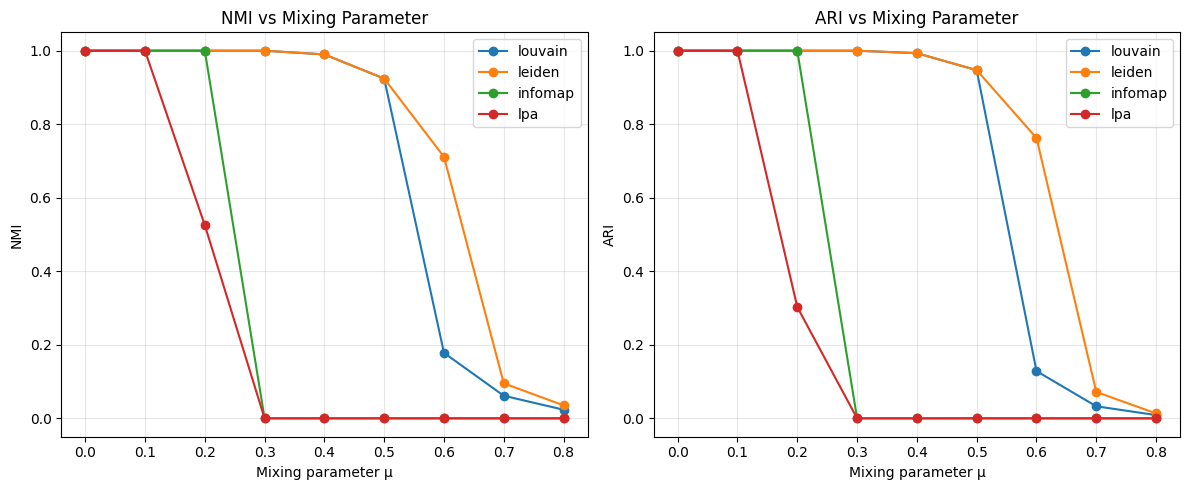

In [ ]:
"""
M1 Baseline Experiments: Foundation verification.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from src.loaders import load_karate_club, graph_summary
from src.generators import generate_sbm, generate_lfr, sbm_parameter_sweep
from src.detectors import run_all_detectors
from src.metrics import compare_partitions, compute_nmi, compute_ari

# Create output directory
Path("results").mkdir(exist_ok=True)


def experiment_1_karate():
    """Verify algorithms on Karate Club (known ground truth)."""
    print("\n" + "="*60)
    print("Experiment 1: Karate Club Baseline")
    print("="*60)

    G, ground_truth = load_karate_club()
    print(f"Graph stats: {graph_summary(G)}")
    print(f"Ground truth communities: {len(set(ground_truth.values()))}")

    partitions = run_all_detectors(G, seed=42)

    results = compare_partitions(G, partitions, ground_truth)
    print("\nResults:")
    print(results.to_string())
    results.to_csv("results/karate_baseline.csv")

    return results


def experiment_2_sbm_easy():
    """Verify on easy SBM (well-separated communities)."""
    print("\n" + "="*60)
    print("Experiment 2: Easy SBM (4 communities, low mixing)")
    print("="*60)

    G, ground_truth = generate_sbm(
        sizes=[100, 100, 100, 100],
        p_in=0.3,
        p_out=0.01,
        seed=42
    )
    print(f"Graph stats: {graph_summary(G)}")

    partitions = run_all_detectors(G, seed=42)

    results = compare_partitions(G, partitions, ground_truth)
    print("\nResults:")
    print(results. to_string())
    results.to_csv("results/sbm_easy_baseline.csv")

    return results


def experiment_3_sbm_phase_transition():
    """Study detection accuracy vs mixing parameter."""
    print("\n" + "="*60)
    print("Experiment 3: SBM Phase Transition Study")
    print("="*60)

    mu_values = np.linspace(0.0, 0.8, 9)
    sweep_results = sbm_parameter_sweep(
        n_per_block=100, k=4, p_in=0.3,
        mu_values=mu_values, seed=42
    )

    records = []
    for mu, G, ground_truth in sweep_results:
        print(f"\n  μ = {mu:.2f}")
        partitions = run_all_detectors(G, seed=42)

        for algo, partition in partitions.items():
            nmi = compute_nmi(partition, ground_truth)
            ari = compute_ari(partition, ground_truth)
            records.append({
                'mu': mu,
                'algorithm': algo,
                'nmi': nmi,
                'ari': ari
            })

    df = pd.DataFrame(records)
    df.to_csv("results/sbm_phase_transition.csv", index=False)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    for algo in df['algorithm'].unique():
        subset = df[df['algorithm'] == algo]
        axes[0].plot(subset['mu'], subset['nmi'], 'o-', label=algo)
        axes[1].plot(subset['mu'], subset['ari'], 'o-', label=algo)

    axes[0].set_xlabel('Mixing parameter μ')
    axes[0].set_ylabel('NMI')
    axes[0].set_title('NMI vs Mixing Parameter')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].set_xlabel('Mixing parameter μ')
    axes[1].set_ylabel('ARI')
    axes[1].set_title('ARI vs Mixing Parameter')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("results/sbm_phase_transition.png", dpi=150)
    print("\nSaved phase transition plot to results/sbm_phase_transition.png")

    return df


def experiment_4_lfr():
    """Test on LFR benchmark."""
    print("\n" + "="*60)
    print("Experiment 4: LFR Benchmark")
    print("="*60)

    G, ground_truth = generate_lfr(
        n=1000,
        tau1=2.5,
        tau2=1.5,
        mu=0.1,
        average_degree=20,
        min_community=20,
        seed=42
    )
    print(f"Graph stats: {graph_summary(G)}")
    print(f"Ground truth communities: {len(set(ground_truth.values()))}")

    partitions = run_all_detectors(G, seed=42)

    results = compare_partitions(G, partitions, ground_truth)
    print("\nResults:")
    print(results.to_string())
    results.to_csv("results/lfr_baseline.csv")

    return results


if __name__ == "__main__":
    print("M1 Baseline Experiments")
    print("="*60)

    # Run all experiments
    karate_results = experiment_1_karate()
    sbm_easy_results = experiment_2_sbm_easy()
    phase_transition_df = experiment_3_sbm_phase_transition()
    lfr_results = experiment_4_lfr()

    print("\n" + "="*60)
    print("M1 COMPLETE - All baselines verified!")
    print("="*60)
    print("\nGenerated files:")
    print("  - results/karate_baseline.csv")
    print("  - results/sbm_easy_baseline.csv")
    print("  - results/sbm_phase_transition.csv")
    print("  - results/sbm_phase_transition.png")
    print("  - results/lfr_baseline.csv")

#Spectral Clustering Implementation

In [ ]:
"""
Spectral clustering using graph Laplacian embeddings.
"""
import numpy as np
import networkx as nx
from scipy import sparse
from scipy.sparse.linalg import eigsh
from scipy.linalg import eigh
from sklearn. cluster import KMeans
from sklearn.preprocessing import normalize
from typing import Dict, List, Tuple, Optional, Literal


def compute_laplacian(G: nx.Graph,
                      normalized: Literal['unnormalized', 'symmetric', 'random_walk'] = 'symmetric'
                      ) -> sparse.csr_matrix:
    """
    Compute graph Laplacian matrix.

    Args:
        G: NetworkX graph
        normalized: Type of Laplacian
            - 'unnormalized': L = D - A
            - 'symmetric': L_sym = D^{-1/2} L D^{-1/2} = I - D^{-1/2} A D^{-1/2}
            - 'random_walk': L_rw = D^{-1} L = I - D^{-1} A

    Returns:
        Sparse Laplacian matrix
    """
    n = G.number_of_nodes()
    nodes = list(G. nodes())
    node_to_idx = {node: i for i, node in enumerate(nodes)}

    # Build adjacency matrix
    rows, cols, data = [], [], []
    for u, v in G.edges():
        i, j = node_to_idx[u], node_to_idx[v]
        rows.extend([i, j])
        cols.extend([j, i])
        data.extend([1.0, 1.0])

    A = sparse.csr_matrix((data, (rows, cols)), shape=(n, n))

    # Degree matrix
    degrees = np.array(A.sum(axis=1)). flatten()
    D = sparse.diags(degrees)

    if normalized == 'unnormalized':
        L = D - A
    elif normalized == 'symmetric':
        # L_sym = I - D^{-1/2} A D^{-1/2}
        with np.errstate(divide='ignore'):
            d_inv_sqrt = np.where(degrees > 0, 1.0 / np.sqrt(degrees), 0)
        D_inv_sqrt = sparse.diags(d_inv_sqrt)
        L = sparse.eye(n) - D_inv_sqrt @ A @ D_inv_sqrt
    elif normalized == 'random_walk':
        # L_rw = I - D^{-1} A
        with np.errstate(divide='ignore'):
            d_inv = np.where(degrees > 0, 1.0 / degrees, 0)
        D_inv = sparse.diags(d_inv)
        L = sparse.eye(n) - D_inv @ A
    else:
        raise ValueError(f"Unknown normalization: {normalized}")

    return L.tocsr(), nodes


def compute_eigenvectors(L: sparse.csr_matrix,
                         k: int,
                         which: str = 'SM') -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute k smallest eigenvectors of Laplacian.

    Args:
        L: Laplacian matrix
        k: Number of eigenvectors
        which: 'SM' for smallest magnitude (default for Laplacian)

    Returns:
        eigenvalues, eigenvectors
    """
    n = L.shape[0]

    # For small graphs, use dense solver
    if n < 500:
        L_dense = L.toarray()
        eigenvalues, eigenvectors = eigh(L_dense)
        idx = np.argsort(eigenvalues)[:k]
        return eigenvalues[idx], eigenvectors[:, idx]

    # For larger graphs, use sparse solver (Lanczos)
    # Request k+1 to ensure we get k valid ones
    try:
        eigenvalues, eigenvectors = eigsh(L, k=min(k+1, n-1), which=which, tol=1e-6)
        idx = np.argsort(eigenvalues)[:k]
        return eigenvalues[idx], eigenvectors[:, idx]
    except Exception as e:
        # Fallback to dense if sparse fails
        L_dense = L.toarray()
        eigenvalues, eigenvectors = eigh(L_dense)
        idx = np.argsort(eigenvalues)[:k]
        return eigenvalues[idx], eigenvectors[:, idx]


def eigengap_heuristic(eigenvalues: np.ndarray,
                       max_k: int = None) -> Tuple[int, np.ndarray]:
    """
    Determine optimal k using eigengap heuristic.

    The optimal k is where the gap between consecutive eigenvalues is largest.

    Args:
        eigenvalues: Sorted eigenvalues (smallest first)
        max_k: Maximum k to consider

    Returns:
        optimal_k, gaps array
    """
    if max_k is None:
        max_k = min(len(eigenvalues) - 1, 20)

    # Compute gaps between consecutive eigenvalues
    gaps = np.diff(eigenvalues[:max_k + 1])

    # Find largest gap (skip first gap if it's from ~0 eigenvalue)
    # Start from index 1 to skip the trivial eigenvalue
    if len(gaps) > 1:
        optimal_k = np.argmax(gaps[1:]) + 2  # +2 because we skip index 0 and argmax is 0-indexed
    else:
        optimal_k = 2

    return optimal_k, gaps


def spectral_clustering(G: nx.Graph,
                        k: int = None,
                        normalized: Literal['unnormalized', 'symmetric', 'random_walk'] = 'symmetric',
                        use_eigengap: bool = True,
                        max_k: int = 20,
                        seed: int = None) -> Tuple[Dict[int, int], dict]:
    """
    Perform spectral clustering on graph.

    Args:
        G: NetworkX graph
        k: Number of clusters (if None, use eigengap heuristic)
        normalized: Laplacian normalization type
        use_eigengap: Whether to use eigengap if k is None
        max_k: Maximum k for eigengap search
        seed: Random seed for KMeans

    Returns:
        partition: Dict mapping node -> community_id
        info: Dict with eigenvalues, eigengap info, etc.
    """
    # Compute Laplacian
    L, nodes = compute_laplacian(G, normalized=normalized)

    # Compute eigenvalues/vectors for eigengap analysis
    n_eigs = min(max_k + 2, G.number_of_nodes() - 1)
    eigenvalues, _ = compute_eigenvectors(L, k=n_eigs)

    # Determine k
    if k is None and use_eigengap:
        k, gaps = eigengap_heuristic(eigenvalues, max_k=max_k)
    elif k is None:
        k = 2  # Default
        gaps = np.diff(eigenvalues[:max_k + 1])
    else:
        gaps = np.diff(eigenvalues[:max_k + 1])

    # Get k eigenvectors for clustering
    _, eigenvectors = compute_eigenvectors(L, k=k)

    # Normalize rows for symmetric Laplacian (Ng, Jordan, Weiss method)
    if normalized == 'symmetric':
        embedding = normalize(eigenvectors, norm='l2', axis=1)
    else:
        embedding = eigenvectors

    # Cluster in embedding space
    kmeans = KMeans(n_clusters=k, random_state=seed, n_init=10)
    labels = kmeans.fit_predict(embedding)

    # Build partition dict
    partition = {nodes[i]: int(labels[i]) for i in range(len(nodes))}

    info = {
        'k': k,
        'eigenvalues': eigenvalues,
        'gaps': gaps,
        'normalized': normalized,
        'embedding_shape': embedding.shape
    }

    return partition, info


def run_spectral(G: nx.Graph,
                 k: int = None,
                 normalized: str = 'symmetric',
                 seed: int = None) -> Dict[int, int]:
    """
    Wrapper for spectral clustering matching detector interface.
    """
    partition, _ = spectral_clustering(G, k=k, normalized=normalized, seed=seed)
    return partition

#Eigengap Visualization & Analysis

In [ ]:
"""
Eigengap analysis and visualization tools.
"""
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
import networkx as nx



def analyze_spectrum(G: nx.Graph,
                     max_k: int = 30,
                     normalized: str = 'symmetric') -> dict:
    """
    Comprehensive spectral analysis of a graph.

    Returns dict with eigenvalues, gaps, suggested k, and Cheeger-related bounds.
    """
    L, nodes = compute_laplacian(G, normalized=normalized)
    n_eigs = min(max_k + 2, G.number_of_nodes() - 1)
    eigenvalues, eigenvectors = compute_eigenvectors(L, k=n_eigs)

    optimal_k, gaps = eigengap_heuristic(eigenvalues, max_k=max_k)

    # Algebraic connectivity (second smallest eigenvalue)
    algebraic_connectivity = eigenvalues[1] if len(eigenvalues) > 1 else 0

    # Cheeger bounds (for normalized Laplacian)
    # h(G) >= λ_2 / 2  (lower bound on conductance)
    cheeger_lower = algebraic_connectivity / 2

    return {
        'eigenvalues': eigenvalues,
        'eigenvectors': eigenvectors,
        'gaps': gaps,
        'optimal_k': optimal_k,
        'algebraic_connectivity': algebraic_connectivity,
        'cheeger_lower_bound': cheeger_lower,
        'normalized': normalized
    }


def plot_spectrum(eigenvalues: np. ndarray,
                  gaps: np.ndarray = None,
                  optimal_k: int = None,
                  title: str = "Spectral Analysis",
                  save_path: str = None):
    """
    Plot eigenvalue spectrum and eigengaps.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Eigenvalues
    ax1 = axes[0]
    n_plot = min(len(eigenvalues), 25)
    ax1.bar(range(1, n_plot + 1), eigenvalues[:n_plot], color='steelblue', alpha=0.7)
    ax1.set_xlabel('Eigenvalue Index', fontsize=12)
    ax1.set_ylabel('Eigenvalue', fontsize=12)
    ax1.set_title('Laplacian Eigenvalues', fontsize=14)
    ax1.grid(True, alpha=0.3)

    if optimal_k is not None:
        ax1.axvline(x=optimal_k, color='red', linestyle='--', linewidth=2,
                    label=f'Suggested k={optimal_k}')
        ax1.legend()

    # Plot 2: Eigengaps
    ax2 = axes[1]
    if gaps is not None:
        n_gaps = min(len(gaps), 24)
        colors = ['red' if i == optimal_k - 1 else 'steelblue'
                  for i in range(n_gaps)]
        ax2.bar(range(1, n_gaps + 1), gaps[:n_gaps], color=colors, alpha=0.7)
        ax2.set_xlabel('Gap Index (between λ_i and λ_{i+1})', fontsize=12)
        ax2.set_ylabel('Gap Size', fontsize=12)
        ax2.set_title('Eigengaps', fontsize=14)
        ax2.grid(True, alpha=0.3)

        if optimal_k is not None:
            ax2.axvline(x=optimal_k, color='red', linestyle='--', linewidth=2,
                        label=f'Largest gap at k={optimal_k}')
            ax2.legend()

    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()
    return fig


def plot_embedding_2d(G: nx.Graph,
                      partition: dict = None,
                      normalized: str = 'symmetric',
                      title: str = "Spectral Embedding",
                      save_path: str = None):
    """
    Visualize graph in 2D spectral embedding space.
    Uses eigenvectors 2 and 3 (skipping trivial first eigenvector).
    """
    L, nodes = compute_laplacian(G, normalized=normalized)
    eigenvalues, eigenvectors = compute_eigenvectors(L, k=4)

    # Use 2nd and 3rd eigenvectors for 2D plot
    x = eigenvectors[:, 1]
    y = eigenvectors[:, 2]

    fig, ax = plt.subplots(figsize=(10, 8))

    if partition is not None:
        # Color by community
        node_to_idx = {node: i for i, node in enumerate(nodes)}
        colors = [partition. get(node, 0) for node in nodes]
        scatter = ax.scatter(x, y, c=colors, cmap='tab10', s=50, alpha=0.7)
        plt.colorbar(scatter, label='Community')
    else:
        ax.scatter(x, y, s=50, alpha=0.7)

    ax.set_xlabel('Eigenvector 2', fontsize=12)
    ax.set_ylabel('Eigenvector 3', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()
    return fig


def compare_laplacians(G: nx.Graph,
                       ground_truth: dict = None,
                       max_k: int = 20,
                       seed: int = 42) -> dict:
    """
    Compare unnormalized vs normalized Laplacian performance.
    """

    results = {}

    for norm_type in ['unnormalized', 'symmetric', 'random_walk']:
        partition, info = spectral_clustering(
            G, k=None, normalized=norm_type, seed=seed
        )

        result = {
            'k_detected': info['k'],
            'eigenvalues': info['eigenvalues'][:10],  # First 10
            'modularity': compute_modularity(G, partition)
        }

        if ground_truth is not None:
            result['nmi'] = compute_nmi(partition, ground_truth)
            result['ari'] = compute_ari(partition, ground_truth)

        results[norm_type] = result

    return results

#Optional: Min-Cut Baselines

In [ ]:
"""
Min-cut based methods for comparison (optional baseline).
"""
import numpy as np
import networkx as nx
from typing import Dict, Tuple, Optional


def stoer_wagner_mincut(G: nx.Graph) -> Tuple[int, Tuple[set, set]]:
    """
    Compute global minimum cut using Stoer-Wagner algorithm.
    Returns cut value and the two partitions.
    """
    if not nx.is_connected(G):
        # For disconnected graphs, return a component as the cut
        components = list(nx. connected_components(G))
        return 0, (components[0], set().union(*components[1:]))

    cut_value, partition = nx.stoer_wagner(G)
    return cut_value, partition


def normalized_cut(G: nx.Graph, partition: Dict[int, int]) -> float:
    """
    Compute normalized cut (Ncut) for a given partition.

    Ncut(A,B) = cut(A,B)/assoc(A,V) + cut(A,B)/assoc(B,V)

    where assoc(A,V) = sum of degrees of nodes in A
    """
    from collections import defaultdict

    comm_to_nodes = defaultdict(set)
    for node, comm in partition. items():
        comm_to_nodes[comm].add(node)

    communities = list(comm_to_nodes.values())

    if len(communities) < 2:
        return 0.0

    total_ncut = 0.0

    for i, comm in enumerate(communities):
        # Cut: edges leaving this community
        cut = sum(1 for u in comm for v in G.neighbors(u) if v not in comm)

        # Association: total degree of nodes in community
        assoc = sum(G.degree(u) for u in comm)

        if assoc > 0:
            total_ncut += cut / assoc

    return total_ncut


def ratio_cut(G: nx.Graph, partition: Dict[int, int]) -> float:
    """
    Compute ratio cut for a given partition.

    RatioCut = sum over communities of cut(C, V-C) / |C|
    """
    from collections import defaultdict

    comm_to_nodes = defaultdict(set)
    for node, comm in partition.items():
        comm_to_nodes[comm].add(node)

    total_ratio = 0.0

    for comm_nodes in comm_to_nodes.values():
        cut = sum(1 for u in comm_nodes for v in G.neighbors(u) if v not in comm_nodes)
        if len(comm_nodes) > 0:
            total_ratio += cut / len(comm_nodes)

    return total_ratio


def recursive_spectral_bisection(G: nx.Graph,
                                 min_size: int = 10,
                                 max_depth: int = 5,
                                 seed: int = None) -> Dict[int, int]:
    """
    Recursively bisect graph using spectral method (Fiedler vector).

    Args:
        G: NetworkX graph
        min_size: Minimum community size to stop recursion
        max_depth: Maximum recursion depth
        seed: Random seed

    Returns:
        Partition dictionary
    """
    from src.spectral import compute_laplacian, compute_eigenvectors

    partition = {}
    next_comm_id = [0]  # Mutable counter

    def bisect(subgraph: nx.Graph, nodes: list, depth: int):
        # Base cases
        if len(nodes) <= min_size or depth >= max_depth:
            comm_id = next_comm_id[0]
            next_comm_id[0] += 1
            for node in nodes:
                partition[node] = comm_id
            return

        # Compute Fiedler vector (2nd eigenvector)
        L, node_list = compute_laplacian(subgraph, normalized='symmetric')

        if L.shape[0] < 3:
            comm_id = next_comm_id[0]
            next_comm_id[0] += 1
            for node in nodes:
                partition[node] = comm_id
            return

        try:
            eigenvalues, eigenvectors = compute_eigenvectors(L, k=2)
            fiedler = eigenvectors[:, 1]
        except:
            comm_id = next_comm_id[0]
            next_comm_id[0] += 1
            for node in nodes:
                partition[node] = comm_id
            return

        # Bisect based on sign of Fiedler vector
        left_nodes = [node_list[i] for i in range(len(node_list)) if fiedler[i] < 0]
        right_nodes = [node_list[i] for i in range(len(node_list)) if fiedler[i] >= 0]

        # Handle edge case where all nodes go to one side
        if len(left_nodes) == 0 or len(right_nodes) == 0:
            comm_id = next_comm_id[0]
            next_comm_id[0] += 1
            for node in nodes:
                partition[node] = comm_id
            return

        # Recurse
        bisect(subgraph.subgraph(left_nodes). copy(), left_nodes, depth + 1)
        bisect(subgraph.subgraph(right_nodes).copy(), right_nodes, depth + 1)

    bisect(G, list(G.nodes()), 0)
    return partition

#M2 Experiment Script

M2 Experiments: Spectral Clustering

Experiment 1: Eigengap Heuristic on SBM

  Testing k = 2 communities...
    True k=2, Detected k=2, NMI=1.000

  Testing k = 3 communities...
    True k=3, Detected k=3, NMI=1.000

  Testing k = 4 communities...
    True k=4, Detected k=4, NMI=1.000

  Testing k = 5 communities...
    True k=5, Detected k=5, NMI=1.000

  Testing k = 6 communities...
    True k=6, Detected k=6, NMI=1.000

 true_k  detected_k  correct  nmi  algebraic_connectivity
      2           2     True  1.0                0.113554
      3           3     True  1.0                0.165870
      4           4     True  1.0                0.204192
      5           5     True  1.0                0.244901
      6           6     True  1.0                0.268706

Experiment 2: Laplacian Normalization Comparison
Graph: {'nodes': 400, 'edges': 6777, 'density': 0.0849248120300752, 'avg_degree': 33.885, 'connected_components': 1}

Results by Laplacian type:

  unnormalized:
    k detect

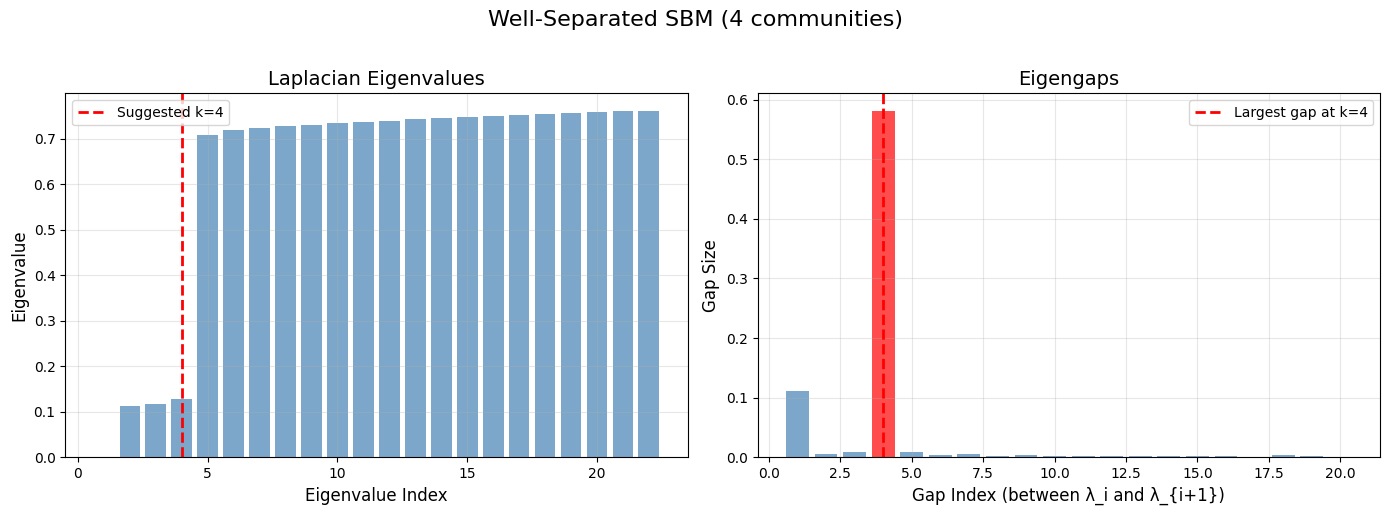

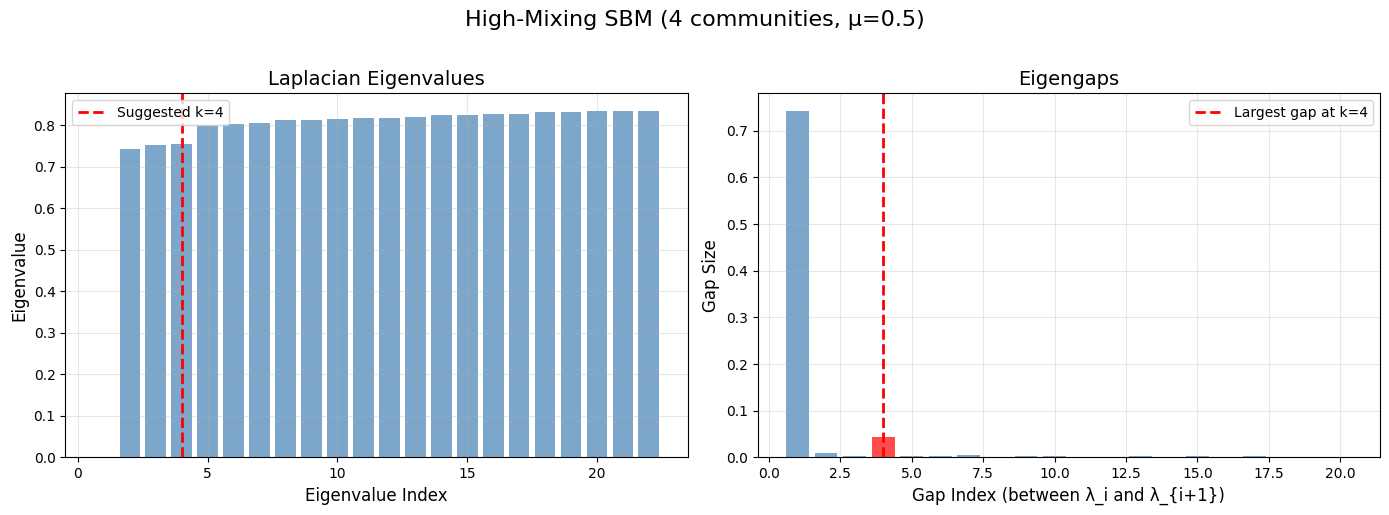

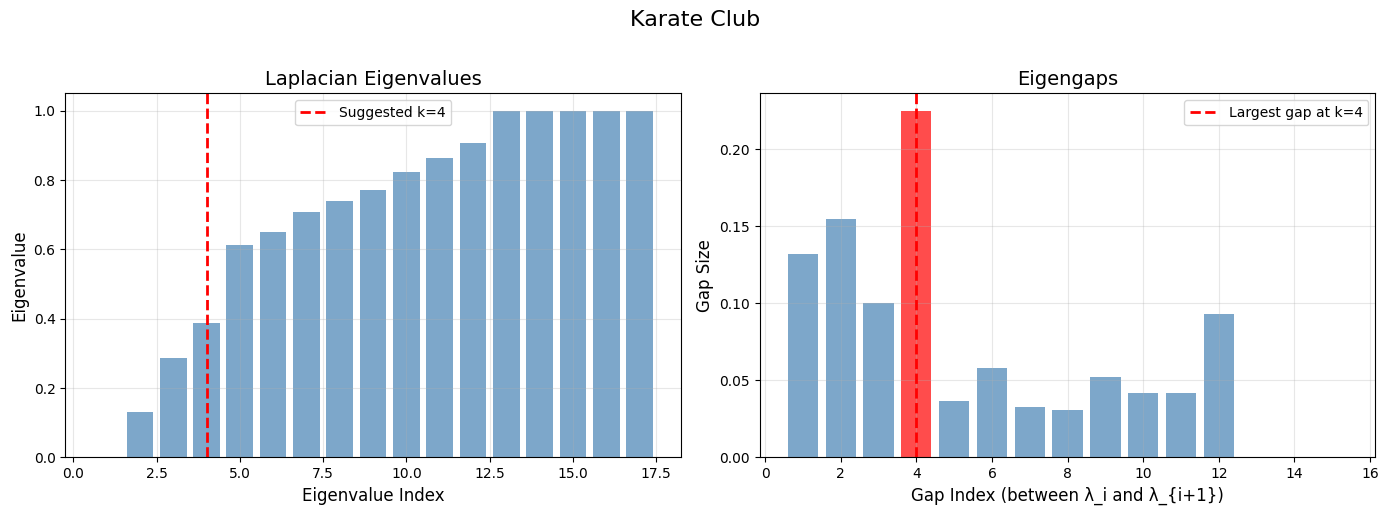


Experiment 4: Spectral Embedding Visualization


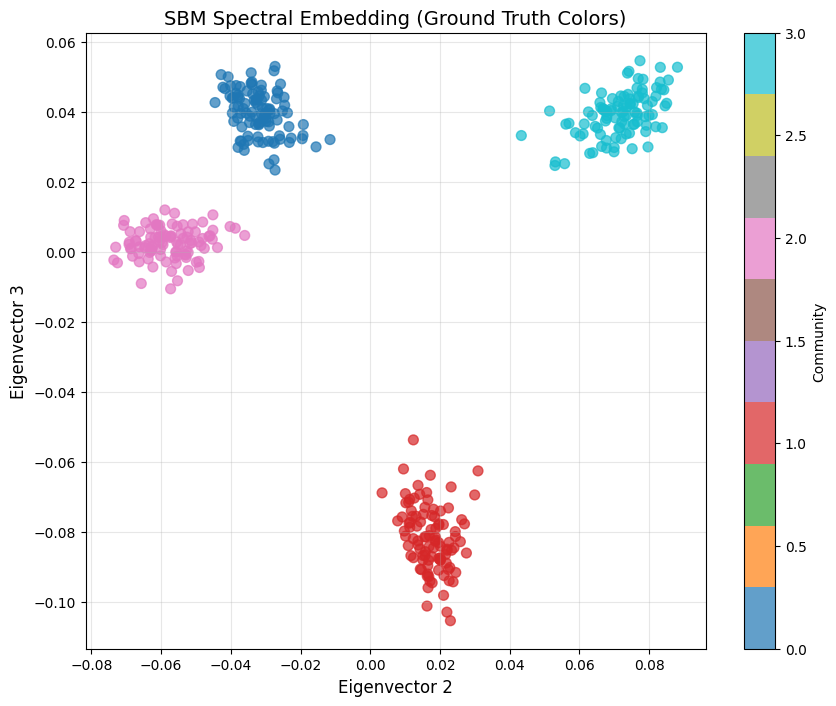

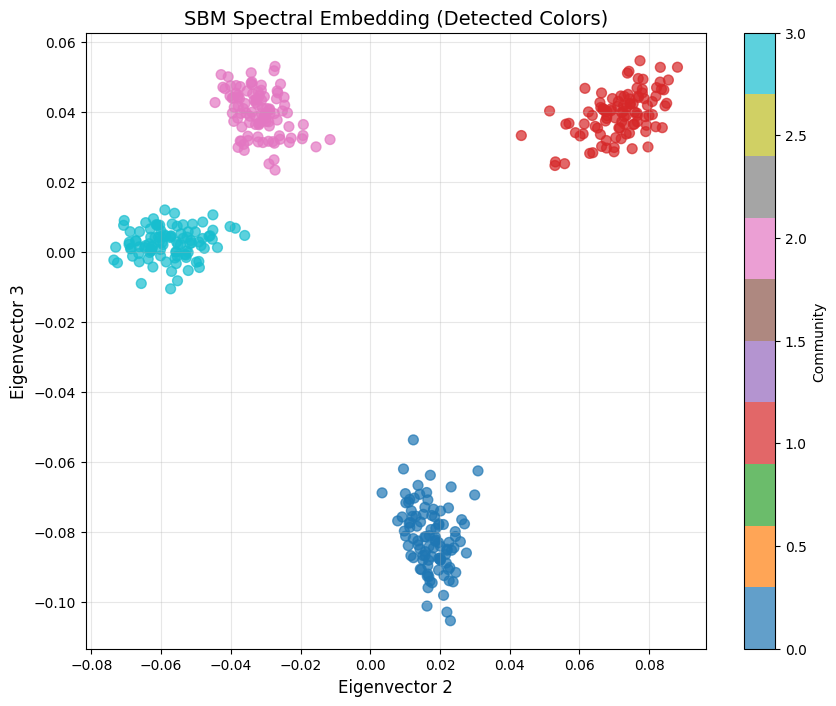

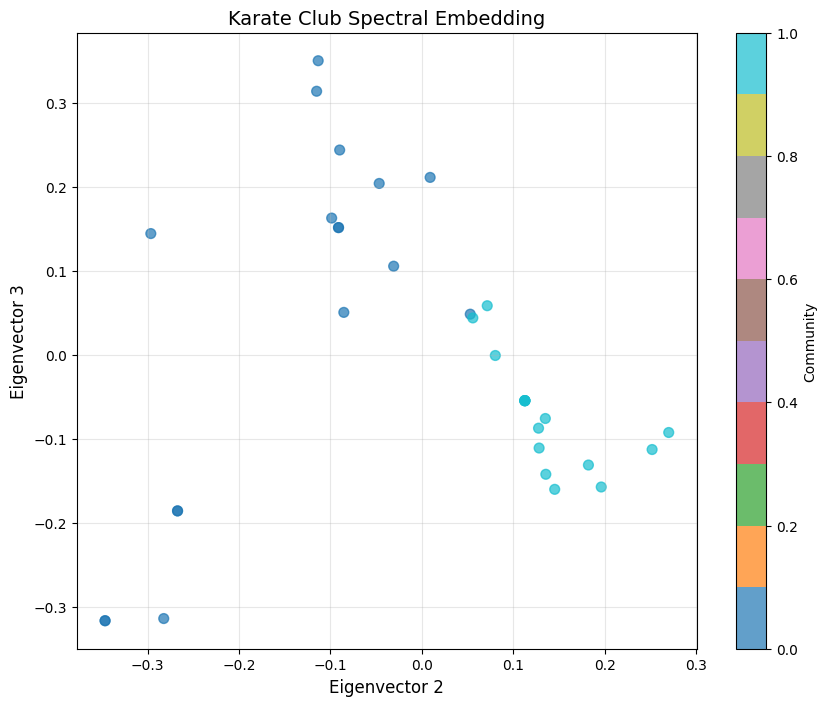


Experiment 5: Spectral vs All Methods (Phase Transition)

  μ = 0.00
  Running Louvain...
  Running Leiden...
  Running Infomap...
  Running LPA...
  Running Spectral (symmetric)...
  Running Spectral (unnormalized)...

  μ = 0.10
  Running Louvain...
  Running Leiden...
  Running Infomap...
  Running LPA...
  Running Spectral (symmetric)...
  Running Spectral (unnormalized)...

  μ = 0.20
  Running Louvain...
  Running Leiden...
  Running Infomap...
  Running LPA...
  Running Spectral (symmetric)...
  Running Spectral (unnormalized)...

  μ = 0.30
  Running Louvain...
  Running Leiden...
  Running Infomap...
  Running LPA...
  Running Spectral (symmetric)...
  Running Spectral (unnormalized)...

  μ = 0.40
  Running Louvain...
  Running Leiden...
  Running Infomap...
  Running LPA...
  Running Spectral (symmetric)...
  Running Spectral (unnormalized)...

  μ = 0.50
  Running Louvain...
  Running Leiden...
  Running Infomap...
  Running LPA...
  Running Spectral (symmetric)...
  Runni

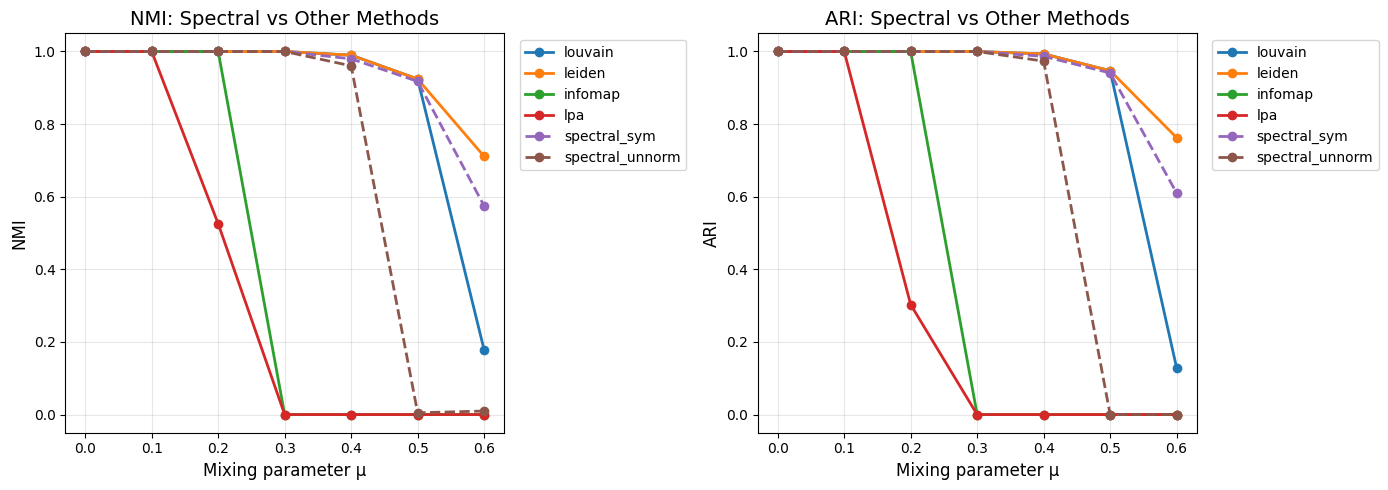


Experiment 6: Cut-Based Metrics Comparison
  Running Louvain...
  Running Leiden...
  Running Infomap...
  Running LPA...
  Running Spectral (symmetric)...
  Running Spectral (unnormalized)...
  Running Recursive Bisection...

                     n_communities      nmi  modularity  normalized_cut   ratio_cut
algorithm                                                                          
louvain                          4  1.00000    0.582822        0.668641   23.700000
leiden                           4  1.00000    0.582822        0.668641   23.700000
infomap                          4  1.00000    0.582822        0.668641   23.700000
lpa                              4  1.00000    0.582822        0.668641   23.700000
spectral_sym                     4  1.00000    0.582822        0.668641   23.700000
spectral_unnorm                  4  1.00000    0.582822        0.668641   23.700000
recursive_bisection             32  0.57295    0.153523       26.141899  926.449936

Experiment 7: S

In [ ]:
"""
M2 Experiments: Spectral Clustering & Eigengap Analysis
"""
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from src.loaders import load_karate_club, graph_summary
from src.generators import generate_sbm, generate_lfr, sbm_parameter_sweep
from src.spectral import spectral_clustering, run_spectral
from src.eigengap_analysis import (
    analyze_spectrum, plot_spectrum, plot_embedding_2d, compare_laplacians
)
from src.mincut import normalized_cut, ratio_cut, recursive_spectral_bisection
from src.metrics import compare_partitions, compute_nmi, compute_ari, compute_modularity
from src.detectors import run_all_detectors

# Create output directory
Path("results"). mkdir(exist_ok=True)


def experiment_1_eigengap_sbm():
    """Test eigengap heuristic on SBM with known k."""
    print("\n" + "="*60)
    print("Experiment 1: Eigengap Heuristic on SBM")
    print("="*60)

    results = []

    for true_k in [2, 3, 4, 5, 6]:
        print(f"\n  Testing k = {true_k} communities...")
        G, gt = generate_sbm(
            sizes=[100] * true_k,
            p_in=0.3,
            p_out=0.02,
            seed=42
        )

        analysis = analyze_spectrum(G, max_k=15, normalized='symmetric')
        detected_k = analysis['optimal_k']

        # Run spectral with detected k
        partition, info = spectral_clustering(G, k=None, seed=42)
        nmi = compute_nmi(partition, gt)

        results.append({
            'true_k': true_k,
            'detected_k': detected_k,
            'correct': true_k == detected_k,
            'nmi': nmi,
            'algebraic_connectivity': analysis['algebraic_connectivity']
        })

        print(f"    True k={true_k}, Detected k={detected_k}, NMI={nmi:.3f}")

    df = pd.DataFrame(results)
    print("\n" + df.to_string(index=False))
    df.to_csv("results/eigengap_sbm.csv", index=False)

    return df


def experiment_2_laplacian_comparison():
    """Compare unnormalized vs normalized Laplacian."""
    print("\n" + "="*60)
    print("Experiment 2: Laplacian Normalization Comparison")
    print("="*60)

    # Create SBM with degree heterogeneity
    G, gt = generate_sbm(
        sizes=[50, 100, 150, 100],  # Unequal sizes
        p_in=0.25,
        p_out=0.02,
        seed=42
    )
    print(f"Graph: {graph_summary(G)}")

    results = compare_laplacians(G, ground_truth=gt, seed=42)

    print("\nResults by Laplacian type:")
    for norm_type, metrics in results.items():
        print(f"\n  {norm_type}:")
        print(f"    k detected: {metrics['k_detected']}")
        print(f"    NMI: {metrics['nmi']:.3f}")
        print(f"    ARI: {metrics['ari']:.3f}")
        print(f"    Modularity: {metrics['modularity']:.3f}")

    return results


def experiment_3_spectrum_visualization():
    """Visualize spectrum for different graph structures."""
    print("\n" + "="*60)
    print("Experiment 3: Spectrum Visualization")
    print("="*60)

    # Well-separated SBM
    G_easy, gt_easy = generate_sbm([100]*4, p_in=0.3, p_out=0.01, seed=42)
    analysis_easy = analyze_spectrum(G_easy, max_k=20)

    plot_spectrum(
        analysis_easy['eigenvalues'],
        analysis_easy['gaps'],
        analysis_easy['optimal_k'],
        title="Well-Separated SBM (4 communities)",
        save_path="results/spectrum_easy.png"
    )

    # Hard SBM (high mixing)
    G_hard, gt_hard = generate_sbm([100]*4, p_in=0.3, p_out=0.15, seed=42)
    analysis_hard = analyze_spectrum(G_hard, max_k=20)

    plot_spectrum(
        analysis_hard['eigenvalues'],
        analysis_hard['gaps'],
        analysis_hard['optimal_k'],
        title="High-Mixing SBM (4 communities, μ=0.5)",
        save_path="results/spectrum_hard.png"
    )

    # Karate Club
    G_karate, gt_karate = load_karate_club()
    analysis_karate = analyze_spectrum(G_karate, max_k=15)

    plot_spectrum(
        analysis_karate['eigenvalues'],
        analysis_karate['gaps'],
        analysis_karate['optimal_k'],
        title="Karate Club",
        save_path="results/spectrum_karate.png"
    )

    return {
        'easy': analysis_easy,
        'hard': analysis_hard,
        'karate': analysis_karate
    }


def experiment_4_embedding_visualization():
    """Visualize 2D spectral embeddings."""
    print("\n" + "="*60)
    print("Experiment 4: Spectral Embedding Visualization")
    print("="*60)

    # SBM
    G, gt = generate_sbm([100]*4, p_in=0.3, p_out=0.02, seed=42)
    partition, _ = spectral_clustering(G, k=4, seed=42)

    plot_embedding_2d(
        G, partition=gt,
        title="SBM Spectral Embedding (Ground Truth Colors)",
        save_path="results/embedding_sbm_gt.png"
    )

    plot_embedding_2d(
        G, partition=partition,
        title="SBM Spectral Embedding (Detected Colors)",
        save_path="results/embedding_sbm_detected.png"
    )

    # Karate Club
    G_k, gt_k = load_karate_club()
    partition_k, _ = spectral_clustering(G_k, k=2, seed=42)

    plot_embedding_2d(
        G_k, partition=gt_k,
        title="Karate Club Spectral Embedding",
        save_path="results/embedding_karate.png"
    )


def experiment_5_spectral_vs_all():
    """Compare spectral with other methods across mixing parameters."""
    print("\n" + "="*60)
    print("Experiment 5: Spectral vs All Methods (Phase Transition)")
    print("="*60)

    mu_values = np.linspace(0.0, 0.6, 7)
    records = []

    for mu in mu_values:
        print(f"\n  μ = {mu:.2f}")
        G, gt = generate_sbm([100]*4, p_in=0.3, p_out=mu*0.3, seed=42)

        # Run M1 detectors
        partitions = run_all_detectors(G, seed=42, resolution=1.0)

        # Add spectral methods manually
        print("  Running Spectral (symmetric)...")
        partitions['spectral_sym'] = run_spectral(G, normalized='symmetric', seed=42)

        print("  Running Spectral (unnormalized)...")
        partitions['spectral_unnorm'] = run_spectral(G, normalized='unnormalized', seed=42)

        for algo, partition in partitions.items():
            records.append({
                'mu': mu,
                'algorithm': algo,
                'nmi': compute_nmi(partition, gt),
                'ari': compute_ari(partition, gt),
                'n_communities': len(set(partition.values()))
            })

    df = pd.DataFrame(records)
    df. to_csv("results/spectral_phase_transition.csv", index=False)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for algo in df['algorithm'].unique():
        subset = df[df['algorithm'] == algo]
        style = '--' if 'spectral' in algo else '-'
        axes[0].plot(subset['mu'], subset['nmi'], f'o{style}',
                    label=algo, linewidth=2, markersize=6)
        axes[1].plot(subset['mu'], subset['ari'], f'o{style}',
                    label=algo, linewidth=2, markersize=6)

    axes[0].set_xlabel('Mixing parameter μ', fontsize=12)
    axes[0].set_ylabel('NMI', fontsize=12)
    axes[0].set_title('NMI: Spectral vs Other Methods', fontsize=14)
    axes[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    axes[0].grid(True, alpha=0.3)

    axes[1].set_xlabel('Mixing parameter μ', fontsize=12)
    axes[1].set_ylabel('ARI', fontsize=12)
    axes[1].set_title('ARI: Spectral vs Other Methods', fontsize=14)
    axes[1].legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("results/spectral_comparison.png", dpi=150, bbox_inches='tight')
    plt.show()

    return df

def experiment_6_cut_metrics():
    """Evaluate partitions using cut-based metrics."""
    print("\n" + "="*60)
    print("Experiment 6: Cut-Based Metrics Comparison")
    print("="*60)

    G, gt = generate_sbm([100]*4, p_in=0.3, p_out=0.02, seed=42)

    # Run M1 detectors
    partitions = run_all_detectors(G, seed=42, resolution=1.0)

    # Add spectral methods manually
    print("  Running Spectral (symmetric)...")
    partitions['spectral_sym'] = run_spectral(G, normalized='symmetric', seed=42)

    print("  Running Spectral (unnormalized)...")
    partitions['spectral_unnorm'] = run_spectral(G, normalized='unnormalized', seed=42)

    # Add recursive bisection
    print("  Running Recursive Bisection...")
    partitions['recursive_bisection'] = recursive_spectral_bisection(G, min_size=20, seed=42)

    results = []
    for algo, partition in partitions. items():
        results.append({
            'algorithm': algo,
            'n_communities': len(set(partition.values())),
            'nmi': compute_nmi(partition, gt),
            'modularity': compute_modularity(G, partition),
            'normalized_cut': normalized_cut(G, partition),
            'ratio_cut': ratio_cut(G, partition)
        })

    df = pd.DataFrame(results). set_index('algorithm')
    print("\n" + df.to_string())
    df.to_csv("results/cut_metrics.csv")

    return df

def experiment_7_lfr_spectral():
    """Test spectral on LFR benchmark."""
    print("\n" + "="*60)
    print("Experiment 7: Spectral on LFR Benchmark")
    print("="*60)

    records = []

    for mu in [0.1, 0.2, 0.3, 0.4, 0.5]:
        print(f"\n  LFR μ = {mu}")

        try:
            G, gt = generate_lfr(n=1000, mu=mu, seed=42)
            true_k = len(set(gt. values()))
            print(f"    True communities: {true_k}")

            # Spectral with eigengap
            partition_auto, info = spectral_clustering(G, k=None, seed=42)
            detected_k = info['k']

            # Spectral with true k
            partition_true_k, _ = spectral_clustering(G, k=true_k, seed=42)

            records.append({
                'mu': mu,
                'true_k': true_k,
                'detected_k': detected_k,
                'nmi_auto_k': compute_nmi(partition_auto, gt),
                'nmi_true_k': compute_nmi(partition_true_k, gt),
            })

        except Exception as e:
            print(f"    Error: {e}")

    df = pd. DataFrame(records)
    print("\n" + df.to_string(index=False))
    df.to_csv("results/lfr_spectral.csv", index=False)

    return df


if __name__ == "__main__":
    print("M2 Experiments: Spectral Clustering")
    print("="*60)

    experiment_1_eigengap_sbm()
    experiment_2_laplacian_comparison()
    experiment_3_spectrum_visualization()
    experiment_4_embedding_visualization()
    experiment_5_spectral_vs_all()
    experiment_6_cut_metrics()
    experiment_7_lfr_spectral()

    print("\n" + "="*60)
    print("✅ M2 COMPLETE!")
    print("="*60)
    print("\nGenerated files:")
    print("  - results/eigengap_sbm.csv")
    print("  - results/spectrum_*.png")
    print("  - results/embedding_*.png")
    print("  - results/spectral_phase_transition.csv")
    print("  - results/spectral_comparison.png")
    print("  - results/cut_metrics.csv")
    print("  - results/lfr_spectral.csv")

#ricci curvature


In [ ]:
# Cell 1: Install dependencies
!pip install GraphRicciCurvature python-igraph leidenalg infomap networkx scikit-learn matplotlib pandas -q

# Cell 2: Import and run
import networkx as nx
from GraphRicciCurvature. OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci

# Example: Karate Club
G = nx.karate_club_graph()
for u, v in G.edges():
    G[u][v].clear()

# Compute Ollivier-Ricci
orc = OllivierRicci(G, alpha=0.5, verbose="INFO")
orc.compute_ricci_curvature()

# Run Ricci flow
orc.compute_ricci_flow(iterations=50)
G_rf = orc.G

# Check results
print("First 5 edges after flow:")
for u, v in list(G_rf. edges())[:5]:
    print(f"  ({u},{v}): curvature={G_rf[u][v]['ricciCurvature']:.4f}, weight={G_rf[u][v]['weight']:.4f}")

INFO:GraphRicciCurvature:Edge weight not detected in graph, use "weight" as default edge weight.
INFO:GraphRicciCurvature:0.142929 secs for Ricci curvature computation.
INFO:GraphRicciCurvature:No ricciCurvature detected, compute original_RC...
INFO:GraphRicciCurvature:0.120409 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 0 === 
INFO:GraphRicciCurvature:0.119219 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 1 === 
INFO:GraphRicciCurvature:0.125537 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 2 === 
INFO:GraphRicciCurvature:0.120209 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 3 === 
INFO:GraphRicciCurvature:0.117274 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ricci flow iteration 4 === 
INFO:GraphRicciCurvature:0.138679 secs for Ricci curvature computation.
INFO:GraphRicciCurvature: === Ric

First 5 edges after flow:
  (0,1): curvature=0.0095, weight=0.0001
  (0,2): curvature=0.0148, weight=0.0003
  (0,3): curvature=0.0160, weight=0.0002
  (0,4): curvature=-0.0000, weight=3.0854
  (0,5): curvature=-0.0000, weight=3.0855


In [ ]:
"""
Ricci curvature using GraphRicciCurvature library.
https://github.com/saibalmars/GraphRicciCurvature
"""
import numpy as np
import networkx as nx
from typing import Dict, Tuple, List, Optional
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci


# =============================================================================
# OLLIVIER-RICCI CURVATURE
# =============================================================================

def compute_ollivier_ricci(G: nx.Graph,
                           alpha: float = 0.5,
                           verbose: str = "ERROR") -> Tuple[nx.Graph, Dict[Tuple[int, int], float]]:
    """
    Compute Ollivier-Ricci curvature for all edges using GraphRicciCurvature.

    Args:
        G: NetworkX graph
        alpha: Laziness parameter (probability of staying at node)
               alpha=0: pure random walk
               alpha=0.5: standard choice (Lin-Yau)
               alpha=1: stay at node
        verbose: Logging level ("TRACE", "DEBUG", "INFO", "WARNING", "ERROR")

    Returns:
        G_orc: Graph with curvature attributes
        curvatures: Dictionary mapping (u, v) to curvature value
    """
    # Remove existing edge attributes that might interfere
    G_clean = G.copy()
    for u, v in G_clean.edges():
        G_clean[u][v].clear()

    # Compute Ollivier-Ricci curvature
    orc = OllivierRicci(G_clean, alpha=alpha, verbose=verbose)
    orc.compute_ricci_curvature()
    G_orc = orc.G.copy()

    # Extract curvatures as dictionary
    curvatures = {}
    for u, v in G_orc.edges():
        curv = G_orc[u][v].get('ricciCurvature', 0)
        curvatures[(u, v)] = curv
        curvatures[(v, u)] = curv

    return G_orc, curvatures


# =============================================================================
# FORMAN-RICCI CURVATURE
# =============================================================================

def compute_forman_ricci(G: nx.Graph,
                         verbose: str = "ERROR") -> Tuple[nx.Graph, Dict[Tuple[int, int], float]]:
    """
    Compute Forman-Ricci curvature for all edges using GraphRicciCurvature.

    Much faster than Ollivier-Ricci (no optimal transport).

    Args:
        G: NetworkX graph
        verbose: Logging level

    Returns:
        G_frc: Graph with curvature attributes
        curvatures: Dictionary mapping (u, v) to curvature value
    """
    # Remove existing edge attributes
    G_clean = G.copy()
    for u, v in G_clean.edges():
        G_clean[u][v].clear()

    # Compute Forman-Ricci curvature
    frc = FormanRicci(G_clean, verbose=verbose)
    frc.compute_ricci_curvature()
    G_frc = frc.G.copy()

    # Extract curvatures as dictionary
    curvatures = {}
    for u, v in G_frc.edges():
        curv = G_frc[u][v].get('formanCurvature', 0)
        curvatures[(u, v)] = curv
        curvatures[(v, u)] = curv

    return G_frc, curvatures


# =============================================================================
# CURVATURE STATISTICS
# =============================================================================

def curvature_statistics(curvatures: Dict[Tuple[int, int], float]) -> Dict[str, float]:
    """Compute statistics of edge curvatures."""
    # Get unique edges only
    unique_edges = set()
    values = []
    for (u, v), curv in curvatures.items():
        edge = tuple(sorted([u, v]))
        if edge not in unique_edges:
            unique_edges.add(edge)
            values.append(curv)

    values = np.array(values)

    return {
        'mean': float(np.mean(values)),
        'std': float(np.std(values)),
        'min': float(np.min(values)),
        'max': float(np.max(values)),
        'median': float(np.median(values)),
        'negative_fraction': float(np.mean(values < 0)),
        'n_edges': len(values)
    }


def classify_edges_by_curvature(G: nx.Graph,
                                 curvatures: Dict[Tuple[int, int], float],
                                 ground_truth: Dict[int, int]) -> Dict[str, List[float]]:
    """
    Classify edges as intra-community or inter-community and get their curvatures.
    """
    intra_curvatures = []
    inter_curvatures = []

    for u, v in G.edges():
        curv = curvatures.get((u, v), curvatures.get((v, u), 0))

        if ground_truth.get(u) == ground_truth.get(v):
            intra_curvatures.append(curv)
        else:
            inter_curvatures.append(curv)

    return {
        'intra_community': intra_curvatures,
        'inter_community': inter_curvatures
    }


def get_curvature_from_graph(G: nx.Graph,
                              curvature_attr: str = 'ricciCurvature') -> Dict[Tuple[int, int], float]:
    """Extract curvature dictionary from graph with curvature attributes."""
    curvatures = {}
    for u, v in G.edges():
        curv = G[u][v].get(curvature_attr, 0)
        curvatures[(u, v)] = curv
        curvatures[(v, u)] = curv
    return curvatures

#ricci flow

In [ ]:
"""
Ricci flow for community detection using GraphRicciCurvature library.
"""
import numpy as np
import networkx as nx
from typing import Dict, Tuple, List, Optional
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci


def run_ricci_flow(G: nx.Graph,
                   alpha: float = 0.5,
                   iterations: int = 50,
                   step: float = 1.0,
                   delta: float = 1e-4,
                   verbose: str = "ERROR") -> Tuple[nx.Graph, List[Dict]]:
    """
    Run Ollivier-Ricci flow on graph.

    Args:
        G: NetworkX graph
        alpha: Laziness parameter for Ollivier-Ricci
        iterations: Number of flow iterations
        step: Step size for flow
        delta: Convergence threshold
        verbose: Logging level

    Returns:
        G_rf: Graph after Ricci flow with updated edge weights
        history: List of curvature statistics per iteration
    """
    # Clean graph
    G_clean = G.copy()
    for u, v in G_clean.edges():
        G_clean[u][v].clear()

    # Initialize Ricci flow
    orc = OllivierRicci(G_clean, alpha=alpha, verbose=verbose)

    # Track history
    history = []

    # Compute initial curvature
    orc.compute_ricci_curvature()
    initial_curvs = get_curvature_from_graph(orc.G, 'ricciCurvature')
    history.append({
        'iteration': 0,
        'stats': curvature_statistics(initial_curvs)
    })

    # Run Ricci flow
    orc.compute_ricci_flow(iterations=iterations, step=step, delta=delta)

    G_rf = orc.G.copy()

    # Get final statistics
    final_curvs = get_curvature_from_graph(G_rf, 'ricciCurvature')
    history.append({
        'iteration': iterations,
        'stats': curvature_statistics(final_curvs)
    })

    return G_rf, history


def surgery(G: nx.Graph,
            weight: str = "weight",
            cut: float = None,
            percentile: float = None) -> Tuple[nx.Graph, List[Tuple]]:
    """
    Remove edges with weight above threshold (bottleneck edges after Ricci flow).

    Args:
        G: Graph with edge weights from Ricci flow
        weight: Edge weight attribute name
        cut: Manual cutoff value (edges with weight > cut are removed)
        percentile: Remove edges above this percentile of weights

    Returns:
        G_cut: Graph after edge removal
        removed_edges: List of removed edges
    """
    G_cut = G.copy()
    weights = nx.get_edge_attributes(G_cut, weight)

    if not weights:
        print("Warning: No edge weights found!")
        return G_cut, []

    # Determine cutoff
    if cut is None:
        if percentile is not None:
            cut = np.percentile(list(weights.values()), percentile)
        else:
            # Default: use heuristic from tutorial
            max_w = max(weights.values())
            cut = (max_w - 1.0) * 0.6 + 1.0

    # Find edges to remove
    edges_to_remove = [(u, v) for (u, v), w in weights.items() if w > cut]

    G_cut.remove_edges_from(edges_to_remove)

    return G_cut, edges_to_remove


def ricci_community_detection(G: nx.Graph,
                               alpha: float = 0.5,
                               iterations: int = 50,
                               cut: float = None,
                               auto_cut: bool = True,
                               verbose: str = "ERROR") -> Dict[int, int]:
    """
    Community detection via Ricci flow and edge surgery.

    Process:
    1. Run Ricci flow to evolve edge weights
    2. Remove edges with high weight (stretched by negative curvature)
    3.Connected components = communities

    Args:
        G: Input graph
        alpha: Ollivier laziness parameter
        iterations: Number of Ricci flow iterations
        cut: Manual weight cutoff for surgery
        auto_cut: Use automatic cutoff detection
        verbose: Logging level

    Returns:
        Partition dictionary (node -> community_id)
    """
    # Run Ricci flow
    G_rf, _ = run_ricci_flow(G, alpha=alpha, iterations=iterations, verbose=verbose)

    # Auto-detect good cut point
    if auto_cut and cut is None:
        cut = find_best_cut(G_rf)

    # Perform surgery
    G_cut, removed = surgery(G_rf, cut=cut)

    # Communities = connected components
    partition = {}
    for comm_id, component in enumerate(nx.connected_components(G_cut)):
        for node in component:
            partition[node] = comm_id

    return partition


def find_best_cut(G: nx.Graph,
                  weight: str = "weight",
                  n_cuts: int = 50) -> float:
    """
    Find optimal cut point by scanning modularity.

    Based on the tutorial's approach: find where modularity drops significantly.
    """
    import community.community_louvain as community_louvain

    weights = nx.get_edge_attributes(G, weight)
    if not weights:
        return 1.0

    max_w = max(weights.values())
    min_w = min(weights.values())

    cutoff_range = np.linspace(max_w, min_w, n_cuts)

    best_cut = max_w
    best_modularity = -1

    G_temp = G.copy()

    for cutoff in cutoff_range:
        # Remove edges above cutoff
        edges_to_remove = [(u, v) for u, v in G_temp.edges()
                          if G_temp[u][v].get(weight, 0) > cutoff]
        G_temp.remove_edges_from(edges_to_remove)

        if G_temp.number_of_edges() == 0:
            continue

        # Get connected components as clustering
        cc = list(nx.connected_components(G_temp))
        if len(cc) <= 1:
            continue

        # Compute modularity
        try:
            mod = nx.community.modularity(G_temp, cc)
            if mod > best_modularity:
                best_modularity = mod
                best_cut = cutoff
        except:
            continue

    return best_cut


def run_ricci(G: nx.Graph,
              alpha: float = 0.5,
              iterations: int = 50,
              seed: int = None) -> Dict[int, int]:
    """
    Wrapper for Ricci-based community detection matching detector interface.
    """
    return ricci_community_detection(
        G,
        alpha=alpha,
        iterations=iterations,
        verbose="ERROR"
    )

#analysis

In [ ]:
"""
Analysis and visualization tools for Ricci curvature.
"""
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from typing import Dict, Tuple, List
from sklearn import preprocessing


def plot_curvature_histogram(G: nx.Graph,
                              curvature_attr: str = 'ricciCurvature',
                              weight_attr: str = 'weight',
                              title: str = "Curvature Distribution",
                              save_path: str = None):
    """
    Plot histogram of curvatures and weights (similar to tutorial's show_results).
    """
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))

    # Curvature histogram
    curvatures = [G[u][v].get(curvature_attr, 0) for u, v in G.edges()]
    axes[0].hist(curvatures, bins=20, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0].set_xlabel('Ricci Curvature', fontsize=12)
    axes[0].set_ylabel('Count', fontsize=12)
    axes[0].set_title(f'{title} - Curvature', fontsize=14)
    axes[0].axvline(x=0, color='red', linestyle='--', linewidth=1.5)
    axes[0].grid(True, alpha=0.3)

    # Weight histogram
    weights = [G[u][v].get(weight_attr, 1) for u, v in G.edges()]
    axes[1].hist(weights, bins=20, alpha=0.7, color='orange', edgecolor='black')
    axes[1].set_xlabel('Edge Weight', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].set_title(f'{title} - Edge Weights', fontsize=14)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()
    return fig


def plot_curvature_by_community(G: nx.Graph,
                                 curvatures: Dict[Tuple[int, int], float],
                                 ground_truth: Dict[int, int],
                                 title: str = "Curvature by Edge Type",
                                 save_path: str = None):
    """
    Plot curvature distribution separated by intra/inter-community edges.
    """
    classified = classify_edges_by_curvature(G, curvatures, ground_truth)

    fig, ax = plt.subplots(figsize=(10, 6))

    ax.hist(classified['intra_community'], bins=25, alpha=0.6,
            label=f"Intra-community (n={len(classified['intra_community'])})",
            color='green', density=True)
    ax.hist(classified['inter_community'], bins=25, alpha=0.6,
            label=f"Inter-community (n={len(classified['inter_community'])})",
            color='red', density=True)

    ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5, label='κ=0')
    ax.set_xlabel('Curvature', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()
    return fig


def plot_graph_with_curvature(G: nx.Graph,
                               curvature_attr: str = 'ricciCurvature',
                               clustering_label: str = None,
                               title: str = "Graph with Curvature",
                               save_path: str = None):
    """
    Draw graph with edges colored by curvature and nodes by community.
    """
    fig, ax = plt.subplots(figsize=(12, 10))

    pos = nx.spring_layout(G, seed=42)

    # Node colors
    if clustering_label and nx.get_node_attributes(G, clustering_label):
        node_attrs = nx.get_node_attributes(G, clustering_label)
        le = preprocessing.LabelEncoder()
        node_colors = le.fit_transform(list(node_attrs.values()))
    else:
        node_colors = 'lightblue'

    # Edge colors by curvature
    edge_colors = [G[u][v].get(curvature_attr, 0) for u, v in G.edges()]

    # Draw
    nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                           cmap=plt.cm.tab10, node_size=200, ax=ax)

    edges = nx.draw_networkx_edges(G, pos, edge_color=edge_colors,
                                    edge_cmap=plt.cm.RdYlGn,
                                    width=2, ax=ax)

    nx.draw_networkx_labels(G, pos, font_size=8, ax=ax)

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn,
                                norm=plt.Normalize(vmin=min(edge_colors),
                                                   vmax=max(edge_colors)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
    cbar.set_label('Curvature', fontsize=12)

    ax.set_title(title, fontsize=14)
    ax.axis('off')

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()
    return fig


def plot_cut_scan(G: nx.Graph,
                  ground_truth: Dict[int, int] = None,
                  weight: str = "weight",
                  clustering_label: str = "club",
                  title: str = "Cut Point Analysis",
                  save_path: str = None):
    """
    Scan through cut points and plot modularity/ARI (from tutorial).
    """
    import community.community_louvain as community_louvain
    from sklearn.metrics import adjusted_rand_score

    weights = nx.get_edge_attributes(G, weight)
    if not weights:
        print("No weights found!")
        return

    max_w = max(weights.values())
    cutoff_range = np.arange(max_w, 1, -0.025)

    modularity_scores = []
    ari_scores = []

    G_temp = G.copy()

    for cutoff in cutoff_range:
        # Remove edges above cutoff
        edges_to_remove = [(u, v) for u, v in G_temp.edges()
                          if G_temp[u][v].get(weight, 0) > cutoff]
        G_temp.remove_edges_from(edges_to_remove)

        # Get connected components
        cc = list(nx.connected_components(G_temp))
        clustering = {node: idx for idx, comp in enumerate(cc) for node in comp}

        # Modularity
        if G_temp.number_of_edges() > 0:
            try:
                mod = community_louvain.modularity(clustering, G_temp, weight)
            except:
                mod = 0
        else:
            mod = 0
        modularity_scores.append(mod)

        # ARI (if ground truth available)
        if ground_truth:
            nodes = list(G.nodes())
            y_true = [ground_truth.get(n, 0) for n in nodes]
            y_pred = [clustering.get(n, 0) for n in nodes]
            ari = adjusted_rand_score(y_true, y_pred)
        else:
            ari = 0
        ari_scores.append(ari)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(cutoff_range, modularity_scores, 'b-', linewidth=2, label='Modularity', alpha=0.8)
    ax.plot(cutoff_range, ari_scores, 'g-', linewidth=2, label='ARI', alpha=0.8)

    # Find best cut (where modularity drops)
    best_idx = np.argmax(modularity_scores)
    best_cut = cutoff_range[best_idx]
    ax.axvline(x=best_cut, color='red', linestyle='--', linewidth=2, label=f'Best cut={best_cut:.2f}')

    ax.set_xlim(max_w, 1)
    ax.set_xlabel('Edge Weight Cutoff', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()

    print(f"Best cut: {best_cut:.3f}, Modularity: {modularity_scores[best_idx]:.3f}, ARI: {ari_scores[best_idx]:.3f}")

    return fig, best_cut


def compare_curvature_methods(G: nx.Graph,
                               ground_truth: Dict[int, int] = None,
                               alpha: float = 0.5) -> Dict[str, Dict]:
    """
    Compare Forman vs Ollivier curvature on same graph.
    """
    results = {}

    print("  Computing Ollivier-Ricci curvature...")
    G_orc, ollivier_curvs = compute_ollivier_ricci(G, alpha=alpha)
    results['ollivier'] = {
        'graph': G_orc,
        'curvatures': ollivier_curvs,
        'stats': curvature_statistics(ollivier_curvs)
    }

    print("  Computing Forman-Ricci curvature...")
    G_frc, forman_curvs = compute_forman_ricci(G)
    results['forman'] = {
        'graph': G_frc,
        'curvatures': forman_curvs,
        'stats': curvature_statistics(forman_curvs)
    }

    # Separation analysis if ground truth available
    if ground_truth:
        for method in ['ollivier', 'forman']:
            classified = classify_edges_by_curvature(
                G, results[method]['curvatures'], ground_truth
            )
            intra_mean = np.mean(classified['intra_community']) if classified['intra_community'] else 0
            inter_mean = np.mean(classified['inter_community']) if classified['inter_community'] else 0

            results[method]['intra_mean'] = intra_mean
            results[method]['inter_mean'] = inter_mean
            results[method]['separation'] = intra_mean - inter_mean

    return results

#M3

INFO:GraphRicciCurvature:Edge weight not detected in graph, use "weight" as default edge weight.


M3 Experiments: Ricci Curvature using GraphRicciCurvature

Experiment 1: Curvature Basics on Karate Club
Graph: {'nodes': 34, 'edges': 78, 'density': 0.13903743315508021, 'avg_degree': 4.588235294117647, 'connected_components': 1}

--- Ollivier-Ricci Curvature ---


INFO:GraphRicciCurvature:0.336769 secs for Ricci curvature computation.



First 5 edges:
  Edge (0,1): κ = 0.1111
  Edge (0,2): κ = -0.1438
  Edge (0,3): κ = 0.0417
  Edge (0,4): κ = -0.1146
  Edge (0,5): κ = -0.2812

Statistics: {'mean': 0.07085585302497072, 'std': 0.18966468172999604, 'min': -0.4270833333333335, 'max': 0.5, 'median': 0.08823529411764708, 'negative_fraction': 0.3333333333333333, 'n_edges': 78}


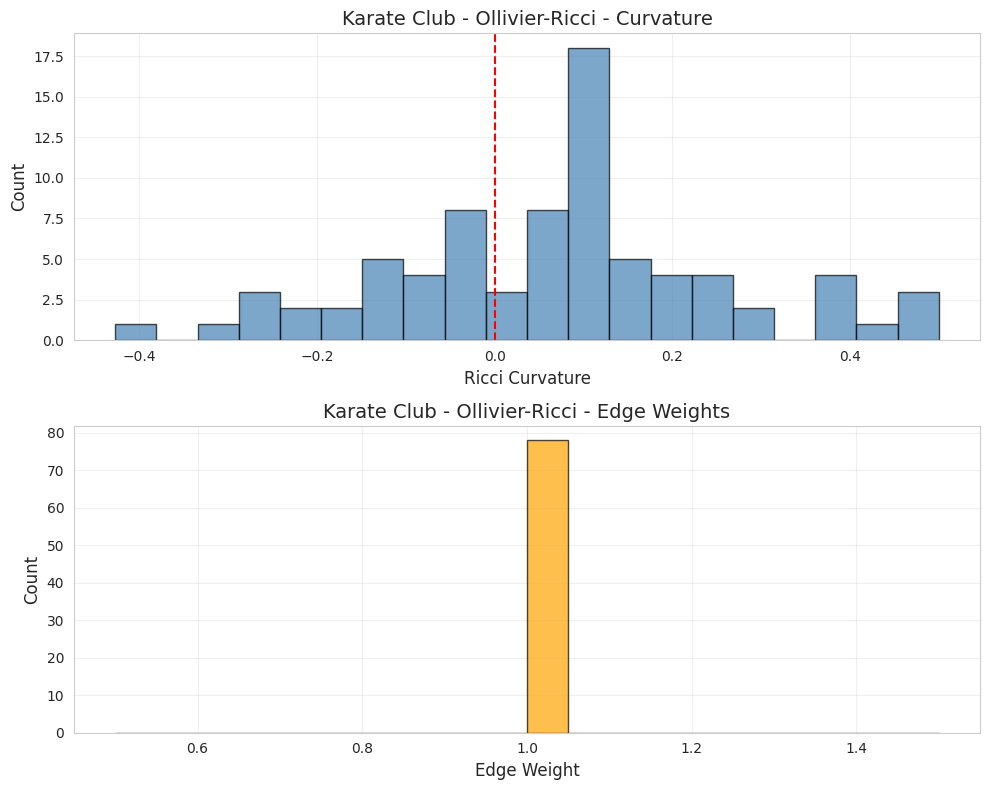

INFO:GraphRicciCurvature:Edge weight not detected in graph, use "weight" as default edge weight.
INFO:GraphRicciCurvature:Node weight not detected in graph, use "weight" as default node weight.



--- Forman-Ricci Curvature ---

First 5 edges:
  Edge (0,1): κ = 0.0000
  Edge (0,2): κ = -7.0000
  Edge (0,3): κ = -3.0000
  Edge (0,4): κ = -9.0000
  Edge (0,5): κ = -10.0000

Statistics: {'mean': -6.346153846153846, 'std': 5.597222120258481, 'min': -18.0, 'max': 5.0, 'median': -7.0, 'negative_fraction': 0.782051282051282, 'n_edges': 78}


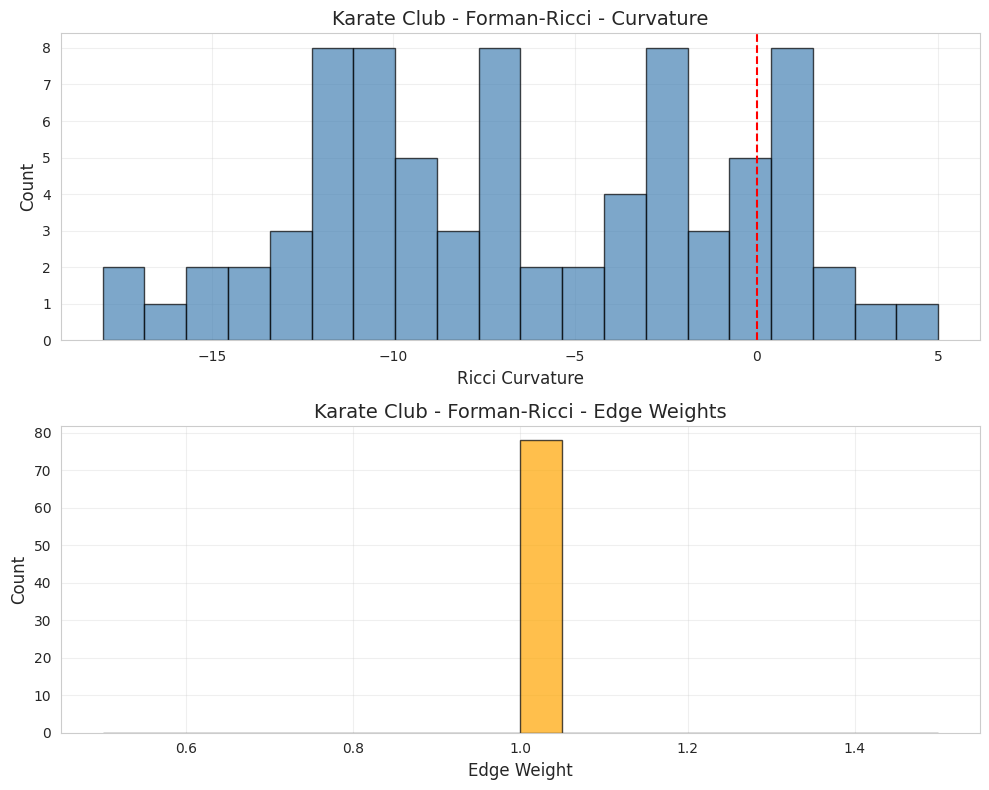

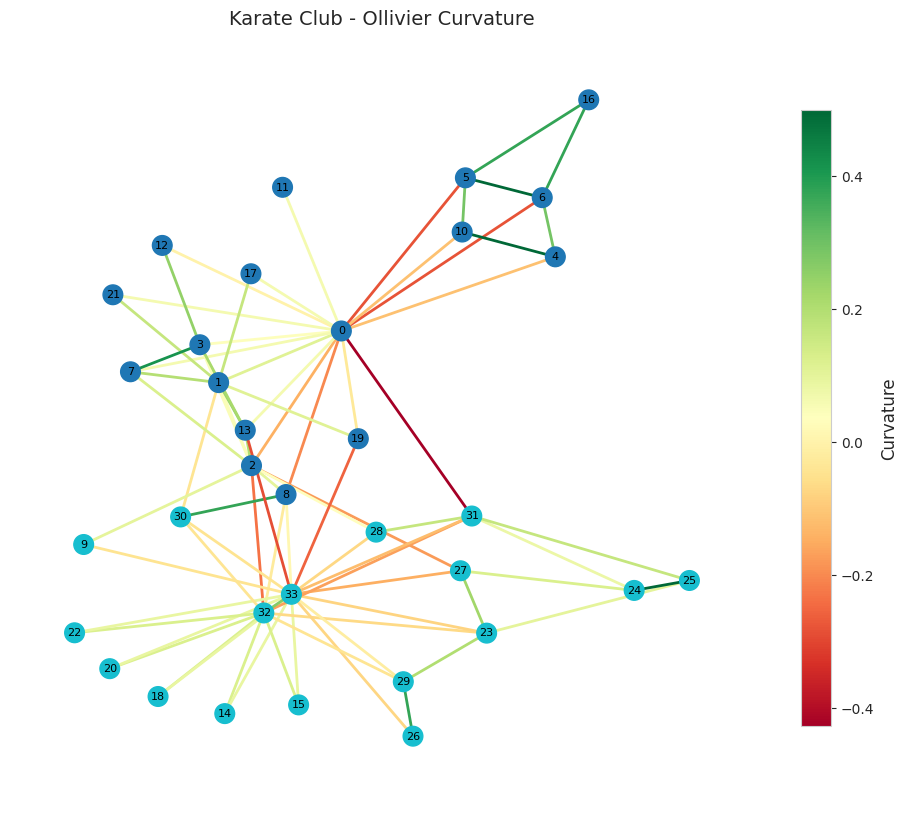


Experiment 2: Curvature Separation Analysis
SBM: {'nodes': 400, 'edges': 7089, 'density': 0.08883458646616542, 'avg_degree': 35.445, 'connected_components': 1}
  Computing Ollivier-Ricci curvature...
  Computing Forman-Ricci curvature...

OLLIVIER:
  Mean curvature: 0.0452
  Intra-community mean: 0.0950
  Inter-community mean: -0.2031
  Separation (intra - inter): 0.2981

FORMAN:
  Mean curvature: -45.8571
  Intra-community mean: -41.9604
  Inter-community mean: -65.2717
  Separation (intra - inter): 23.3114


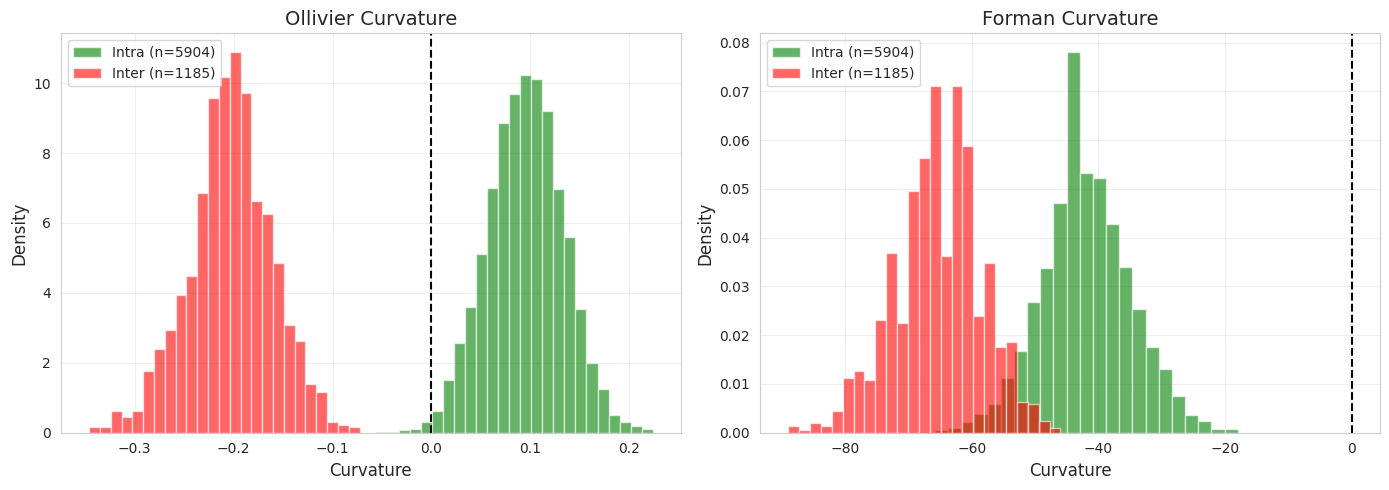

INFO:GraphRicciCurvature:Edge weight not detected in graph, use "weight" as default edge weight.



Experiment 3: Ricci Flow on Karate Club
Computing initial curvature...


INFO:GraphRicciCurvature:0.188636 secs for Ricci curvature computation.


Initial curvature range: [-0.4271, 0.5000]

Running Ricci flow (50 iterations)...
Final curvature range: [-0.0006, 0.1290]
Final weight range: [0.0000, 3.7171]


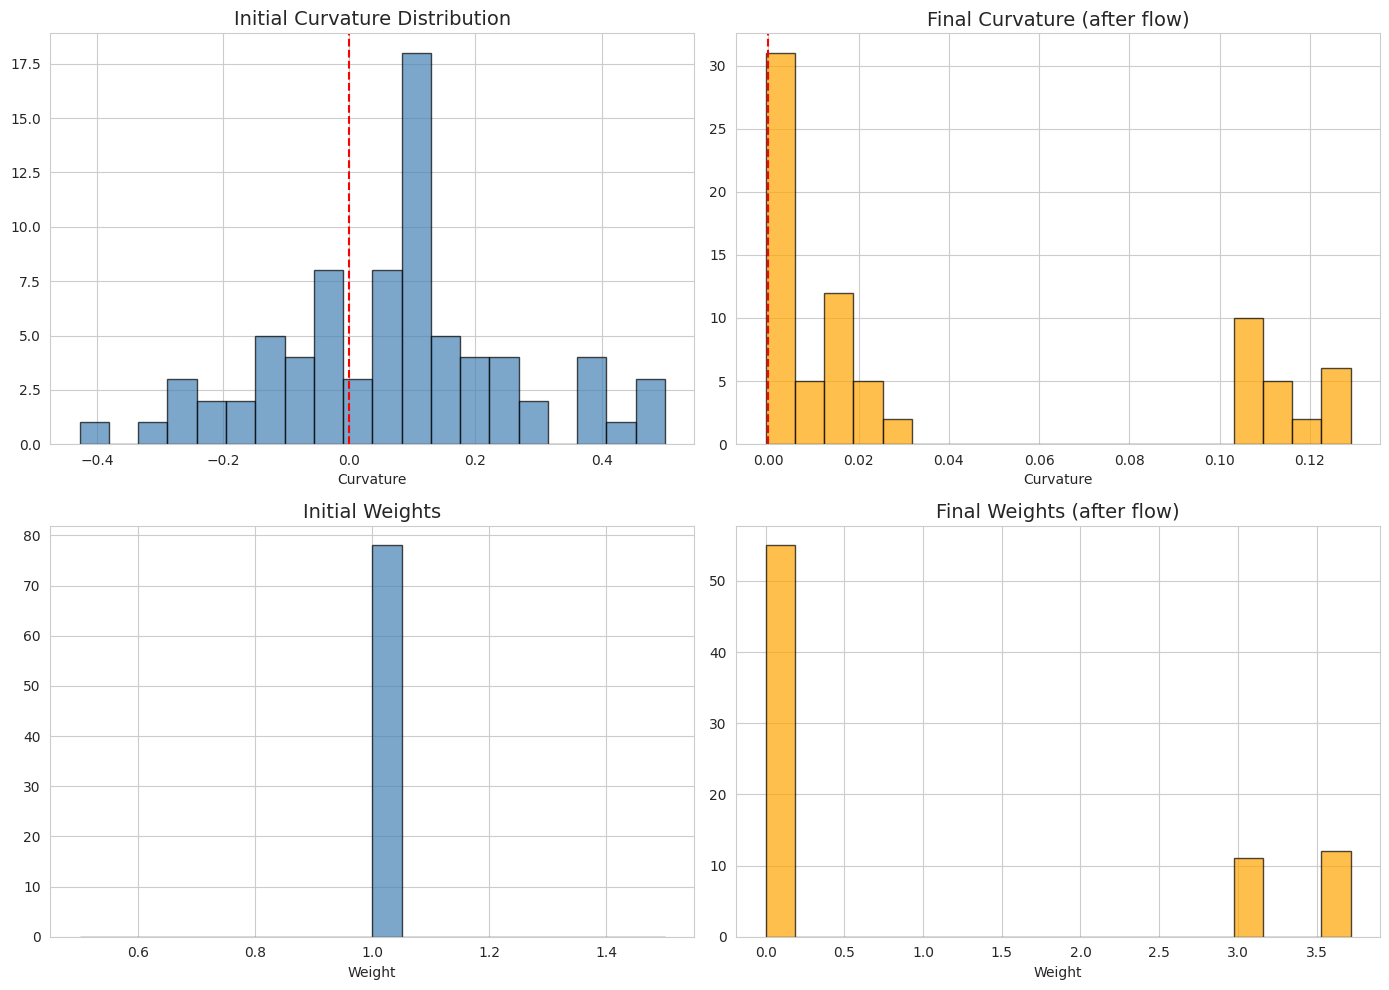


Experiment 4: Community Detection via Surgery
Running Ricci flow...

Scanning cut points...


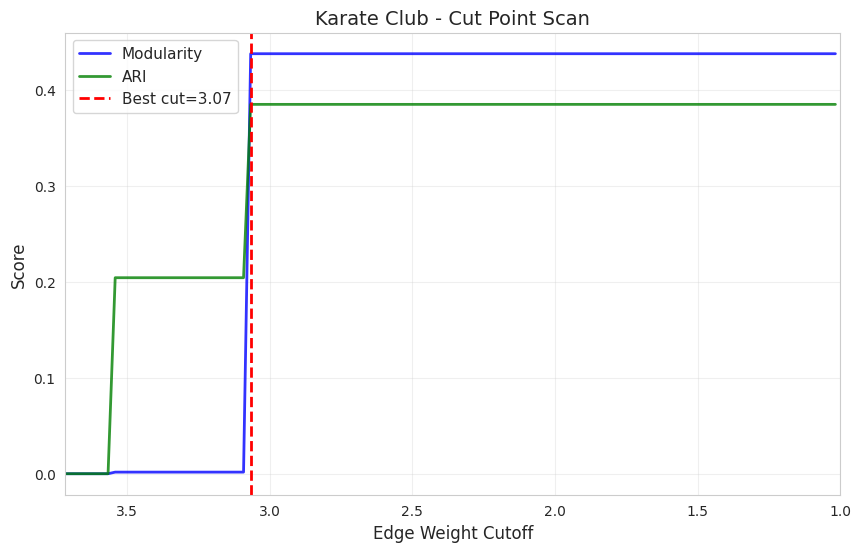

Best cut: 3.067, Modularity: 0.437, ARI: 0.385

Performing surgery at cut=3.067...
Removed 23 edges
Remaining edges: 55
Communities found: 4
NMI: 0.4910
ARI: 0.3846


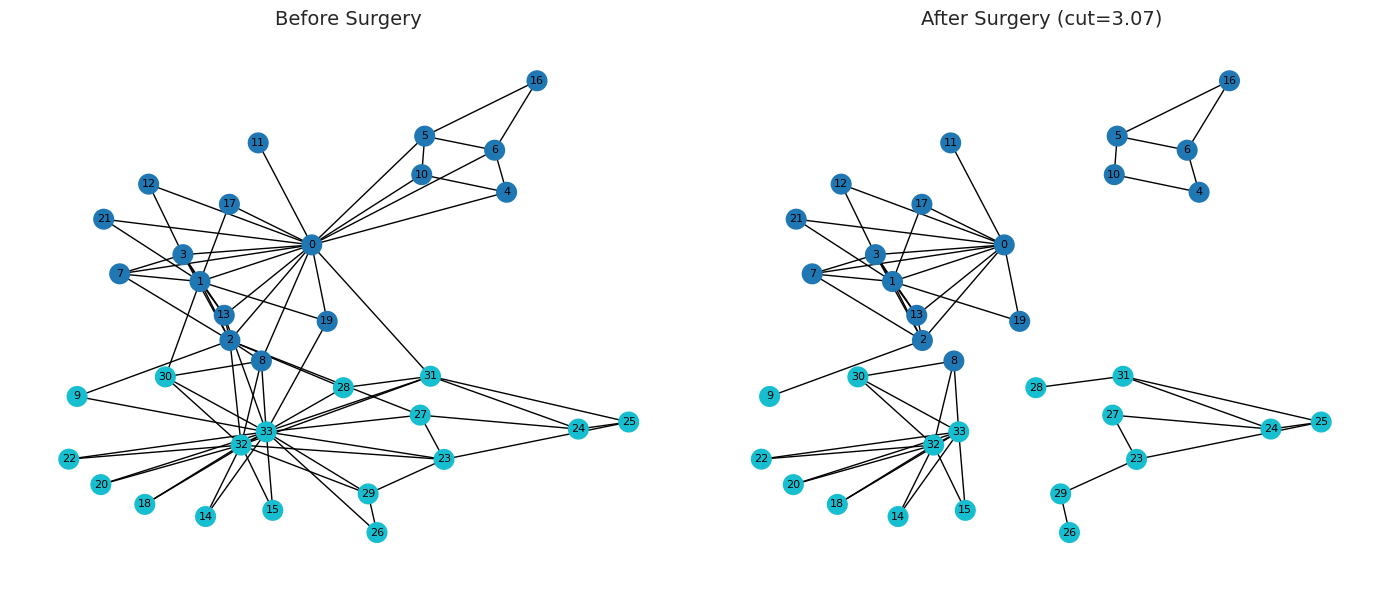


Experiment 5: Ricci vs Other Methods
SBM: {'nodes': 400, 'edges': 7089, 'density': 0.08883458646616542, 'avg_degree': 35.445, 'connected_components': 1}

Running community detection methods...
  Running Louvain...
  Running Leiden...
  Running Infomap...
  Running LPA...
  Running Spectral (symmetric)...
  Running Spectral (unnormalized)...
Running Spectral...
Running Ricci Flow...

Results:
                 num_communities  modularity  coverage  avg_conductance  nmi  ari
algorithm                                                                        
louvain                        4    0.582822   0.83284          0.16716  1.0  1.0
leiden                         4    0.582822   0.83284          0.16716  1.0  1.0
infomap                        4    0.582822   0.83284          0.16716  1.0  1.0
lpa                            4    0.582822   0.83284          0.16716  1.0  1.0
spectral_sym                   4    0.582822   0.83284          0.16716  1.0  1.0
spectral_unnorm               

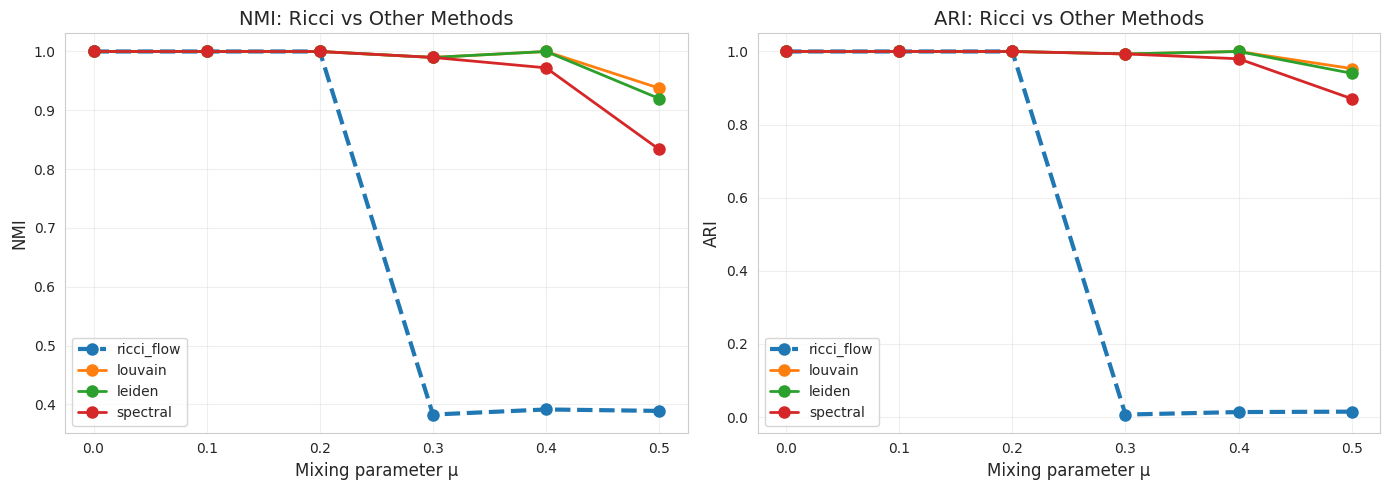


✅ M3 COMPLETE!

Generated files:
  - results/karate_ollivier_hist.png
  - results/karate_forman_hist.png
  - results/karate_graph_curvature.png
  - results/curvature_separation.png
  - results/ricci_flow_evolution.png
  - results/karate_cut_scan.png
  - results/karate_surgery.png
  - results/ricci_vs_others.csv
  - results/ricci_phase_transition.csv/png
  - results/ricci_scalability.csv/png


In [ ]:
"""
M3 Experiments: Ricci Curvature & Flow using GraphRicciCurvature library
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

# GraphRicciCurvature imports
from GraphRicciCurvature.OllivierRicci import OllivierRicci
from GraphRicciCurvature.FormanRicci import FormanRicci

import networkx as nx
from sklearn.metrics import adjusted_rand_score


Path("results").mkdir(exist_ok=True)


def experiment_1_curvature_basics():
    """Understand curvature on Karate Club (following tutorial)."""
    print("\n" + "="*60)
    print("Experiment 1: Curvature Basics on Karate Club")
    print("="*60)

    G, gt = load_karate_club()
    print(f"Graph: {graph_summary(G)}")

    # Ollivier-Ricci
    print("\n--- Ollivier-Ricci Curvature ---")
    G_orc, orc_curvs = compute_ollivier_ricci(G, alpha=0.5, verbose="INFO")

    print("\nFirst 5 edges:")
    for i, (u, v) in enumerate(list(G_orc.edges())[:5]):
        print(f"  Edge ({u},{v}): κ = {G_orc[u][v]['ricciCurvature']:.4f}")

    print(f"\nStatistics: {curvature_statistics(orc_curvs)}")

    plot_curvature_histogram(
        G_orc,
        curvature_attr='ricciCurvature',
        title="Karate Club - Ollivier-Ricci",
        save_path="results/karate_ollivier_hist.png"
    )

    # Forman-Ricci
    print("\n--- Forman-Ricci Curvature ---")
    G_frc, frc_curvs = compute_forman_ricci(G, verbose="INFO")

    print("\nFirst 5 edges:")
    for i, (u, v) in enumerate(list(G_frc.edges())[:5]):
        print(f"  Edge ({u},{v}): κ = {G_frc[u][v]['formanCurvature']:.4f}")

    print(f"\nStatistics: {curvature_statistics(frc_curvs)}")

    plot_curvature_histogram(
        G_frc,
        curvature_attr='formanCurvature',
        title="Karate Club - Forman-Ricci",
        save_path="results/karate_forman_hist.png"
    )

    # Visualize on graph
    plot_graph_with_curvature(
        G_orc,
        curvature_attr='ricciCurvature',
        clustering_label='club',
        title="Karate Club - Ollivier Curvature",
        save_path="results/karate_graph_curvature.png"
    )

    return G_orc, G_frc


def experiment_2_curvature_separation():
    """Test curvature separation between intra/inter community edges."""
    print("\n" + "="*60)
    print("Experiment 2: Curvature Separation Analysis")
    print("="*60)

    # SBM with clear communities
    G, gt = generate_sbm([100]*4, p_in=0.3, p_out=0.02, seed=42)
    print(f"SBM: {graph_summary(G)}")

    results = compare_curvature_methods(G, ground_truth=gt)

    for method in ['ollivier', 'forman']:
        print(f"\n{method.upper()}:")
        print(f"  Mean curvature: {results[method]['stats']['mean']:.4f}")
        print(f"  Intra-community mean: {results[method]['intra_mean']:.4f}")
        print(f"  Inter-community mean: {results[method]['inter_mean']:.4f}")
        print(f"  Separation (intra - inter): {results[method]['separation']:.4f}")

    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for idx, method in enumerate(['ollivier', 'forman']):
        classified = classify_edges_by_curvature(G, results[method]['curvatures'], gt)

        axes[idx].hist(classified['intra_community'], bins=25, alpha=0.6,
                      label=f"Intra (n={len(classified['intra_community'])})",
                      color='green', density=True)
        axes[idx].hist(classified['inter_community'], bins=25, alpha=0.6,
                      label=f"Inter (n={len(classified['inter_community'])})",
                      color='red', density=True)
        axes[idx].axvline(x=0, color='black', linestyle='--', linewidth=1.5)
        axes[idx].set_xlabel('Curvature', fontsize=12)
        axes[idx].set_ylabel('Density', fontsize=12)
        axes[idx].set_title(f'{method.capitalize()} Curvature', fontsize=14)
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("results/curvature_separation.png", dpi=150)
    plt.show()

    return results


def experiment_3_ricci_flow():
    """Demonstrate Ricci flow evolution (following tutorial)."""
    print("\n" + "="*60)
    print("Experiment 3: Ricci Flow on Karate Club")
    print("="*60)

    G, gt = load_karate_club()

    # Clean graph
    for u, v in G.edges():
        G[u][v].clear()

    # Initial curvature
    print("Computing initial curvature...")
    orc = OllivierRicci(G.copy(), alpha=0.5, verbose="INFO")
    orc.compute_ricci_curvature()
    G_initial = orc.G.copy()

    initial_curvs = [G_initial[u][v]['ricciCurvature'] for u, v in G_initial.edges()]
    print(f"Initial curvature range: [{min(initial_curvs):.4f}, {max(initial_curvs):.4f}]")

    # Run Ricci flow
    print("\nRunning Ricci flow (50 iterations)...")
    orc_flow = OllivierRicci(G.copy(), alpha=0.5, verbose="ERROR")
    orc_flow.compute_ricci_flow(iterations=50)
    G_flow = orc_flow.G.copy()

    final_curvs = [G_flow[u][v]['ricciCurvature'] for u, v in G_flow.edges()]
    final_weights = [G_flow[u][v]['weight'] for u, v in G_flow.edges()]

    print(f"Final curvature range: [{min(final_curvs):.4f}, {max(final_curvs):.4f}]")
    print(f"Final weight range: [{min(final_weights):.4f}, {max(final_weights):.4f}]")

    # Plot before/after
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Initial curvature
    axes[0, 0].hist(initial_curvs, bins=20, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0, 0].axvline(x=0, color='red', linestyle='--')
    axes[0, 0].set_title('Initial Curvature Distribution', fontsize=14)
    axes[0, 0].set_xlabel('Curvature')

    # Final curvature
    axes[0, 1].hist(final_curvs, bins=20, alpha=0.7, color='orange', edgecolor='black')
    axes[0, 1].axvline(x=0, color='red', linestyle='--')
    axes[0, 1].set_title('Final Curvature (after flow)', fontsize=14)
    axes[0, 1].set_xlabel('Curvature')

    # Initial weights (all 1)
    axes[1, 0].hist([1]*len(initial_curvs), bins=20, alpha=0.7, color='steelblue', edgecolor='black')
    axes[1, 0].set_title('Initial Weights', fontsize=14)
    axes[1, 0].set_xlabel('Weight')

    # Final weights
    axes[1, 1].hist(final_weights, bins=20, alpha=0.7, color='orange', edgecolor='black')
    axes[1, 1].set_title('Final Weights (after flow)', fontsize=14)
    axes[1, 1].set_xlabel('Weight')

    plt.tight_layout()
    plt.savefig("results/ricci_flow_evolution.png", dpi=150)
    plt.show()

    return G_initial, G_flow


def experiment_4_surgery_and_detection():
    """Community detection via surgery (following tutorial)."""
    print("\n" + "="*60)
    print("Experiment 4: Community Detection via Surgery")
    print("="*60)

    G, gt = load_karate_club()

    # Run Ricci flow
    print("Running Ricci flow...")
    for u, v in G.edges():
        G[u][v].clear()

    orc = OllivierRicci(G.copy(), alpha=0.5, verbose="ERROR")
    orc.compute_ricci_flow(iterations=50)
    G_rf = orc.G.copy()

    # Scan cut points
    print("\nScanning cut points...")
    fig, best_cut = plot_cut_scan(
        G_rf,
        ground_truth=gt,
        clustering_label='club',
        title="Karate Club - Cut Point Scan",
        save_path="results/karate_cut_scan.png"
    )

    # Perform surgery at best cut
    print(f"\nPerforming surgery at cut={best_cut:.3f}...")
    G_cut, removed = surgery(G_rf, cut=best_cut)

    print(f"Removed {len(removed)} edges")
    print(f"Remaining edges: {G_cut.number_of_edges()}")

    # Get communities
    cc = list(nx.connected_components(G_cut))
    partition = {node: idx for idx, comp in enumerate(cc) for node in comp}

    print(f"Communities found: {len(cc)}")
    print(f"NMI: {compute_nmi(partition, gt):.4f}")
    print(f"ARI: {compute_ari(partition, gt):.4f}")

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    pos = nx.spring_layout(G, seed=42)

    # Before surgery
    node_colors = [gt[n] for n in G.nodes()]
    nx.draw(G_rf, pos, node_color=node_colors, cmap=plt.cm.tab10,
            node_size=200, ax=axes[0], with_labels=True, font_size=8)
    axes[0].set_title('Before Surgery', fontsize=14)

    # After surgery
    nx.draw(G_cut, pos, node_color=node_colors, cmap=plt.cm.tab10,
            node_size=200, ax=axes[1], with_labels=True, font_size=8)
    axes[1].set_title(f'After Surgery (cut={best_cut:.2f})', fontsize=14)

    plt.tight_layout()
    plt.savefig("results/karate_surgery.png", dpi=150)
    plt.show()

    return partition


def experiment_5_ricci_vs_others():
    """Compare Ricci detection with other methods."""
    print("\n" + "="*60)
    print("Experiment 5: Ricci vs Other Methods")
    print("="*60)

    G, gt = generate_sbm([100]*4, p_in=0.3, p_out=0.02, seed=42)
    print(f"SBM: {graph_summary(G)}")

    # Run all methods
    print("\nRunning community detection methods...")
    partitions = run_all_detectors(G, seed=42)

    print("Running Spectral...")
    partitions['spectral'] = run_spectral(G, seed=42)

    print("Running Ricci Flow...")
    partitions['ricci_flow'] = run_ricci(G, alpha=0.5, iterations=30)

    # Compare
    results = compare_partitions(G, partitions, gt)
    print("\nResults:")
    print(results.to_string())
    results.to_csv("results/ricci_vs_others.csv")

    return results


def experiment_6_phase_transition():
    """Study Ricci detection across mixing parameters."""
    print("\n" + "="*60)
    print("Experiment 6: Phase Transition Study")
    print("="*60)

    mu_values = np.linspace(0.0, 0.5, 6)
    records = []

    for mu in mu_values:
        print(f"\n  μ = {mu:.2f}")
        G, gt = generate_sbm([100]*4, p_in=0.3, p_out=mu*0.3+0.001, seed=42)

        # Ricci Flow
        t0 = time.time()
        partition_ricci = run_ricci(G, alpha=0.5, iterations=30)
        time_ricci = time.time() - t0

        # Louvain
        partitions = run_all_detectors(G, seed=42)
        partition_louvain = partitions['louvain']

        # Leiden
        partition_leiden = partitions['leiden']

        # Spectral
        partition_spectral = run_spectral(G, seed=42)

        for name, partition in [('ricci_flow', partition_ricci),
                                 ('louvain', partition_louvain),
                                 ('leiden', partition_leiden),
                                 ('spectral', partition_spectral)]:
            records.append({
                'mu': mu,
                'algorithm': name,
                'nmi': compute_nmi(partition, gt),
                'ari': compute_ari(partition, gt),
                'n_communities': len(set(partition.values()))
            })

    df = pd.DataFrame(records)
    df.to_csv("results/ricci_phase_transition.csv", index=False)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for algo in df['algorithm'].unique():
        subset = df[df['algorithm'] == algo]
        style = '--' if 'ricci' in algo else '-'
        lw = 3 if 'ricci' in algo else 2
        axes[0].plot(subset['mu'], subset['nmi'], f'o{style}',
                    label=algo, linewidth=lw, markersize=8)
        axes[1].plot(subset['mu'], subset['ari'], f'o{style}',
                    label=algo, linewidth=lw, markersize=8)

    for ax, metric in zip(axes, ['NMI', 'ARI']):
        ax.set_xlabel('Mixing parameter μ', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.set_title(f'{metric}: Ricci vs Other Methods', fontsize=14)
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("results/ricci_phase_transition.png", dpi=150)
    plt.show()

    return df



if __name__ == "__main__":
    print("M3 Experiments: Ricci Curvature using GraphRicciCurvature")
    print("="*60)

    experiment_1_curvature_basics()
    experiment_2_curvature_separation()
    experiment_3_ricci_flow()
    experiment_4_surgery_and_detection()
    experiment_5_ricci_vs_others()
    experiment_6_phase_transition()


    print("\n" + "="*60)
    print("✅ M3 COMPLETE!")
    print("="*60)
    print("\nGenerated files:")
    print("  - results/karate_ollivier_hist.png")
    print("  - results/karate_forman_hist.png")
    print("  - results/karate_graph_curvature.png")
    print("  - results/curvature_separation.png")
    print("  - results/ricci_flow_evolution.png")
    print("  - results/karate_cut_scan.png")
    print("  - results/karate_surgery.png")
    print("  - results/ricci_vs_others.csv")
    print("  - results/ricci_phase_transition.csv/png")
    print("  - results/ricci_scalability.csv/png")


Experiment 7: Scalability Analysis

  n = 200 nodes
    Edges: 870
    Forman time: 0.025s
    Ollivier time: 0.383s
    Detection time: 10.302s
    NMI: 0.426

  n = 400 nodes
    Edges: 3624
    Forman time: 0.143s
    Ollivier time: 1.310s
    Detection time: 32.555s
    NMI: 0.985

  n = 800 nodes
    Edges: 14486
    Forman time: 1.532s
    Ollivier: skipped
    Detection time: 180.963s
    NMI: 1.000

  n = 2000 nodes
    Edges: 90094
    Forman time: 15.403s
    Ollivier: skipped
    Detection time: 3380.239s
    NMI: 1.000


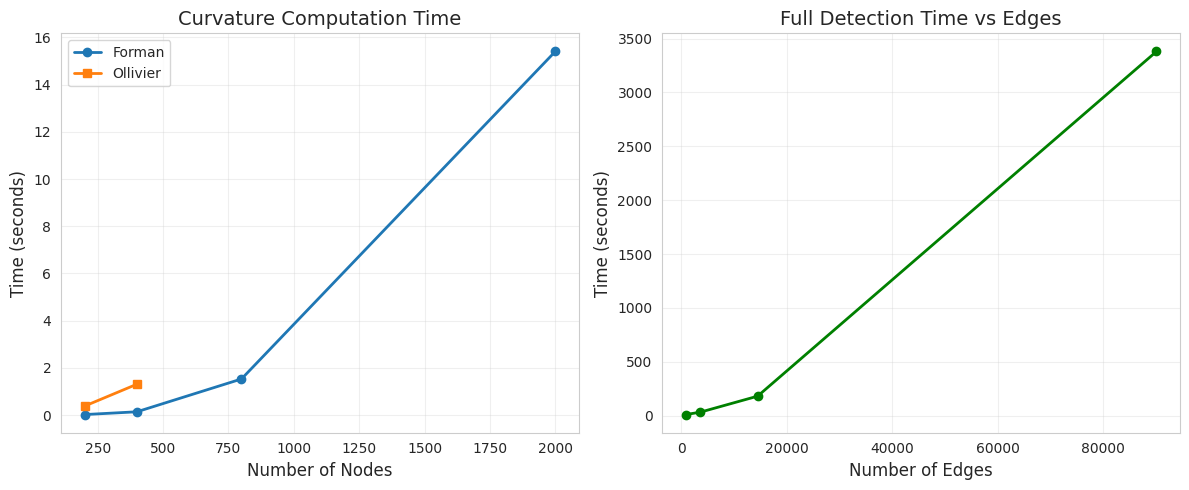

nodes  edges  time_forman  time_ollivier  time_detection       nmi
0    200    870     0.024871       0.383444       10.302048  0.425693
1    400   3624     0.142590       1.309715       32.554654  0.985086
2    800  14486     1.532125            NaN      180.962952  1.000000
3   2000  90094    15.403044            NaN     3380.238786  1.000000

In [ ]:

def experiment_7_scalability():
    """Test computational efficiency."""
    print("\n" + "="*60)
    print("Experiment 7: Scalability Analysis")
    print("="*60)

    sizes = [50, 100, 200, 500]
    records = []

    for n_per_block in sizes:
        n = n_per_block * 4
        print(f"\n  n = {n} nodes")

        G, gt = generate_sbm([n_per_block]*4, p_in=0.15, p_out=0.01, seed=42)
        m = G.number_of_edges()

        # Clean graph
        for u, v in G.edges():
            G[u][v].clear()

        # Time Forman curvature
        t0 = time.time()
        frc = FormanRicci(G.copy(), verbose="ERROR")
        frc.compute_ricci_curvature()
        time_forman = time.time() - t0

        # Time Ollivier curvature (skip for large graphs)
        if n <= 500:
            t0 = time.time()
            orc = OllivierRicci(G.copy(), alpha=0.5, verbose="ERROR")
            orc.compute_ricci_curvature()
            time_ollivier = time.time() - t0
        else:
            time_ollivier = np.nan

        # Time full Ricci flow detection
        t0 = time.time()
        partition = run_ricci(G, alpha=0.5, iterations=20)
        time_detection = time.time() - t0

        nmi = compute_nmi(partition, gt)

        records.append({
            'nodes': n,
            'edges': m,
            'time_forman': time_forman,
            'time_ollivier': time_ollivier,
            'time_detection': time_detection,
            'nmi': nmi
        })

        print(f"    Edges: {m}")
        print(f"    Forman time: {time_forman:.3f}s")
        print(f"    Ollivier time: {time_ollivier:.3f}s" if not np.isnan(time_ollivier) else "    Ollivier: skipped")
        print(f"    Detection time: {time_detection:.3f}s")
        print(f"    NMI: {nmi:.3f}")

    df = pd.DataFrame(records)
    df.to_csv("results/ricci_scalability.csv", index=False)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].plot(df['nodes'], df['time_forman'], 'o-', label='Forman', linewidth=2)
    axes[0].plot(df['nodes'], df['time_ollivier'], 's-', label='Ollivier', linewidth=2)
    axes[0].set_xlabel('Number of Nodes', fontsize=12)
    axes[0].set_ylabel('Time (seconds)', fontsize=12)
    axes[0].set_title('Curvature Computation Time', fontsize=14)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(df['edges'], df['time_detection'], 'o-', linewidth=2, color='green')
    axes[1].set_xlabel('Number of Edges', fontsize=12)
    axes[1].set_ylabel('Time (seconds)', fontsize=12)
    axes[1].set_title('Full Detection Time vs Edges', fontsize=14)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("results/ricci_scalability.png", dpi=150)
    plt.show()

    return df
experiment_7_scalability()

#robutsness

In [ ]:
"""
Robustness testing for community detection algorithms.
- Seed sensitivity analysis
- Edge perturbation tests
- Hyperparameter ablation
"""
import numpy as np
import networkx as nx
from typing import Dict, List, Tuple, Callable, Optional
from collections import defaultdict
import warnings
from tqdm import tqdm



# =============================================================================
# SEED SENSITIVITY ANALYSIS
# =============================================================================

def seed_sweep(G: nx.Graph,
               detector_fn: Callable,
               ground_truth: Dict[int, int] = None,
               n_seeds: int = 20,
               seed_start: int = 0,
               **detector_kwargs) -> Dict[str, any]:
    """
    Run detector with multiple random seeds to assess stability.

    Args:
        G: Input graph
        detector_fn: Community detection function (G, seed=...) -> partition
        ground_truth: Ground truth partition (optional)
        n_seeds: Number of different seeds to try
        seed_start: Starting seed value
        **detector_kwargs: Additional arguments for detector

    Returns:
        Dictionary with stability metrics
    """
    partitions = []
    nmis = []
    aris = []
    modularities = []
    n_communities = []

    for seed in range(seed_start, seed_start + n_seeds):
        try:
            partition = detector_fn(G, seed=seed, **detector_kwargs)
            partitions.append(partition)

            modularities.append(compute_modularity(G, partition))
            n_communities.append(len(set(partition.values())))

            if ground_truth is not None:
                nmis.append(compute_nmi(partition, ground_truth))
                aris.append(compute_ari(partition, ground_truth))
        except Exception as e:
            warnings.warn(f"Seed {seed} failed: {e}")
            continue

    if len(partitions) < 2:
        return {'error': 'Not enough successful runs'}

    # Compute pairwise NMI between runs (partition stability)
    pairwise_nmis = []
    for i in range(len(partitions)):
        for j in range(i + 1, len(partitions)):
            pairwise_nmis.append(compute_nmi(partitions[i], partitions[j]))

    results = {
        'n_runs': len(partitions),
        'modularity_mean': np.mean(modularities),
        'modularity_std': np.std(modularities),
        'n_communities_mean': np.mean(n_communities),
        'n_communities_std': np.std(n_communities),
        'partition_stability': np.mean(pairwise_nmis),  # Avg pairwise NMI
        'partition_stability_std': np.std(pairwise_nmis),
    }

    if ground_truth is not None:
        results.update({
            'nmi_mean': np.mean(nmis),
            'nmi_std': np.std(nmis),
            'ari_mean': np.mean(aris),
            'ari_std': np.std(aris),
        })

    return results


def compare_seed_sensitivity(G: nx.Graph,
                              detectors: Dict[str, Callable],
                              ground_truth: Dict[int, int] = None,
                              n_seeds: int = 20) -> Dict[str, Dict]:
    """
    Compare seed sensitivity across multiple detectors.
    """
    results = {}

    for name, detector_fn in detectors.items():
        print(f"  Testing {name}...")
        results[name] = seed_sweep(G, detector_fn, ground_truth, n_seeds)

    return results


# =============================================================================
# EDGE PERTURBATION TESTS
# =============================================================================

def perturb_edges(G: nx.Graph,
                  fraction: float,
                  mode: str = 'remove',
                  seed: int = None) -> nx.Graph:
    """
    Perturb graph by adding or removing edges.

    Args:
        G: Input graph
        fraction: Fraction of edges to perturb (0 to 1)
        mode: 'remove', 'add', or 'rewire'
        seed: Random seed

    Returns:
        Perturbed graph
    """
    if seed is not None:
        np.random.seed(seed)

    G_perturbed = G.copy()
    n_edges = G.number_of_edges()
    n_perturb = int(n_edges * fraction)

    if mode == 'remove':
        edges = list(G_perturbed.edges())
        remove_idx = np.random.choice(len(edges), size=min(n_perturb, len(edges)), replace=False)
        edges_to_remove = [edges[i] for i in remove_idx]
        G_perturbed.remove_edges_from(edges_to_remove)

    elif mode == 'add':
        nodes = list(G_perturbed.nodes())
        added = 0
        attempts = 0
        max_attempts = n_perturb * 10

        while added < n_perturb and attempts < max_attempts:
            u, v = np.random.choice(nodes, size=2, replace=False)
            if not G_perturbed.has_edge(u, v):
                G_perturbed.add_edge(u, v)
                added += 1
            attempts += 1

    elif mode == 'rewire':
        # Remove and add equal number of edges
        edges = list(G_perturbed.edges())
        n_rewire = min(n_perturb, len(edges))

        # Remove random edges
        remove_idx = np.random.choice(len(edges), size=n_rewire, replace=False)
        edges_to_remove = [edges[i] for i in remove_idx]
        G_perturbed.remove_edges_from(edges_to_remove)

        # Add random edges
        nodes = list(G_perturbed.nodes())
        added = 0
        attempts = 0
        max_attempts = n_rewire * 10

        while added < n_rewire and attempts < max_attempts:
            u, v = np.random.choice(nodes, size=2, replace=False)
            if not G_perturbed.has_edge(u, v):
                G_perturbed.add_edge(u, v)
                added += 1
            attempts += 1

    return G_perturbed


def perturbation_sweep(G: nx.Graph,
                       detector_fn: Callable,
                       ground_truth: Dict[int, int] = None,
                       fractions: List[float] = None,
                       mode: str = 'remove',
                       n_trials: int = 5,
                       seed: int = 42,
                       **detector_kwargs) -> List[Dict]:
    """
    Test detector robustness across perturbation levels.

    Args:
        G: Input graph
        detector_fn: Community detection function
        ground_truth: Ground truth partition
        fractions: List of perturbation fractions to test
        mode: Perturbation mode ('remove', 'add', 'rewire')
        n_trials: Number of trials per fraction level
        seed: Base random seed

    Returns:
        List of results per fraction level
    """
    if fractions is None:
        fractions = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

    results = []

    # Get baseline partition (unperturbed)
    baseline_partition = detector_fn(G, seed=seed, **detector_kwargs)

    for frac in fractions:
        trial_results = {
            'fraction': frac,
            'nmis': [],
            'aris': [],
            'modularities': [],
            'vi_from_baseline': [],  # Variation of Information from baseline
            'n_communities': []
        }

        for trial in range(n_trials):
            trial_seed = seed + trial * 1000

            if frac == 0:
                G_pert = G
            else:
                G_pert = perturb_edges(G, frac, mode=mode, seed=trial_seed)

            try:
                partition = detector_fn(G_pert, seed=trial_seed, **detector_kwargs)

                trial_results['modularities'].append(compute_modularity(G_pert, partition))
                trial_results['n_communities'].append(len(set(partition.values())))

                # Compare to baseline
                common_nodes = set(partition.keys()) & set(baseline_partition.keys())
                if len(common_nodes) > 0:
                    p1 = {n: partition[n] for n in common_nodes}
                    p2 = {n: baseline_partition[n] for n in common_nodes}
                    trial_results['vi_from_baseline'].append(1 - compute_nmi(p1, p2))

                if ground_truth is not None:
                    trial_results['nmis'].append(compute_nmi(partition, ground_truth))
                    trial_results['aris'].append(compute_ari(partition, ground_truth))

            except Exception as e:
                warnings.warn(f"Trial failed at fraction {frac}: {e}")
                continue

        # Aggregate trial results
        results.append({
            'fraction': frac,
            'nmi_mean': np.mean(trial_results['nmis']) if trial_results['nmis'] else np.nan,
            'nmi_std': np.std(trial_results['nmis']) if trial_results['nmis'] else np.nan,
            'ari_mean': np.mean(trial_results['aris']) if trial_results['aris'] else np.nan,
            'ari_std': np.std(trial_results['aris']) if trial_results['aris'] else np.nan,
            'modularity_mean': np.mean(trial_results['modularities']),
            'modularity_std': np.std(trial_results['modularities']),
            'vi_mean': np.mean(trial_results['vi_from_baseline']) if trial_results['vi_from_baseline'] else np.nan,
            'vi_std': np.std(trial_results['vi_from_baseline']) if trial_results['vi_from_baseline'] else np.nan,
            'n_communities_mean': np.mean(trial_results['n_communities']),
        })

    return results


# =============================================================================
# VARIATION OF INFORMATION
# =============================================================================

def variation_of_information(partition1: Dict[int, int],
                              partition2: Dict[int, int]) -> float:
    """
    Compute Variation of Information between two partitions.
    VI(P, Q) = H(P) + H(Q) - 2*I(P, Q)

    Lower is better (0 = identical partitions).
    """
    from collections import Counter
    import math

    common_nodes = set(partition1.keys()) & set(partition2.keys())
    n = len(common_nodes)

    if n == 0:
        return float('inf')

    # Count cluster sizes
    c1 = Counter(partition1[node] for node in common_nodes)
    c2 = Counter(partition2[node] for node in common_nodes)

    # Count joint occurrences
    joint = Counter((partition1[node], partition2[node]) for node in common_nodes)

    # Compute entropies
    def entropy(counts):
        total = sum(counts.values())
        return -sum((c/total) * math.log(c/total) for c in counts.values() if c > 0)

    h1 = entropy(c1)
    h2 = entropy(c2)

    # Mutual information
    mi = 0
    for (i, j), nij in joint.items():
        if nij > 0:
            pi = c1[i] / n
            pj = c2[j] / n
            pij = nij / n
            mi += pij * math.log(pij / (pi * pj))

    vi = h1 + h2 - 2 * mi
    return vi

#Scalability

In [ ]:
"""
Scalability and performance profiling for community detection.
- Runtime benchmarking
- Memory profiling
- Scaling analysis
"""
import numpy as np
import networkx as nx
from typing import Dict, List, Tuple, Callable, Optional
import time
import tracemalloc
import gc
from dataclasses import dataclass


@dataclass
class BenchmarkResult:
    """Container for benchmark results."""
    algorithm: str
    n_nodes: int
    n_edges: int
    runtime_seconds: float
    peak_memory_mb: float
    n_communities: int
    modularity: float
    nmi: float = None
    ari: float = None


def benchmark_single(G: nx.Graph,
                     detector_fn: Callable,
                     ground_truth: Dict[int, int] = None,
                     algorithm_name: str = "unknown",
                     seed: int = 42,
                     **detector_kwargs) -> BenchmarkResult:
    """
    Benchmark a single detector run with timing and memory profiling.
    """

    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()

    # Force garbage collection
    gc.collect()

    # Start memory tracking
    tracemalloc.start()

    # Time the execution
    start_time = time.perf_counter()

    try:
        partition = detector_fn(G, seed=seed, **detector_kwargs)
    except Exception as e:
        tracemalloc.stop()
        raise e

    end_time = time.perf_counter()

    # Get memory stats
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    runtime = end_time - start_time
    peak_memory_mb = peak / (1024 * 1024)

    # Compute quality metrics
    n_communities = len(set(partition.values()))
    modularity = compute_modularity(G, partition)

    nmi = compute_nmi(partition, ground_truth) if ground_truth else None
    ari = compute_ari(partition, ground_truth) if ground_truth else None

    return BenchmarkResult(
        algorithm=algorithm_name,
        n_nodes=n_nodes,
        n_edges=n_edges,
        runtime_seconds=runtime,
        peak_memory_mb=peak_memory_mb,
        n_communities=n_communities,
        modularity=modularity,
        nmi=nmi,
        ari=ari
    )


def scaling_analysis(detectors: Dict[str, Callable],
                     sizes: List[int] = None,
                     n_communities: int = 4,
                     p_in: float = 0.2,
                     p_out: float = 0.01,
                     n_trials: int = 3,
                     seed: int = 42,
                     verbose: bool = True) -> List[BenchmarkResult]:
    """
    Analyze how algorithms scale with graph size.

    Args:
        detectors: Dict of algorithm name -> detector function
        sizes: List of nodes per community to test
        n_communities: Number of communities in generated graphs
        p_in, p_out: SBM edge probabilities
        n_trials: Number of trials per size
        seed: Random seed
        verbose: Print progress

    Returns:
        List of BenchmarkResult objects
    """
    if sizes is None:
        sizes = [25, 50, 100, 200, 500, 1000]

    results = []

    for n_per_comm in sizes:
        n_total = n_per_comm * n_communities

        if verbose:
            print(f"\n  Testing n = {n_total} nodes...")

        for trial in range(n_trials):
            trial_seed = seed + trial * 1000

            # Generate graph
            G, gt = generate_sbm(
                sizes=[n_per_comm] * n_communities,
                p_in=p_in,
                p_out=p_out,
                seed=trial_seed
            )

            for algo_name, detector_fn in detectors.items():
                if verbose:
                    print(f"    {algo_name} (trial {trial + 1})...", end=" ")

                try:
                    result = benchmark_single(
                        G, detector_fn, gt,
                        algorithm_name=algo_name,
                        seed=trial_seed
                    )
                    results.append(result)

                    if verbose:
                        print(f"time={result.runtime_seconds:.3f}s, "
                              f"mem={result.peak_memory_mb:.1f}MB")

                except Exception as e:
                    if verbose:
                        print(f"FAILED: {e}")
                    continue

    return results


def edge_scaling_analysis(detectors: Dict[str, Callable],
                          n_nodes: int = 1000,
                          densities: List[float] = None,
                          n_communities: int = 4,
                          n_trials: int = 3,
                          seed: int = 42,
                          verbose: bool = True) -> List[BenchmarkResult]:
    """
    Analyze how algorithms scale with edge density (fixed nodes).
    """
    if densities is None:
        densities = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]

    results = []
    n_per_comm = n_nodes // n_communities

    for density in densities:
        # Compute p_in and p_out to achieve target density
        # For SBM: density ≈ (k * n_per_comm * p_in + k*(k-1) * n_per_comm * p_out) / (n * (n-1) / 2)
        # Simplified: set p_in = density * 3, p_out = density * 0.3
        p_in = min(density * 5, 0.9)
        p_out = min(density * 0.5, p_in * 0.3)

        if verbose:
            print(f"\n  Testing density ≈ {density:.2f} (p_in={p_in:.3f}, p_out={p_out:.3f})...")

        for trial in range(n_trials):
            trial_seed = seed + trial * 1000

            G, gt = generate_sbm(
                sizes=[n_per_comm] * n_communities,
                p_in=p_in,
                p_out=p_out,
                seed=trial_seed
            )

            actual_density = nx.density(G)

            for algo_name, detector_fn in detectors.items():
                if verbose:
                    print(f"    {algo_name}...", end=" ")

                try:
                    result = benchmark_single(
                        G, detector_fn, gt,
                        algorithm_name=algo_name,
                        seed=trial_seed
                    )
                    results.append(result)

                    if verbose:
                        print(f"edges={result.n_edges}, time={result.runtime_seconds:.3f}s")

                except Exception as e:
                    if verbose:
                        print(f"FAILED: {e}")

    return results


def results_to_dataframe(results: List[BenchmarkResult]):
    """Convert benchmark results to pandas DataFrame."""
    import pandas as pd

    data = []
    for r in results:
        data.append({
            'algorithm': r.algorithm,
            'n_nodes': r.n_nodes,
            'n_edges': r.n_edges,
            'runtime_seconds': r.runtime_seconds,
            'peak_memory_mb': r.peak_memory_mb,
            'n_communities': r.n_communities,
            'modularity': r.modularity,
            'nmi': r.nmi,
            'ari': r.ari
        })

    return pd.DataFrame(data)

#Hyperparameter Ablation

In [ ]:
"""
Hyperparameter ablation studies for community detection algorithms.
"""
import numpy as np
import networkx as nx
from typing import Dict, List, Tuple, Callable, Optional
import pandas as pd
from itertools import product



def resolution_ablation(G: nx.Graph,
                        detector_fn: Callable,
                        ground_truth: Dict[int, int] = None,
                        resolutions: List[float] = None,
                        n_seeds: int = 5,
                        seed_start: int = 42) -> pd.DataFrame:
    """
    Ablation study on resolution parameter (for Louvain/Leiden).

    Args:
        G: Input graph
        detector_fn: Detector function accepting 'resolution' parameter
        ground_truth: Ground truth partition
        resolutions: List of resolution values to test
        n_seeds: Number of seeds per resolution
        seed_start: Starting seed

    Returns:
        DataFrame with results
    """
    if resolutions is None:
        resolutions = [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 3.0, 5.0]

    records = []

    for resolution in resolutions:
        for seed in range(seed_start, seed_start + n_seeds):
            try:
                partition = detector_fn(G, resolution=resolution, seed=seed)

                record = {
                    'resolution': resolution,
                    'seed': seed,
                    'n_communities': len(set(partition.values())),
                    'modularity': compute_modularity(G, partition, resolution=resolution),
                }

                if ground_truth:
                    record['nmi'] = compute_nmi(partition, ground_truth)
                    record['ari'] = compute_ari(partition, ground_truth)

                records.append(record)

            except Exception as e:
                print(f"Failed at resolution={resolution}, seed={seed}: {e}")

    return pd.DataFrame(records)


def spectral_k_ablation(G: nx.Graph,
                        ground_truth: Dict[int, int] = None,
                        k_values: List[int] = None,
                        normalizations: List[str] = None,
                        n_seeds: int = 5,
                        seed_start: int = 42) -> pd.DataFrame:
    """
    Ablation study on spectral clustering parameters (k and normalization).
    """

    if k_values is None:
        k_values = list(range(2, 12))

    if normalizations is None:
        normalizations = ['unnormalized', 'symmetric', 'random_walk']

    records = []

    for k in k_values:
        for norm in normalizations:
            for seed in range(seed_start, seed_start + n_seeds):
                try:
                    partition, info = spectral_clustering(
                        G, k=k, normalized=norm, seed=seed
                    )

                    record = {
                        'k': k,
                        'normalization': norm,
                        'seed': seed,
                        'n_communities': len(set(partition.values())),
                        'modularity': compute_modularity(G, partition),
                    }

                    if ground_truth:
                        record['nmi'] = compute_nmi(partition, ground_truth)
                        record['ari'] = compute_ari(partition, ground_truth)

                    records.append(record)

                except Exception as e:
                    continue

    return pd.DataFrame(records)


def ricci_ablation(G: nx.Graph,
                   ground_truth: Dict[int, int] = None,
                   alphas: List[float] = None,
                   iterations_list: List[int] = None,
                   n_seeds: int = 3,
                   seed_start: int = 42) -> pd.DataFrame:
    """
    Ablation study on Ricci flow parameters (alpha and iterations).
    """

    if alphas is None:
        alphas = [0.0, 0.25, 0.5, 0.75, 0.99]

    if iterations_list is None:
        iterations_list = [10, 20, 30, 50, 75, 100]

    records = []

    for alpha in alphas:
        for iterations in iterations_list:
            for seed in range(seed_start, seed_start + n_seeds):
                try:
                    partition = run_ricci(
                        G, alpha=alpha, iterations=iterations, seed=seed
                    )

                    record = {
                        'alpha': alpha,
                        'iterations': iterations,
                        'seed': seed,
                        'n_communities': len(set(partition.values())),
                        'modularity': compute_modularity(G, partition),
                    }

                    if ground_truth:
                        record['nmi'] = compute_nmi(partition, ground_truth)
                        record['ari'] = compute_ari(partition, ground_truth)

                    records.append(record)

                except Exception as e:
                    continue

    return pd.DataFrame(records)


def infomap_ablation(G: nx.Graph,
                     ground_truth: Dict[int, int] = None,
                     num_trials_list: List[int] = None,
                     n_seeds: int = 5,
                     seed_start: int = 42) -> pd.DataFrame:
    """
    Ablation study on Infomap parameters.
    """

    if num_trials_list is None:
        num_trials_list = [1, 5, 10, 20, 50]

    records = []

    for num_trials in num_trials_list:
        for seed in range(seed_start, seed_start + n_seeds):
            try:
                partition = run_infomap(G, seed=seed, num_trials=num_trials)

                record = {
                    'num_trials': num_trials,
                    'seed': seed,
                    'n_communities': len(set(partition.values())),
                    'modularity': compute_modularity(G, partition),
                }

                if ground_truth:
                    record['nmi'] = compute_nmi(partition, ground_truth)
                    record['ari'] = compute_ari(partition, ground_truth)

                records.append(record)

            except Exception as e:
                continue

    return pd.DataFrame(records)


def full_ablation_study(G: nx.Graph,
                        ground_truth: Dict[int, int] = None,
                        seed: int = 42) -> Dict[str, pd.DataFrame]:
    """
    Run full ablation study on all algorithms.
    """

    results = {}

    print("  Resolution ablation (Louvain)...")
    results['louvain_resolution'] = resolution_ablation(
        G, run_louvain, ground_truth, seed_start=seed
    )

    print("  Resolution ablation (Leiden)...")
    results['leiden_resolution'] = resolution_ablation(
        G, run_leiden, ground_truth, seed_start=seed
    )

    print("  Spectral k ablation...")
    results['spectral_k'] = spectral_k_ablation(
        G, ground_truth, seed_start=seed
    )

    print("  Ricci ablation...")
    results['ricci'] = ricci_ablation(
        G, ground_truth, seed_start=seed
    )

    print("  Infomap ablation...")
    results['infomap'] = infomap_ablation(
        G, ground_truth, seed_start=seed
    )

    return results

#Visualization

In [ ]:
"""
Visualization utilities for robustness and scalability analysis.
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, List, Optional
import seaborn as sns


def plot_seed_sensitivity(results: Dict[str, Dict],
                          metric: str = 'nmi',
                          title: str = "Seed Sensitivity Analysis",
                          save_path: str = None):
    """
    Plot seed sensitivity comparison across algorithms.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    algorithms = list(results.keys())

    # Plot 1: Mean performance with error bars
    means = [results[algo].get(f'{metric}_mean', np.nan) for algo in algorithms]
    stds = [results[algo].get(f'{metric}_std', 0) for algo in algorithms]

    colors = plt.cm.tab10(np.linspace(0, 1, len(algorithms)))

    axes[0].bar(algorithms, means, yerr=stds, capsize=5, color=colors, alpha=0.7)
    axes[0].set_ylabel(f'{metric.upper()} (mean ± std)', fontsize=12)
    axes[0].set_title(f'{metric.upper()} Across Seeds', fontsize=14)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3, axis='y')

    # Plot 2: Partition stability
    stability = [results[algo].get('partition_stability', np.nan) for algo in algorithms]
    stability_std = [results[algo].get('partition_stability_std', 0) for algo in algorithms]

    axes[1].bar(algorithms, stability, yerr=stability_std, capsize=5, color=colors, alpha=0.7)
    axes[1].set_ylabel('Partition Stability (pairwise NMI)', fontsize=12)
    axes[1].set_title('Consistency Across Seeds', fontsize=14)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].set_ylim(0, 1.05)
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()
    return fig


def plot_perturbation_robustness(results_dict: Dict[str, List[Dict]],
                                  metric: str = 'nmi',
                                  title: str = "Perturbation Robustness",
                                  save_path: str = None):
    """
    Plot how algorithms degrade under edge perturbation.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for algo_name, results in results_dict.items():
        fractions = [r['fraction'] for r in results]
        means = [r[f'{metric}_mean'] for r in results]
        stds = [r[f'{metric}_std'] for r in results]

        axes[0].errorbar(fractions, means, yerr=stds, marker='o',
                        label=algo_name, linewidth=2, markersize=6, capsize=3)

    axes[0].set_xlabel('Perturbation Fraction', fontsize=12)
    axes[0].set_ylabel(f'{metric.upper()}', fontsize=12)
    axes[0].set_title(f'{metric.upper()} vs Edge Perturbation', fontsize=14)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot VI from baseline
    for algo_name, results in results_dict.items():
        fractions = [r['fraction'] for r in results]
        vi_means = [r.get('vi_mean', np.nan) for r in results]
        vi_stds = [r.get('vi_std', 0) for r in results]

        axes[1].errorbar(fractions, vi_means, yerr=vi_stds, marker='s',
                        label=algo_name, linewidth=2, markersize=6, capsize=3)

    axes[1].set_xlabel('Perturbation Fraction', fontsize=12)
    axes[1].set_ylabel('Variation from Baseline (1 - NMI)', fontsize=12)
    axes[1].set_title('Partition Drift from Original', fontsize=14)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()
    return fig


def plot_scaling_analysis(df: pd.DataFrame,
                          x_col: str = 'n_nodes',
                          title: str = "Scaling Analysis",
                          save_path: str = None):
    """
    Plot runtime and memory scaling.
    """
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    # Aggregate by algorithm and size
    agg = df.groupby(['algorithm', x_col]).agg({
        'runtime_seconds': ['mean', 'std'],
        'peak_memory_mb': ['mean', 'std'],
        'nmi': 'mean'
    }).reset_index()

    agg.columns = ['algorithm', x_col, 'runtime_mean', 'runtime_std',
                   'memory_mean', 'memory_std', 'nmi_mean']

    algorithms = agg['algorithm'].unique()

    for algo in algorithms:
        subset = agg[agg['algorithm'] == algo]

        # Runtime
        axes[0].errorbar(subset[x_col], subset['runtime_mean'],
                        yerr=subset['runtime_std'], marker='o',
                        label=algo, linewidth=2, markersize=6, capsize=3)

        # Memory
        axes[1].errorbar(subset[x_col], subset['memory_mean'],
                        yerr=subset['memory_std'], marker='s',
                        label=algo, linewidth=2, markersize=6, capsize=3)

        # NMI
        axes[2].plot(subset[x_col], subset['nmi_mean'], 'o-',
                    label=algo, linewidth=2, markersize=6)

    axes[0].set_xlabel(x_col.replace('_', ' ').title(), fontsize=12)
    axes[0].set_ylabel('Runtime (seconds)', fontsize=12)
    axes[0].set_title('Runtime Scaling', fontsize=14)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_yscale('log')

    axes[1].set_xlabel(x_col.replace('_', ' ').title(), fontsize=12)
    axes[1].set_ylabel('Peak Memory (MB)', fontsize=12)
    axes[1].set_title('Memory Scaling', fontsize=14)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    axes[2].set_xlabel(x_col.replace('_', ' ').title(), fontsize=12)
    axes[2].set_ylabel('NMI', fontsize=12)
    axes[2].set_title('Quality vs Size', fontsize=14)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()
    return fig


def plot_resolution_ablation(df: pd.DataFrame,
                              title: str = "Resolution Parameter Ablation",
                              save_path: str = None):
    """
    Plot resolution parameter ablation results.
    """
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    # Aggregate
    agg = df.groupby('resolution').agg({
        'nmi': ['mean', 'std'],
        'n_communities': ['mean', 'std'],
        'modularity': ['mean', 'std']
    }).reset_index()

    agg.columns = ['resolution', 'nmi_mean', 'nmi_std', 'k_mean', 'k_std',
                   'mod_mean', 'mod_std']

    # NMI vs resolution
    axes[0].errorbar(agg['resolution'], agg['nmi_mean'], yerr=agg['nmi_std'],
                    marker='o', linewidth=2, markersize=8, capsize=4, color='steelblue')
    axes[0].set_xlabel('Resolution γ', fontsize=12)
    axes[0].set_ylabel('NMI', fontsize=12)
    axes[0].set_title('Accuracy vs Resolution', fontsize=14)
    axes[0].set_xscale('log')
    axes[0].grid(True, alpha=0.3)

    # Number of communities vs resolution
    axes[1].errorbar(agg['resolution'], agg['k_mean'], yerr=agg['k_std'],
                    marker='s', linewidth=2, markersize=8, capsize=4, color='orange')
    axes[1].set_xlabel('Resolution γ', fontsize=12)
    axes[1].set_ylabel('Number of Communities', fontsize=12)
    axes[1].set_title('Granularity vs Resolution', fontsize=14)
    axes[1].set_xscale('log')
    axes[1].grid(True, alpha=0.3)

    # Modularity vs resolution
    axes[2].errorbar(agg['resolution'], agg['mod_mean'], yerr=agg['mod_std'],
                    marker='^', linewidth=2, markersize=8, capsize=4, color='green')
    axes[2].set_xlabel('Resolution γ', fontsize=12)
    axes[2].set_ylabel('Modularity Q', fontsize=12)
    axes[2].set_title('Modularity vs Resolution', fontsize=14)
    axes[2].set_xscale('log')
    axes[2].grid(True, alpha=0.3)

    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()
    return fig


def plot_ricci_ablation(df: pd.DataFrame,
                        title: str = "Ricci Flow Ablation",
                        save_path: str = None):
    """
    Plot Ricci flow parameter ablation as heatmap.
    """
    # Pivot for heatmap
    pivot = df.groupby(['alpha', 'iterations'])['nmi'].mean().unstack()

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # NMI heatmap
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn',
                ax=axes[0], vmin=0, vmax=1)
    axes[0].set_xlabel('Iterations', fontsize=12)
    axes[0].set_ylabel('Alpha (α)', fontsize=12)
    axes[0].set_title('NMI by Parameters', fontsize=14)

    # Number of communities
    pivot_k = df.groupby(['alpha', 'iterations'])['n_communities'].mean().unstack()
    sns.heatmap(pivot_k, annot=True, fmt='.1f', cmap='viridis', ax=axes[1])
    axes[1].set_xlabel('Iterations', fontsize=12)
    axes[1].set_ylabel('Alpha (α)', fontsize=12)
    axes[1].set_title('Communities Found by Parameters', fontsize=14)

    plt.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')

    plt.show()
    return fig

#M4

M4: Robustness & Scalability Analysis

>>> Experiment 1: Seed Sensitivity

Experiment 1: Seed Sensitivity Analysis
Graph: {'nodes': 200, 'edges': 1863, 'density': 0.09361809045226131}
  Testing louvain...
  Testing leiden...
  Testing lpa...

--------------------------------------------------
Algorithm         NMI      Std  Stability
--------------------------------------------------
louvain        1.0000   0.0000     1.0000
leiden         1.0000   0.0000     1.0000
lpa            0.9553   0.0685     0.9401


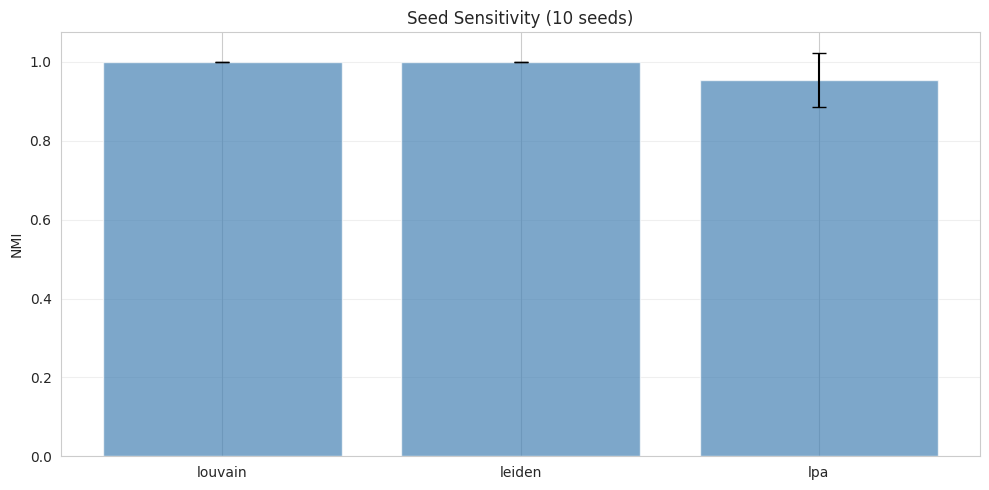


>>> Experiment 2: Perturbation Robustness

Experiment 2: Perturbation Robustness
Graph: {'nodes': 200, 'edges': 1863, 'density': 0.09361809045226131}
  Testing louvain...
  Testing leiden...
  Testing lpa...


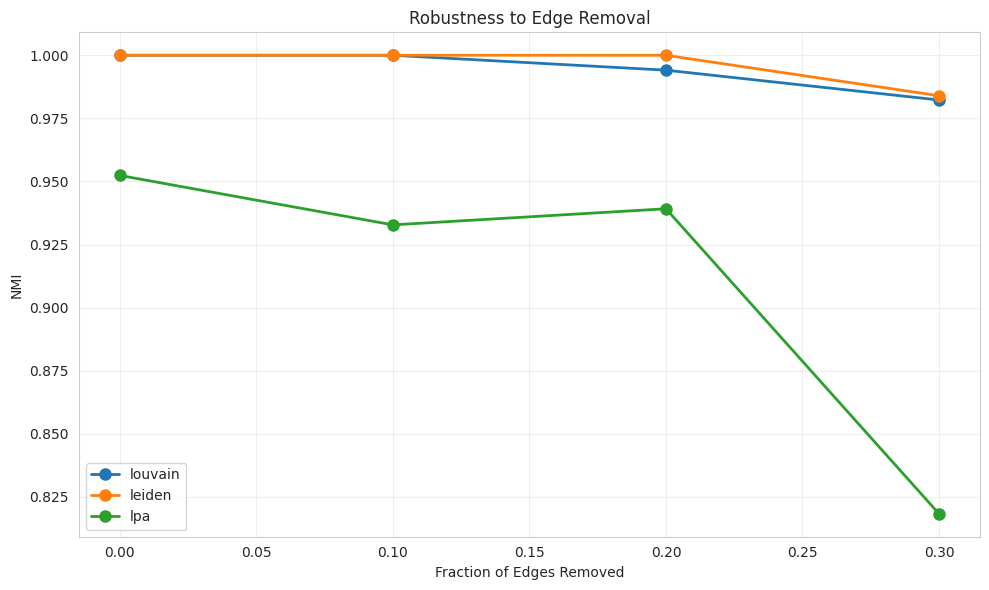


>>> Experiment 3: Scaling Analysis

Experiment 3: Scaling Analysis

  n = 100 nodes
    louvain: time=0.003s, NMI=0.896
    leiden: time=0.008s, NMI=0.925
    lpa: time=0.003s, NMI=0.630

  n = 200 nodes
    louvain: time=0.003s, NMI=1.000
    leiden: time=0.025s, NMI=1.000
    lpa: time=0.008s, NMI=1.000

  n = 400 nodes
    louvain: time=0.008s, NMI=1.000
    leiden: time=0.054s, NMI=1.000
    lpa: time=0.020s, NMI=1.000

  n = 800 nodes
    louvain: time=0.023s, NMI=1.000
    leiden: time=0.184s, NMI=1.000
    lpa: time=0.047s, NMI=1.000


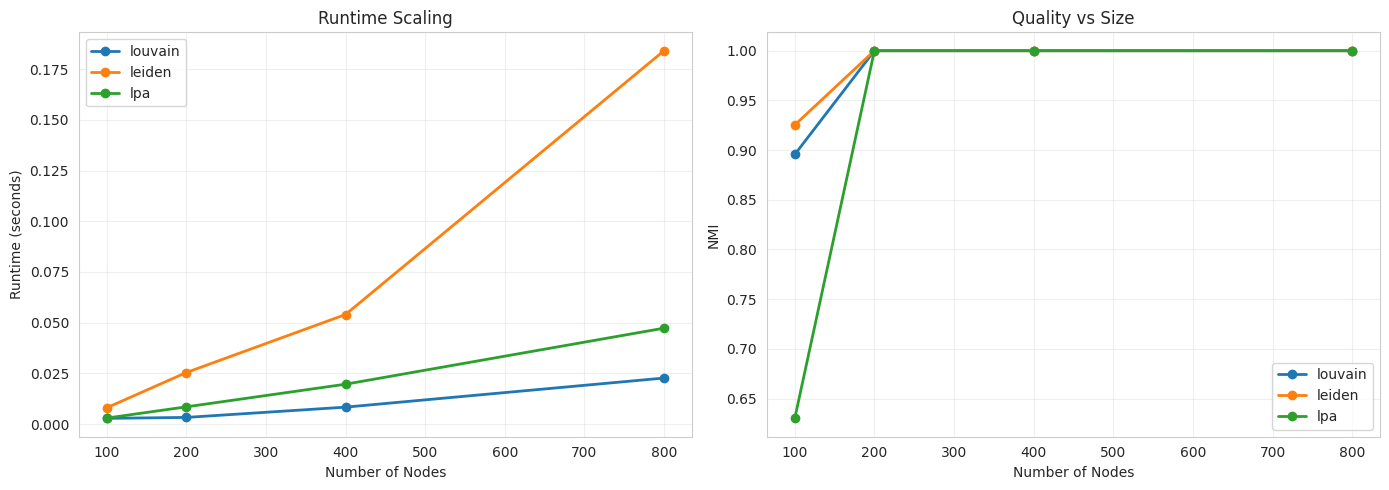


>>> Experiment 4: Resolution Ablation

Experiment 4: Resolution Ablation
Graph: {'nodes': 200, 'edges': 1755, 'density': 0.08819095477386935}


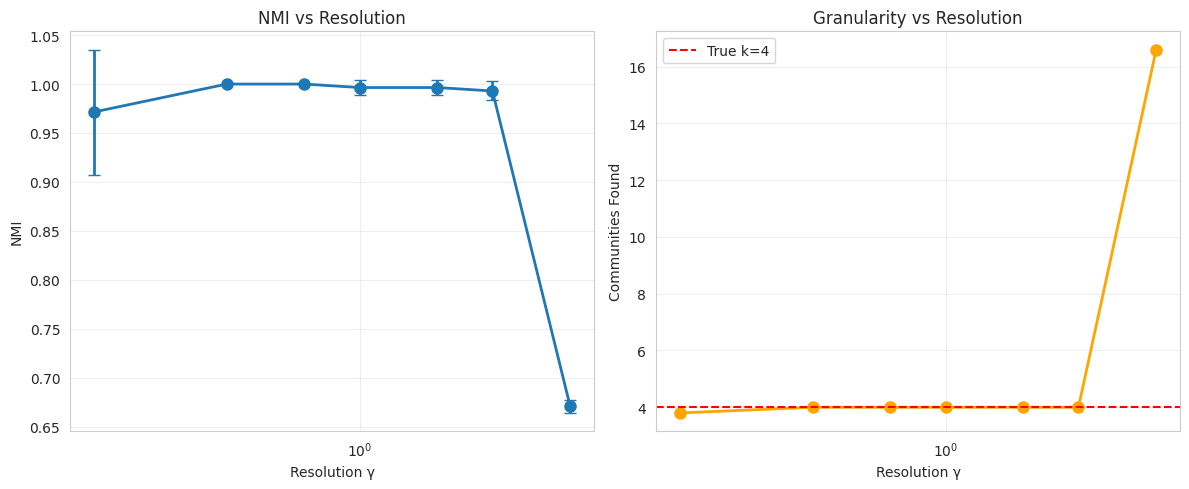


>>> Experiment 5: Spectral k Ablation

Experiment 5: Spectral k Ablation
Graph: {'nodes': 200, 'edges': 1755, 'density': 0.08819095477386935}


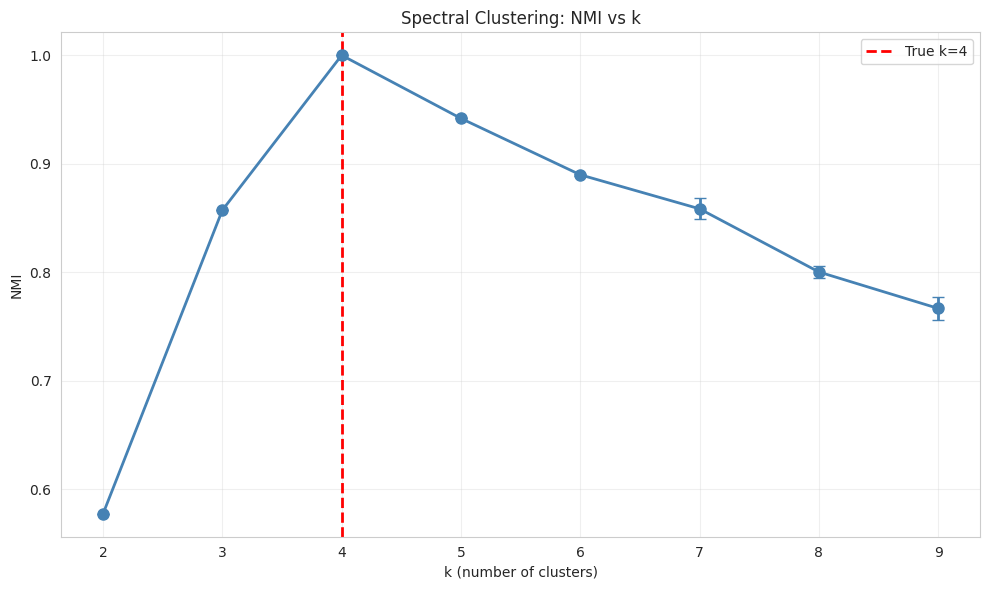


Best k = 4 (NMI = 1.0000)

>>> Experiment 6: LPA Stability

Experiment 6: LPA Stability Analysis
Graph: {'nodes': 200, 'edges': 1863, 'density': 0.09361809045226131}
Running LPA 30 times...

Results:
  NMI: 0.9660 ± 0.0616
  Range: [0.8385, 1.0000]


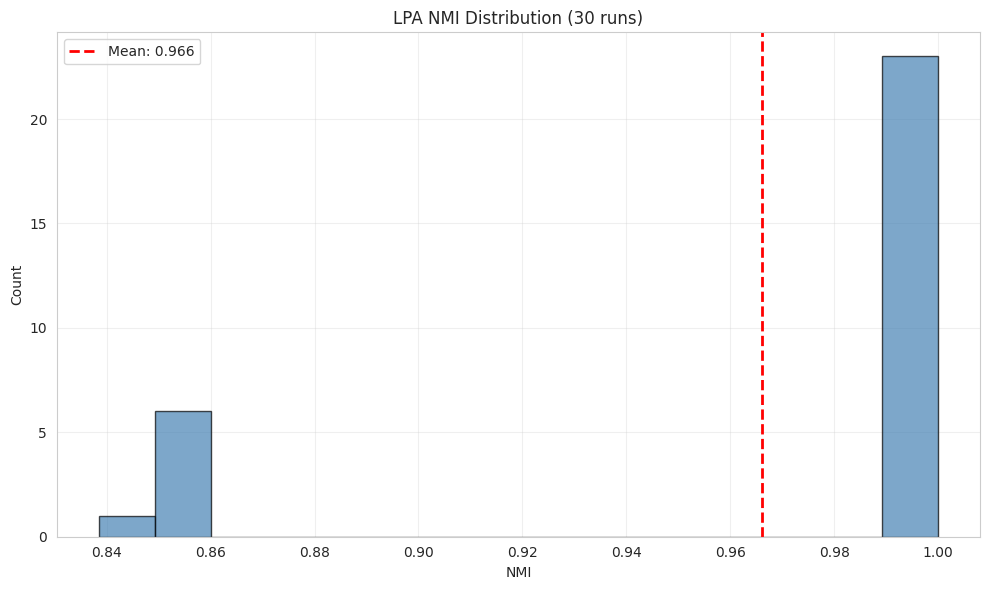


>>> Experiment 7: Mixing Robustness

Experiment 7: Mixing Parameter Analysis
  μ = 0.00
  μ = 0.10
  μ = 0.20
  μ = 0.30
  μ = 0.40
  μ = 0.50


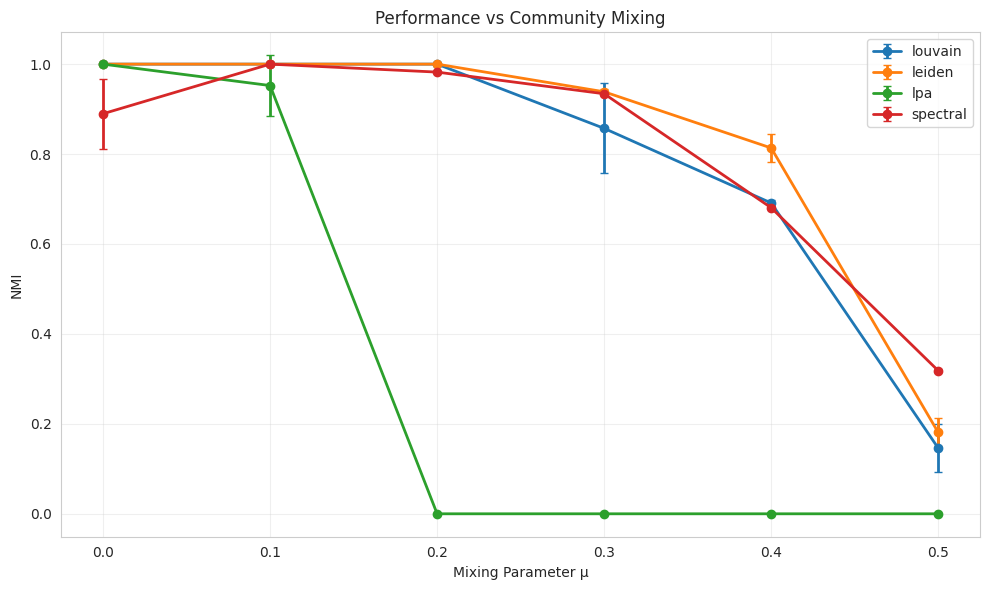


>>> Experiment 8: Summary

Experiment 8: Comprehensive Summary
  Evaluating louvain...
  Evaluating leiden...
  Evaluating lpa...
  Evaluating spectral...

SUMMARY TABLE
Algorithm           NMI Communities Time (ms)
  louvain 1.000 ± 0.000   4.0 ± 0.0       2.4
   leiden 1.000 ± 0.000   4.0 ± 0.0      16.0
      lpa 0.955 ± 0.068   3.8 ± 0.4       4.5
 spectral 1.000 ± 0.000   4.0 ± 0.0      18.4

✅ M4 COMPLETE!


In [ ]:
"""
M4 Experiments: Robustness & Scalability Analysis
Colab-friendly version with reduced memory footprint
"""

# Cell 1: Install dependencies
# !pip install python-igraph leidenalg infomap GraphRicciCurvature networkx scikit-learn matplotlib pandas seaborn tqdm -q

# Cell 2: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import time
import warnings
import gc
from typing import Dict, List, Callable, Tuple
from collections import defaultdict

warnings.filterwarnings('ignore')

# Import your existing modules (from M1-M3)
# Assuming these are already defined in previous cells


# =============================================================================
# DETECTOR FUNCTIONS (make sure these are defined from M1-M3)
# =============================================================================

# If not already defined, here are minimal versions:

def run_louvain(G: nx.Graph, resolution: float = 1.0, seed: int = None) -> Dict[int, int]:
    """Run Louvain algorithm."""
    import igraph as ig

    mapping = {n: i for i, n in enumerate(G.nodes())}
    reverse_mapping = {i: n for n, i in mapping.items()}

    edges = [(mapping[u], mapping[v]) for u, v in G.edges()]
    ig_graph = ig.Graph(edges=edges, directed=False)

    partition = ig_graph.community_multilevel(resolution=resolution)

    communities = {}
    for comm_id, members in enumerate(partition):
        for node_idx in members:
            communities[reverse_mapping[node_idx]] = comm_id

    return communities


def run_leiden(G: nx.Graph, resolution: float = 1.0, seed: int = None) -> Dict[int, int]:
    """Run Leiden algorithm."""
    import igraph as ig
    import leidenalg

    mapping = {n: i for i, n in enumerate(G.nodes())}
    reverse_mapping = {i: n for n, i in mapping.items()}

    edges = [(mapping[u], mapping[v]) for u, v in G.edges()]
    ig_graph = ig.Graph(edges=edges, directed=False)

    partition = leidenalg.find_partition(
        ig_graph,
        leidenalg.RBConfigurationVertexPartition,
        resolution_parameter=resolution,
        seed=seed if seed else 0
    )

    communities = {}
    for comm_id, members in enumerate(partition):
        for node_idx in members:
            communities[reverse_mapping[node_idx]] = comm_id

    return communities


def run_infomap(G: nx.Graph, seed: int = None, num_trials: int = 10) -> Dict[int, int]:
    """Run Infomap algorithm."""
    from infomap import Infomap

    im = Infomap(silent=True, seed=seed if seed else 0, num_trials=num_trials)

    mapping = {n: i for i, n in enumerate(G.nodes())}
    reverse_mapping = {i: n for n, i in mapping.items()}

    for u, v in G.edges():
        im.add_link(mapping[u], mapping[v])

    im.run()

    communities = {}
    for node in im.tree:
        if node.is_leaf:
            communities[reverse_mapping[node.node_id]] = node.module_id

    return communities


def run_label_propagation(G: nx.Graph, seed: int = None) -> Dict[int, int]:
    """Run Label Propagation Algorithm."""
    communities_generator = nx.community.asyn_lpa_communities(G, seed=seed)

    result = {}
    for comm_id, members in enumerate(communities_generator):
        for node in members:
            result[node] = comm_id

    return result


def run_spectral(G: nx.Graph, k: int = None, normalized: str = 'symmetric', seed: int = None) -> Dict[int, int]:
    """Simplified spectral clustering."""
    from scipy.sparse.linalg import eigsh
    from scipy.sparse import csr_matrix
    from sklearn.cluster import KMeans

    nodes = list(G.nodes())
    n = len(nodes)
    node_to_idx = {node: i for i, node in enumerate(nodes)}

    # Build adjacency matrix
    rows, cols, data = [], [], []
    for u, v in G.edges():
        i, j = node_to_idx[u], node_to_idx[v]
        rows.extend([i, j])
        cols.extend([j, i])
        data.extend([1.0, 1.0])

    A = csr_matrix((data, (rows, cols)), shape=(n, n))
    degrees = np.array(A.sum(axis=1)).flatten()

    # Normalized Laplacian
    with np.errstate(divide='ignore'):
        d_inv_sqrt = np.where(degrees > 0, 1.0 / np.sqrt(degrees), 0)
    from scipy.sparse import diags, eye
    D_inv_sqrt = diags(d_inv_sqrt)
    L = eye(n) - D_inv_sqrt @ A @ D_inv_sqrt

    # Determine k
    if k is None:
        k = 4  # Default

    k = min(k, n - 2)

    # Compute eigenvectors
    try:
        eigenvalues, eigenvectors = eigsh(L.tocsr(), k=k, which='SM', tol=1e-4)
    except:
        return {nodes[i]: 0 for i in range(n)}

    # K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=seed, n_init=10)
    labels = kmeans.fit_predict(eigenvectors)

    return {nodes[i]: int(labels[i]) for i in range(n)}


# =============================================================================
# METRICS (from M1)
# =============================================================================

from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

def compute_nmi(partition: Dict[int, int], ground_truth: Dict[int, int]) -> float:
    nodes = sorted(set(partition.keys()) & set(ground_truth.keys()))
    pred = np.array([partition.get(n, -1) for n in nodes])
    true = np.array([ground_truth.get(n, -1) for n in nodes])
    return normalized_mutual_info_score(true, pred)

def compute_ari(partition: Dict[int, int], ground_truth: Dict[int, int]) -> float:
    nodes = sorted(set(partition.keys()) & set(ground_truth.keys()))
    pred = np.array([partition.get(n, -1) for n in nodes])
    true = np.array([ground_truth.get(n, -1) for n in nodes])
    return adjusted_rand_score(true, pred)

def compute_modularity(G: nx.Graph, partition: Dict[int, int], resolution: float = 1.0) -> float:
    comm_to_nodes = defaultdict(set)
    for node, comm in partition.items():
        comm_to_nodes[comm].add(node)
    communities = list(comm_to_nodes.values())
    return nx.community.modularity(G, communities, resolution=resolution)


# =============================================================================
# GENERATORS (from M1)
# =============================================================================

def generate_sbm(sizes: List[int], p_in: float, p_out: float, seed: int = None) -> Tuple[nx.Graph, Dict[int, int]]:
    k = len(sizes)
    probs = np.full((k, k), p_out)
    np.fill_diagonal(probs, p_in)

    G = nx.stochastic_block_model(sizes, probs, seed=seed)
    ground_truth = {n: G.nodes[n]['block'] for n in G.nodes()}

    return G, ground_truth

def graph_summary(G: nx.Graph) -> Dict:
    return {
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'density': nx.density(G),
    }


# =============================================================================
# SIMPLIFIED ROBUSTNESS FUNCTIONS (Memory-efficient)
# =============================================================================

def seed_sweep_simple(G: nx.Graph,
                      detector_fn: Callable,
                      ground_truth: Dict[int, int] = None,
                      n_seeds: int = 10,
                      **kwargs) -> Dict:
    """
    Simplified seed sweep without memory profiling.
    """
    nmis = []
    modularities = []
    n_communities = []
    partitions = []

    for seed in range(n_seeds):
        try:
            partition = detector_fn(G, seed=seed, **kwargs)
            partitions.append(partition)
            modularities.append(compute_modularity(G, partition))
            n_communities.append(len(set(partition.values())))

            if ground_truth is not None:
                nmis.append(compute_nmi(partition, ground_truth))
        except Exception as e:
            print(f"    Seed {seed} failed: {e}")
            continue

        # Force garbage collection every few iterations
        if seed % 5 == 0:
            gc.collect()

    if len(partitions) < 2:
        return {'error': 'Not enough successful runs'}

    # Compute stability (sample pairwise, not all pairs)
    n_samples = min(20, len(partitions) * (len(partitions) - 1) // 2)
    stability_samples = []

    for _ in range(n_samples):
        i, j = np.random.choice(len(partitions), 2, replace=False)
        stability_samples.append(compute_nmi(partitions[i], partitions[j]))

    results = {
        'n_runs': len(partitions),
        'modularity_mean': np.mean(modularities),
        'modularity_std': np.std(modularities),
        'n_communities_mean': np.mean(n_communities),
        'n_communities_std': np.std(n_communities),
        'partition_stability': np.mean(stability_samples),
    }

    if ground_truth is not None:
        results['nmi_mean'] = np.mean(nmis)
        results['nmi_std'] = np.std(nmis)

    # Clean up
    del partitions
    gc.collect()

    return results


def perturbation_test_simple(G: nx.Graph,
                             detector_fn: Callable,
                             ground_truth: Dict[int, int],
                             fractions: List[float] = None,
                             n_trials: int = 3,
                             **kwargs) -> List[Dict]:
    """
    Simplified perturbation test.
    """
    if fractions is None:
        fractions = [0.0, 0.1, 0.2, 0.3]

    results = []
    edges = list(G.edges())

    for frac in fractions:
        nmis = []

        for trial in range(n_trials):
            # Create perturbed graph
            G_pert = G.copy()

            if frac > 0:
                n_remove = int(len(edges) * frac)
                remove_idx = np.random.choice(len(edges), size=n_remove, replace=False)
                edges_to_remove = [edges[i] for i in remove_idx]
                G_pert.remove_edges_from(edges_to_remove)

            try:
                partition = detector_fn(G_pert, seed=trial, **kwargs)
                nmis.append(compute_nmi(partition, ground_truth))
            except:
                continue

            del G_pert
            gc.collect()

        results.append({
            'fraction': frac,
            'nmi_mean': np.mean(nmis) if nmis else np.nan,
            'nmi_std': np.std(nmis) if nmis else np.nan,
        })

    return results


# =============================================================================
# M4 EXPERIMENTS (Colab-safe versions)
# =============================================================================

def experiment_1_seed_sensitivity():
    """Test seed sensitivity - reduced version."""
    print("\n" + "="*60)
    print("Experiment 1: Seed Sensitivity Analysis")
    print("="*60)

    # Use smaller graph
    G, gt = generate_sbm([50]*4, p_in=0.3, p_out=0.03, seed=42)
    print(f"Graph: {graph_summary(G)}")

    # Only test fast algorithms
    detectors = {
        'louvain': run_louvain,
        'leiden': run_leiden,
        'lpa': run_label_propagation,
    }

    results = {}

    for name, detector in detectors.items():
        print(f"  Testing {name}...")
        results[name] = seed_sweep_simple(G, detector, gt, n_seeds=10)
        gc.collect()

    # Print results
    print("\n" + "-"*50)
    print(f"{'Algorithm':<12} {'NMI':>8} {'Std':>8} {'Stability':>10}")
    print("-"*50)

    for algo, res in results.items():
        nmi = res.get('nmi_mean', np.nan)
        std = res.get('nmi_std', np.nan)
        stab = res.get('partition_stability', np.nan)
        print(f"{algo:<12} {nmi:>8.4f} {std:>8.4f} {stab:>10.4f}")

    # Simple bar plot
    fig, ax = plt.subplots(figsize=(10, 5))

    algos = list(results.keys())
    nmis = [results[a].get('nmi_mean', 0) for a in algos]
    stds = [results[a].get('nmi_std', 0) for a in algos]

    x = np.arange(len(algos))
    ax.bar(x, nmis, yerr=stds, capsize=5, color='steelblue', alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(algos)
    ax.set_ylabel('NMI')
    ax.set_title('Seed Sensitivity (10 seeds)')
    ax.grid(True, alpha=0.3, axis='y')
    plt.tight_layout()
    plt.show()

    return results


def experiment_2_perturbation():
    """Test perturbation robustness - reduced version."""
    print("\n" + "="*60)
    print("Experiment 2: Perturbation Robustness")
    print("="*60)

    G, gt = generate_sbm([50]*4, p_in=0.3, p_out=0.03, seed=42)
    print(f"Graph: {graph_summary(G)}")

    detectors = {
        'louvain': run_louvain,
        'leiden': run_leiden,
        'lpa': run_label_propagation,
    }

    fractions = [0.0, 0.1, 0.2, 0.3]
    all_results = {}

    for name, detector in detectors.items():
        print(f"  Testing {name}...")
        all_results[name] = perturbation_test_simple(G, detector, gt, fractions, n_trials=3)
        gc.collect()

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    for algo, results in all_results.items():
        fracs = [r['fraction'] for r in results]
        nmis = [r['nmi_mean'] for r in results]
        ax.plot(fracs, nmis, 'o-', label=algo, linewidth=2, markersize=8)

    ax.set_xlabel('Fraction of Edges Removed')
    ax.set_ylabel('NMI')
    ax.set_title('Robustness to Edge Removal')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return all_results


def experiment_3_scaling():
    """Test scaling - reduced version."""
    print("\n" + "="*60)
    print("Experiment 3: Scaling Analysis")
    print("="*60)

    sizes = [25, 50, 100, 200]

    detectors = {
        'louvain': run_louvain,
        'leiden': run_leiden,
        'lpa': run_label_propagation,
    }

    results = []

    for n_per_comm in sizes:
        n_total = n_per_comm * 4
        print(f"\n  n = {n_total} nodes")

        G, gt = generate_sbm([n_per_comm]*4, p_in=0.2, p_out=0.01, seed=42)

        for algo_name, detector in detectors.items():
            t0 = time.time()
            try:
                partition = detector(G, seed=42)
                runtime = time.time() - t0
                nmi = compute_nmi(partition, gt)

                results.append({
                    'algorithm': algo_name,
                    'n_nodes': n_total,
                    'n_edges': G.number_of_edges(),
                    'runtime': runtime,
                    'nmi': nmi
                })

                print(f"    {algo_name}: time={runtime:.3f}s, NMI={nmi:.3f}")

            except Exception as e:
                print(f"    {algo_name}: FAILED - {e}")

        gc.collect()

    df = pd.DataFrame(results)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for algo in df['algorithm'].unique():
        subset = df[df['algorithm'] == algo]
        axes[0].plot(subset['n_nodes'], subset['runtime'], 'o-', label=algo, linewidth=2)
        axes[1].plot(subset['n_nodes'], subset['nmi'], 'o-', label=algo, linewidth=2)

    axes[0].set_xlabel('Number of Nodes')
    axes[0].set_ylabel('Runtime (seconds)')
    axes[0].set_title('Runtime Scaling')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    axes[1].set_xlabel('Number of Nodes')
    axes[1].set_ylabel('NMI')
    axes[1].set_title('Quality vs Size')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df


def experiment_4_resolution_ablation():
    """Resolution parameter ablation."""
    print("\n" + "="*60)
    print("Experiment 4: Resolution Ablation")
    print("="*60)

    G, gt = generate_sbm([50]*4, p_in=0.3, p_out=0.02, seed=42)
    print(f"Graph: {graph_summary(G)}")

    resolutions = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0]

    results = []

    for gamma in resolutions:
        for seed in range(5):
            partition = run_louvain(G, resolution=gamma, seed=seed)

            results.append({
                'resolution': gamma,
                'seed': seed,
                'nmi': compute_nmi(partition, gt),
                'n_communities': len(set(partition.values())),
                'modularity': compute_modularity(G, partition, resolution=gamma)
            })

    df = pd.DataFrame(results)

    # Aggregate
    agg = df.groupby('resolution').agg({
        'nmi': ['mean', 'std'],
        'n_communities': 'mean'
    }).reset_index()
    agg.columns = ['resolution', 'nmi_mean', 'nmi_std', 'k_mean']

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].errorbar(agg['resolution'], agg['nmi_mean'], yerr=agg['nmi_std'],
                    marker='o', linewidth=2, markersize=8, capsize=4)
    axes[0].set_xlabel('Resolution γ')
    axes[0].set_ylabel('NMI')
    axes[0].set_title('NMI vs Resolution')
    axes[0].set_xscale('log')
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(agg['resolution'], agg['k_mean'], 'o-', linewidth=2, markersize=8, color='orange')
    axes[1].axhline(y=4, color='red', linestyle='--', label='True k=4')
    axes[1].set_xlabel('Resolution γ')
    axes[1].set_ylabel('Communities Found')
    axes[1].set_title('Granularity vs Resolution')
    axes[1].set_xscale('log')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df


def experiment_5_spectral_k():
    """Spectral k ablation."""
    print("\n" + "="*60)
    print("Experiment 5: Spectral k Ablation")
    print("="*60)

    G, gt = generate_sbm([50]*4, p_in=0.3, p_out=0.02, seed=42)
    print(f"Graph: {graph_summary(G)}")

    k_values = range(2, 10)
    results = []

    for k in k_values:
        for seed in range(5):
            try:
                partition = run_spectral(G, k=k, seed=seed)
                results.append({
                    'k': k,
                    'seed': seed,
                    'nmi': compute_nmi(partition, gt),
                    'modularity': compute_modularity(G, partition)
                })
            except:
                continue

    df = pd.DataFrame(results)

    # Aggregate
    agg = df.groupby('k').agg({'nmi': ['mean', 'std']}).reset_index()
    agg.columns = ['k', 'nmi_mean', 'nmi_std']

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.errorbar(agg['k'], agg['nmi_mean'], yerr=agg['nmi_std'],
               marker='o', linewidth=2, markersize=8, capsize=4, color='steelblue')
    ax.axvline(x=4, color='red', linestyle='--', linewidth=2, label='True k=4')
    ax.set_xlabel('k (number of clusters)')
    ax.set_ylabel('NMI')
    ax.set_title('Spectral Clustering: NMI vs k')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Best k
    best_k = agg.loc[agg['nmi_mean'].idxmax(), 'k']
    print(f"\nBest k = {best_k} (NMI = {agg['nmi_mean'].max():.4f})")

    return df


def experiment_6_lpa_stability():
    """LPA stability analysis."""
    print("\n" + "="*60)
    print("Experiment 6: LPA Stability Analysis")
    print("="*60)

    G, gt = generate_sbm([50]*4, p_in=0.3, p_out=0.03, seed=42)
    print(f"Graph: {graph_summary(G)}")

    n_runs = 30
    nmis = []

    print(f"Running LPA {n_runs} times...")
    for seed in range(n_runs):
        partition = run_label_propagation(G, seed=seed)
        nmis.append(compute_nmi(partition, gt))

    print(f"\nResults:")
    print(f"  NMI: {np.mean(nmis):.4f} ± {np.std(nmis):.4f}")
    print(f"  Range: [{np.min(nmis):.4f}, {np.max(nmis):.4f}]")

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.hist(nmis, bins=15, alpha=0.7, color='steelblue', edgecolor='black')
    ax.axvline(x=np.mean(nmis), color='red', linestyle='--', linewidth=2,
              label=f'Mean: {np.mean(nmis):.3f}')
    ax.set_xlabel('NMI')
    ax.set_ylabel('Count')
    ax.set_title(f'LPA NMI Distribution ({n_runs} runs)')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return nmis


def experiment_7_mixing_robustness():
    """Performance vs mixing parameter."""
    print("\n" + "="*60)
    print("Experiment 7: Mixing Parameter Analysis")
    print("="*60)

    mu_values = np.linspace(0.0, 0.5, 6)

    detectors = {
        'louvain': run_louvain,
        'leiden': run_leiden,
        'lpa': run_label_propagation,
        'spectral': lambda G, seed=42: run_spectral(G, k=4, seed=seed),
    }

    results = []

    for mu in mu_values:
        print(f"  μ = {mu:.2f}")
        G, gt = generate_sbm([50]*4, p_in=0.3, p_out=mu*0.3, seed=42)

        for algo_name, detector in detectors.items():
            nmis = []
            for seed in range(3):
                try:
                    partition = detector(G, seed=seed)
                    nmis.append(compute_nmi(partition, gt))
                except:
                    continue

            if nmis:
                results.append({
                    'mu': mu,
                    'algorithm': algo_name,
                    'nmi_mean': np.mean(nmis),
                    'nmi_std': np.std(nmis)
                })

        gc.collect()

    df = pd.DataFrame(results)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))

    for algo in df['algorithm'].unique():
        subset = df[df['algorithm'] == algo]
        ax.errorbar(subset['mu'], subset['nmi_mean'], yerr=subset['nmi_std'],
                   marker='o', label=algo, linewidth=2, markersize=6, capsize=3)

    ax.set_xlabel('Mixing Parameter μ')
    ax.set_ylabel('NMI')
    ax.set_title('Performance vs Community Mixing')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df


def experiment_8_summary():
    """Final comprehensive summary."""
    print("\n" + "="*60)
    print("Experiment 8: Comprehensive Summary")
    print("="*60)

    G, gt = generate_sbm([50]*4, p_in=0.3, p_out=0.03, seed=42)

    detectors = {
        'louvain': run_louvain,
        'leiden': run_leiden,
        'lpa': run_label_propagation,
        'spectral': lambda G, seed=42: run_spectral(G, k=4, seed=seed),
    }

    summary = []

    for algo_name, detector in detectors.items():
        print(f"  Evaluating {algo_name}...")

        nmis = []
        times = []
        n_comms = []

        for seed in range(10):
            t0 = time.time()
            try:
                partition = detector(G, seed=seed)
                times.append(time.time() - t0)
                nmis.append(compute_nmi(partition, gt))
                n_comms.append(len(set(partition.values())))
            except:
                continue

        summary.append({
            'Algorithm': algo_name,
            'NMI': f"{np.mean(nmis):.3f} ± {np.std(nmis):.3f}",
            'Communities': f"{np.mean(n_comms):.1f} ± {np.std(n_comms):.1f}",
            'Time (ms)': f"{np.mean(times)*1000:.1f}",
        })

    df = pd.DataFrame(summary)
    print("\n" + "="*60)
    print("SUMMARY TABLE")
    print("="*60)
    print(df.to_string(index=False))

    return df


# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    print("="*60)
    print("M4: Robustness & Scalability Analysis")
    print("="*60)

    # Run experiments one by one
    print("\n>>> Experiment 1: Seed Sensitivity")
    results_1 = experiment_1_seed_sensitivity()
    gc.collect()

    print("\n>>> Experiment 2: Perturbation Robustness")
    results_2 = experiment_2_perturbation()
    gc.collect()

    print("\n>>> Experiment 3: Scaling Analysis")
    results_3 = experiment_3_scaling()
    gc.collect()

    print("\n>>> Experiment 4: Resolution Ablation")
    results_4 = experiment_4_resolution_ablation()
    gc.collect()

    print("\n>>> Experiment 5: Spectral k Ablation")
    results_5 = experiment_5_spectral_k()
    gc.collect()

    print("\n>>> Experiment 6: LPA Stability")
    results_6 = experiment_6_lpa_stability()
    gc.collect()

    print("\n>>> Experiment 7: Mixing Robustness")
    results_7 = experiment_7_mixing_robustness()
    gc.collect()

    print("\n>>> Experiment 8: Summary")
    results_8 = experiment_8_summary()

    print("\n" + "="*60)
    print("✅ M4 COMPLETE!")
    print("="*60)


Experiment 6: Ricci Flow Ablation
Graph: {'nodes': 200, 'edges': 2126, 'density': 0.10683417085427135}
Running Ricci parameter ablation...


ValueError: Format ' png' is not supported (supported formats: eps, jpeg, jpg, pdf, pgf, png, ps, raw, rgba, svg, svgz, tif, tiff, webp)

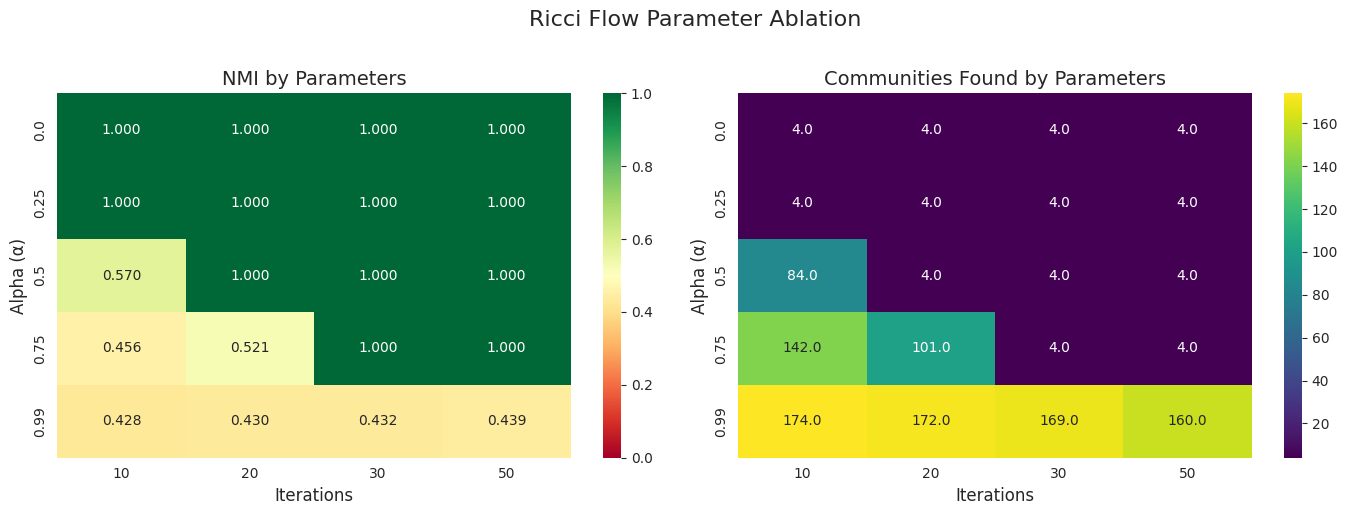

In [ ]:
def experiment_6_ricci_ablation():
    """Ablation study on Ricci flow parameters."""
    print("\n" + "="*60)
    print("Experiment 6: Ricci Flow Ablation")
    print("="*60)

    # Use smaller graph for Ricci (slower)
    G, gt = generate_sbm([50]*4, p_in=0.35, p_out=0.03, seed=42)
    print(f"Graph: {graph_summary(G)}")

    print("Running Ricci parameter ablation...")
    df = ricci_ablation(
        G, gt,
        alphas=[0.0, 0.25, 0.5, 0.75, 0.99],
        iterations_list=[10, 20, 30, 50],
        n_seeds=3
    )
    df.to_csv("results/ricci_ablation.csv", index=False)

    plot_ricci_ablation(
        df,
        title="Ricci Flow Parameter Ablation",
        save_path="results/ricci_ablation.png"
    )

    # Find best parameters
    best_idx = df. groupby(['alpha', 'iterations'])['nmi'].mean().idxmax()
    print(f"\nBest parameters: alpha={best_idx[0]}, iterations={best_idx[1]}")
    print(f"Best NMI: {df.groupby(['alpha', 'iterations'])['nmi'].mean().max():.4f}")

    return df

experiment_6_ricci_ablation()

#M5

In [ ]:
"""
M5: Synthesis - Full Comparisons, Tables, Figures, and Method Selection Guidance

This module provides:
1.Comprehensive benchmark across all methods
2.Publication-ready figures and tables
3.Decision framework for method selection
4.Theoretical vs empirical analysis
5.Final recommendations
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
import seaborn as sns
from typing import Dict, List, Tuple, Optional
from collections import defaultdict
import time
import gc
import warnings
warnings.filterwarnings('ignore')

# Set publication-quality plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 11,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.dpi': 150,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
})

def run_infomap(G, seed=None):
    """
    Infomap community detection - FIXED VERSION.

    Note: Infomap 2.x has different argument handling.
    We avoid passing problematic arguments.
    """
    from infomap import Infomap

    # Create Infomap WITHOUT seed argument (causes issues in v2.x)
    # Use silent mode and fewer trials for speed
    im = Infomap(silent=True, num_trials=5)

    mapping = {n: i for i, n in enumerate(G.nodes())}
    reverse_mapping = {i: n for n, i in mapping.items()}

    for u, v in G. edges():
        im.add_link(mapping[u], mapping[v])

    im.run()

    result = {}
    for node in im.tree:
        if node. is_leaf:
            result[reverse_mapping[node. node_id]] = node.module_id

    return result


M5: SYNTHESIS - Comprehensive Comparative Analysis

[1/5] Phase Transition Analysis
----------------------------------------
  μ = 0.00 ✓
  μ = 0.05 ✓
  μ = 0.10 ✓
  μ = 0.15 ✓
  μ = 0.20 ✓
  μ = 0.25 ✓
  μ = 0.30 ✓
  μ = 0.35 ✓
  μ = 0.40 ✓
  μ = 0.45 ✓
  μ = 0.50 ✓
  μ = 0.55 ✓
  μ = 0.60 ✓

[2/5] Scalability Analysis
----------------------------------------
  n = 200 ✓
  n = 400 ✓
  n = 800 ✓
  n = 1600 ✓

[3/5] Stability Analysis
----------------------------------------
  Louvain... ✓
  Leiden... ✓
  Infomap... ✓
  LPA... ✓
  Spectral... ✓
  Ricci... ✓

[4/5] Robustness Analysis
----------------------------------------
  perturbation = 0% ✓
  perturbation = 5% ✓
  perturbation = 10% ✓
  perturbation = 15% ✓
  perturbation = 20% ✓
  perturbation = 25% ✓
  perturbation = 30% ✓

[5/5] Real Network Benchmarks
----------------------------------------
  Karate Club... ✓
  LFR (μ=0.1)... skipped (Could not assign communities; try increasing min_community)
  LFR (μ=0.3)... skipped (Could n

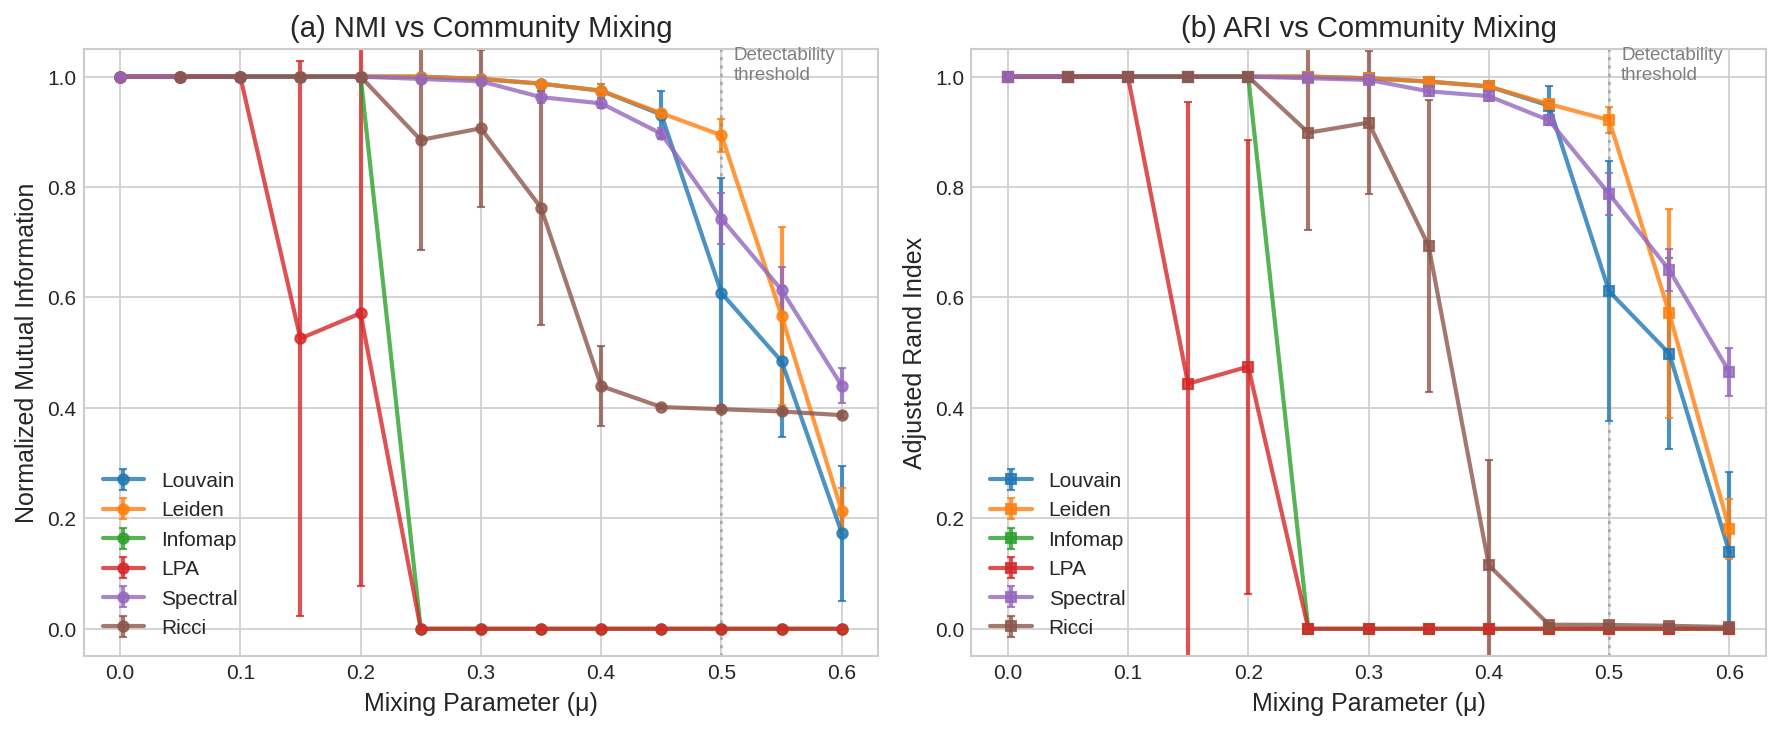


Figure 2: Scalability


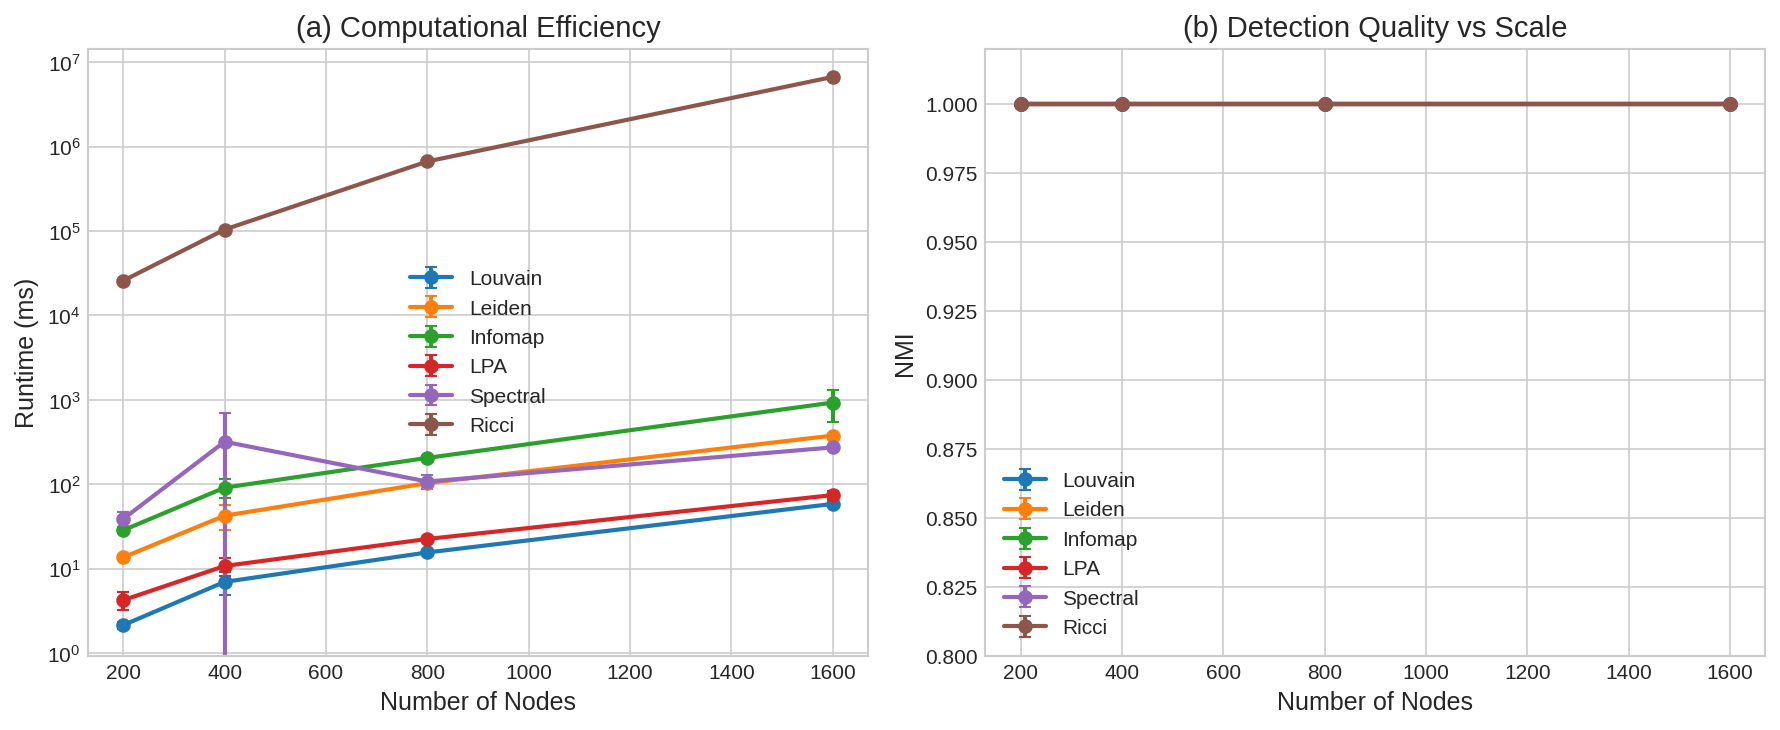


Figure 3: Robustness


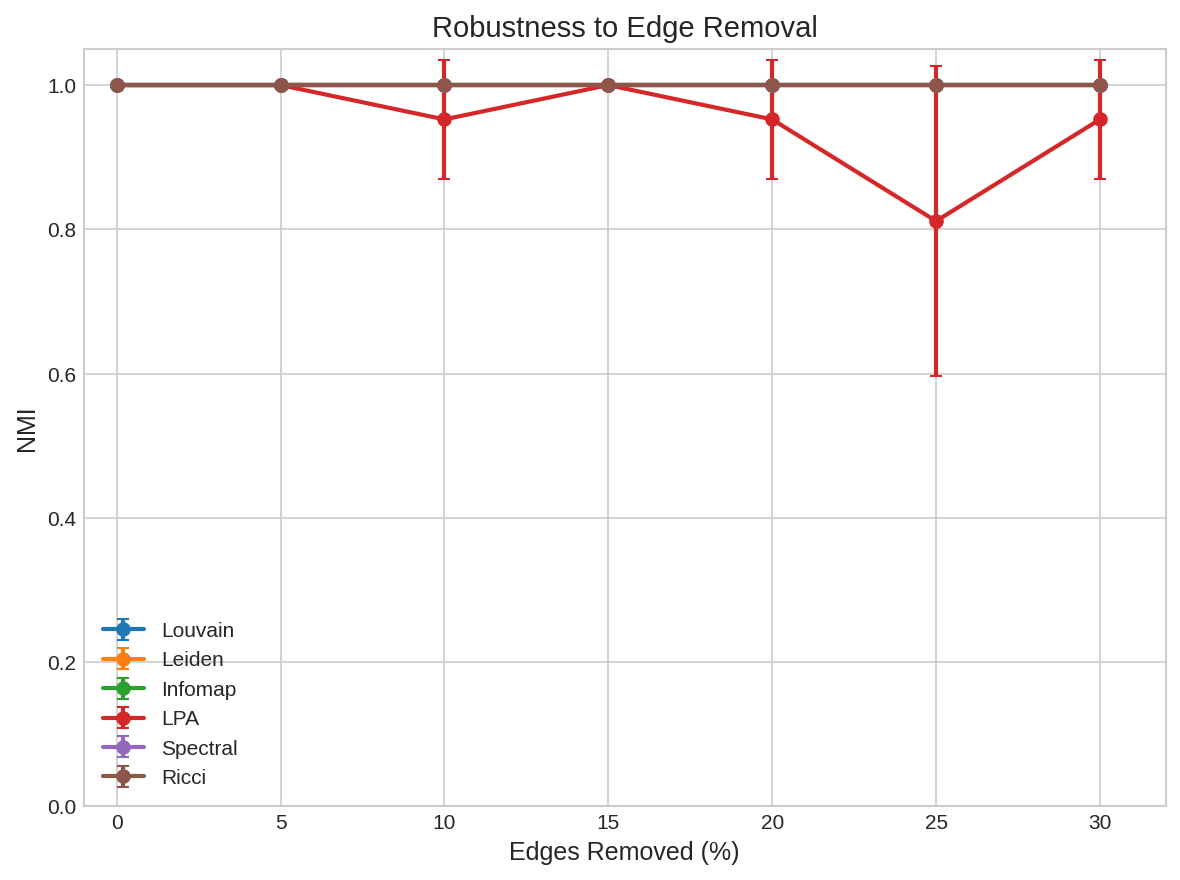


Figure 4: Stability


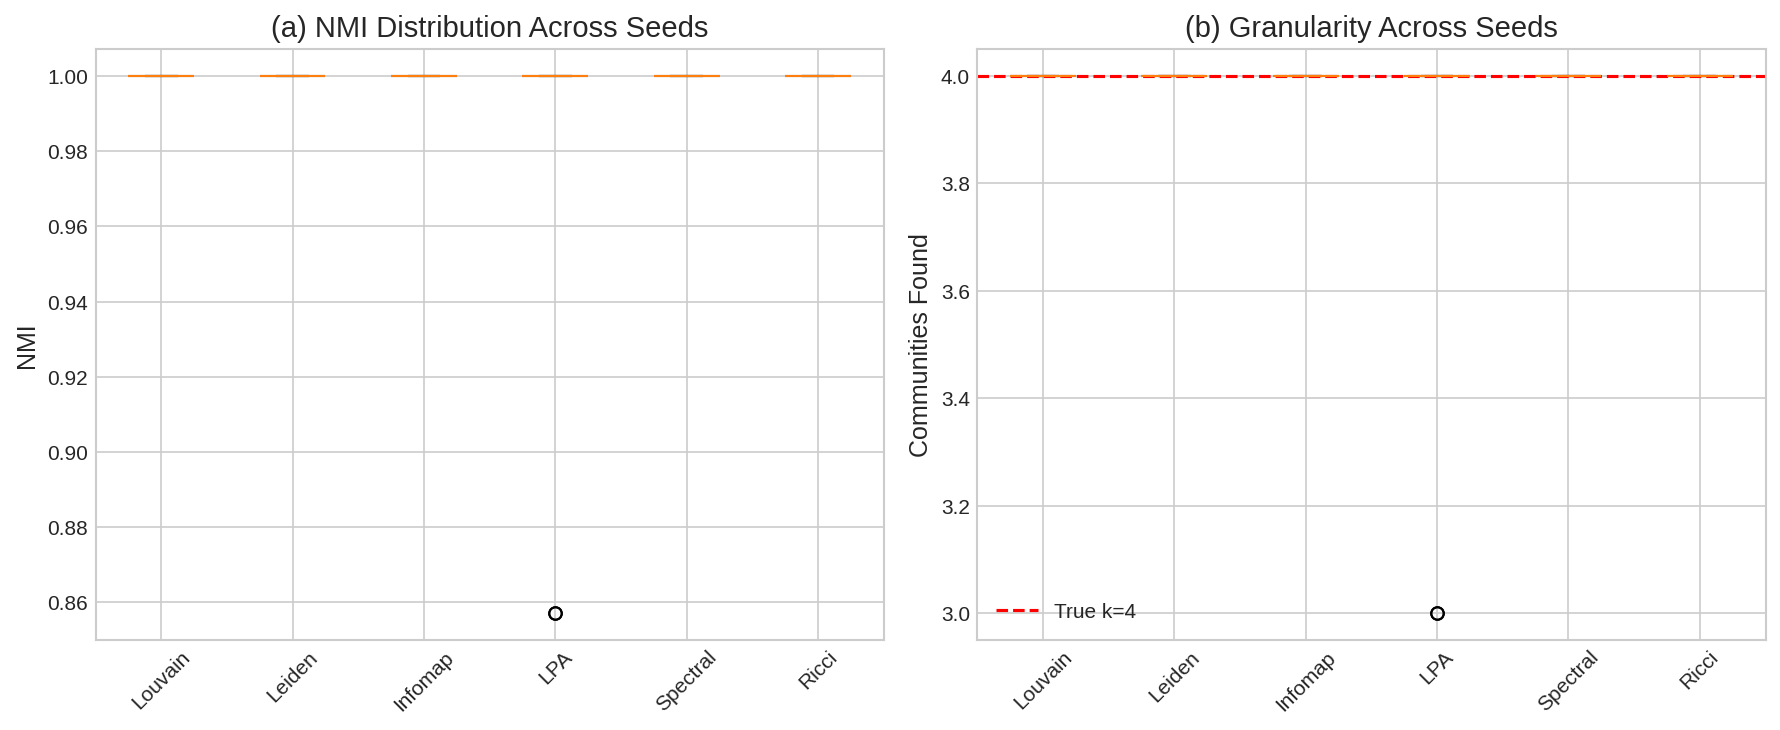


Figure 5: Comprehensive Radar


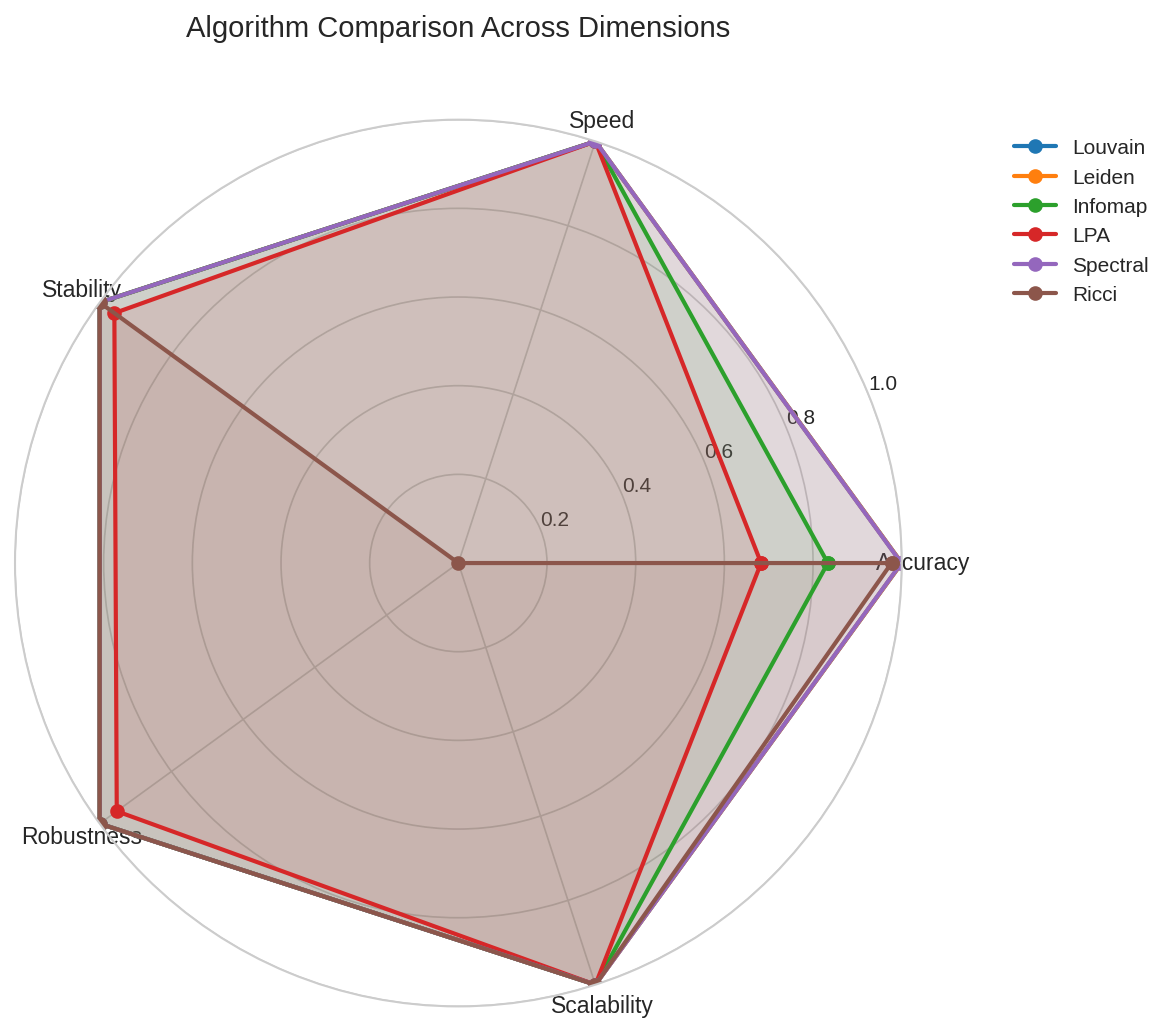


Generating Summary Tables

Table 1: Overall Performance
Algorithm   NMI (μ≤0.2)  NMI (μ~0.45) Runtime (ms) Stability
  Louvain 1.000 ± 0.000 0.770 ± 0.222         20.8     1.000
      LPA 0.819 ± 0.352 0.000 ± 0.000         28.0     0.959
  Infomap 1.000 ± 0.000 0.000 ± 0.000        313.5     1.000
 Spectral 1.000 ± 0.000 0.820 ± 0.089        184.9     1.000
   Leiden 1.000 ± 0.000 0.914 ± 0.029        134.2     1.000
    Ricci 1.000 ± 0.000 0.400 ± 0.004    1868776.5     1.000

Table 2: Method Characteristics
Algorithm    Optimization     Complexity Deterministic Resolution Param Hierarchical                            Best For
  Louvain      Modularity     O(n log n)            No          Yes (γ)          Yes     General purpose, large networks
   Leiden      Modularity     O(n log n)            No          Yes (γ)          Yes      High-quality results, research
  Infomap    Map Equation           O(m)            No               No          Yes    Flow-based communities, directed

NameError: name 'print_decision_flowchart' is not defined

In [ ]:

class ComprehensiveBenchmark:
    """
    Framework for comprehensive algorithm benchmarking.
    """

    def __init__(self):
        self.detectors = {
            'Louvain': run_louvain,
            'Leiden': run_leiden,
            'Infomap': run_infomap,
            'LPA': run_label_propagation,
            'Spectral': lambda G, seed=None: run_spectral(G, k=4, seed=seed),
            'Ricci': run_ricci
        }
        self.results = {}

    def benchmark_accuracy_vs_mixing(self,
                                      n_per_comm: int = 100,
                                      k: int = 4,
                                      p_in: float = 0.3,
                                      mu_values: np.ndarray = None,
                                      n_seeds: int = 5) -> pd.DataFrame:
        """
        Benchmark accuracy across different mixing parameters (phase transition).
        """
        if mu_values is None:
            mu_values = np.linspace(0.0, 0.6, 13)

        records = []

        for mu in mu_values:
            p_out = mu * p_in
            print(f"  μ = {mu:.2f}", end=" ")

            for seed in range(n_seeds):
                G, gt = generate_sbm([n_per_comm]*k, p_in, p_out, seed=seed)

                for algo_name, detector in self.detectors.items():
                    try:
                        t0 = time.time()
                        partition = detector(G, seed=seed)
                        runtime = time.time() - t0

                        records.append({
                            'mu': mu,
                            'algorithm': algo_name,
                            'seed': seed,
                            'nmi': compute_nmi(partition, gt),
                            'ari': compute_ari(partition, gt),
                            'modularity': compute_modularity(G, partition),
                            'n_communities': len(set(partition.values())),
                            'runtime': runtime
                        })
                    except Exception as e:
                        continue

            print("✓")
            gc.collect()

        self.results['phase_transition'] = pd.DataFrame(records)
        return self.results['phase_transition']

    def benchmark_scalability(self,
                              sizes: List[int] = None,
                              k: int = 4,
                              n_trials: int = 3) -> pd.DataFrame:
        """
        Benchmark runtime and quality vs graph size.
        """
        if sizes is None:
            sizes = [50, 100, 200, 500, 1000]

        records = []

        for n_per_comm in sizes:
            n_total = n_per_comm * k
            print(f"  n = {n_total}", end=" ")

            for trial in range(n_trials):
                G, gt = generate_sbm([n_per_comm]*k, p_in=0.2, p_out=0.01,
                                     seed=trial)

                for algo_name, detector in self.detectors.items():
                    try:
                        t0 = time.time()
                        partition = detector(G, seed=trial)
                        runtime = time.time() - t0

                        records.append({
                            'n_nodes': n_total,
                            'n_edges': G.number_of_edges(),
                            'algorithm': algo_name,
                            'trial': trial,
                            'nmi': compute_nmi(partition, gt),
                            'runtime': runtime
                        })
                    except:
                        continue

            print("✓")
            gc.collect()

        self.results['scalability'] = pd.DataFrame(records)
        return self.results['scalability']

    def benchmark_stability(self,
                            n_per_comm: int = 100,
                            k: int = 4,
                            n_seeds: int = 20) -> pd.DataFrame:
        """
        Benchmark partition stability across random seeds.
        """
        G, gt = generate_sbm([n_per_comm]*k, p_in=0.3, p_out=0.03, seed=42)

        records = []
        partitions_by_algo = defaultdict(list)

        for algo_name, detector in self.detectors.items():
            print(f"  {algo_name}...", end=" ")

            for seed in range(n_seeds):
                try:
                    partition = detector(G, seed=seed)
                    partitions_by_algo[algo_name].append(partition)

                    records.append({
                        'algorithm': algo_name,
                        'seed': seed,
                        'nmi': compute_nmi(partition, gt),
                        'n_communities': len(set(partition.values()))
                    })
                except:
                    continue

            print("✓")

        # Compute pairwise stability
        stability_records = []
        for algo_name, partitions in partitions_by_algo.items():
            pairwise_nmis = []
            for i in range(len(partitions)):
                for j in range(i+1, min(i+5, len(partitions))):  # Sample pairs
                    pairwise_nmis.append(compute_nmi(partitions[i], partitions[j]))

            stability_records.append({
                'algorithm': algo_name,
                'stability_mean': np.mean(pairwise_nmis),
                'stability_std': np.std(pairwise_nmis)
            })

        self.results['stability'] = pd.DataFrame(records)
        self.results['stability_summary'] = pd.DataFrame(stability_records)
        return self.results['stability']

    def benchmark_robustness(self,
                             n_per_comm: int = 100,
                             k: int = 4,
                             perturbation_fracs: List[float] = None,
                             n_trials: int = 5) -> pd.DataFrame:
        """
        Benchmark robustness to edge perturbations.
        """
        if perturbation_fracs is None:
            perturbation_fracs = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

        G_orig, gt = generate_sbm([n_per_comm]*k, p_in=0.3, p_out=0.03, seed=42)
        edges = list(G_orig.edges())

        records = []

        for frac in perturbation_fracs:
            print(f"  perturbation = {frac:.0%}", end=" ")

            for trial in range(n_trials):
                # Perturb graph
                G = G_orig.copy()
                if frac > 0:
                    n_remove = int(len(edges) * frac)
                    remove_idx = np.random.choice(len(edges), n_remove, replace=False)
                    G.remove_edges_from([edges[i] for i in remove_idx])

                for algo_name, detector in self.detectors.items():
                    try:
                        partition = detector(G, seed=trial)
                        records.append({
                            'perturbation': frac,
                            'algorithm': algo_name,
                            'trial': trial,
                            'nmi': compute_nmi(partition, gt)
                        })
                    except:
                        continue

            print("✓")
            gc.collect()

        self.results['robustness'] = pd.DataFrame(records)
        return self.results['robustness']

    def benchmark_real_networks(self) -> pd.DataFrame:
        """
        Benchmark on real-world networks with known ground truth.
        """
        records = []

        # Karate Club
        print("  Karate Club...", end=" ")
        G = nx.karate_club_graph()
        gt = {n: 0 if G.nodes[n]['club'] == 'Mr.Hi' else 1 for n in G.nodes()}

        for algo_name, detector in self.detectors.items():
            for seed in range(10):
                try:
                    partition = detector(G, seed=seed)
                    records.append({
                        'network': 'Karate Club',
                        'n_nodes': G.number_of_nodes(),
                        'n_edges': G.number_of_edges(),
                        'algorithm': algo_name,
                        'nmi': compute_nmi(partition, gt),
                        'ari': compute_ari(partition, gt),
                        'n_communities': len(set(partition.values()))
                    })
                except:
                    continue
        print("✓")

        # LFR Benchmarks
        for mu in [0.1, 0.3, 0.5]:
            print(f"  LFR (μ={mu})...", end=" ")
            try:
                G, gt = generate_lfr(n=500, mu=mu, seed=42)

                for algo_name, detector in self.detectors.items():
                    for seed in range(5):
                        try:
                            partition = detector(G, seed=seed)
                            records.append({
                                'network': f'LFR (μ={mu})',
                                'n_nodes': G.number_of_nodes(),
                                'n_edges': G.number_of_edges(),
                                'algorithm': algo_name,
                                'nmi': compute_nmi(partition, gt),
                                'ari': compute_ari(partition, gt),
                                'n_communities': len(set(partition.values()))
                            })
                        except:
                            continue
                print("✓")
            except Exception as e:
                print(f"skipped ({e})")

            gc.collect()

        self.results['real_networks'] = pd.DataFrame(records)
        return self.results['real_networks']


# =============================================================================
# PUBLICATION-QUALITY FIGURES
# =============================================================================

class PublicationFigures:
    """
    Generate publication-ready figures for the paper.
    """

    def __init__(self, results: Dict[str, pd.DataFrame]):
        self.results = results
        self.colors = {
            'Louvain': '#1f77b4',
            'Leiden': '#ff7f0e',
            'Infomap': '#2ca02c',
            'LPA': '#d62728',
            'Spectral': '#9467bd',
            'Ricci': '#8c564b'
        }

    def figure_phase_transition(self, save_path: str = None):
        """
        Figure 1: Phase transition - accuracy vs mixing parameter
        """
        df = self.results['phase_transition']

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        for algo in df['algorithm'].unique():
            subset = df[df['algorithm'] == algo]
            agg = subset.groupby('mu').agg({
                'nmi': ['mean', 'std'],
                'ari': ['mean', 'std']
            }).reset_index()
            agg.columns = ['mu', 'nmi_mean', 'nmi_std', 'ari_mean', 'ari_std']

            color = self.colors.get(algo, 'gray')

            axes[0].errorbar(agg['mu'], agg['nmi_mean'], yerr=agg['nmi_std'],
                            marker='o', label=algo, color=color,
                            linewidth=2, markersize=5, capsize=2, alpha=0.8)
            axes[1].errorbar(agg['mu'], agg['ari_mean'], yerr=agg['ari_std'],
                            marker='s', label=algo, color=color,
                            linewidth=2, markersize=5, capsize=2, alpha=0.8)

        # Detectability threshold (approximate)
        for ax in axes:
            ax.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
            ax.text(0.51, 0.95, 'Detectability\nthreshold', fontsize=9,
                   color='gray', transform=ax.get_xaxis_transform())

        axes[0].set_xlabel('Mixing Parameter (μ)')
        axes[0].set_ylabel('Normalized Mutual Information')
        axes[0].set_title('(a) NMI vs Community Mixing')
        axes[0].legend(loc='lower left', framealpha=0.9)
        axes[0].set_ylim(-0.05, 1.05)

        axes[1].set_xlabel('Mixing Parameter (μ)')
        axes[1].set_ylabel('Adjusted Rand Index')
        axes[1].set_title('(b) ARI vs Community Mixing')
        axes[1].legend(loc='lower left', framealpha=0.9)
        axes[1].set_ylim(-0.05, 1.05)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
        plt.show()

        return fig

    def figure_scalability(self, save_path: str = None):
        """
        Figure 2: Scalability - runtime and quality vs size
        """
        df = self.results['scalability']

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        for algo in df['algorithm'].unique():
            subset = df[df['algorithm'] == algo]
            agg = subset.groupby('n_nodes').agg({
                'runtime': ['mean', 'std'],
                'nmi': ['mean', 'std']
            }).reset_index()
            agg.columns = ['n_nodes', 'runtime_mean', 'runtime_std',
                          'nmi_mean', 'nmi_std']

            color = self.colors.get(algo, 'gray')

            axes[0].errorbar(agg['n_nodes'], agg['runtime_mean']*1000,
                            yerr=agg['runtime_std']*1000,
                            marker='o', label=algo, color=color,
                            linewidth=2, markersize=6, capsize=3)
            axes[1].errorbar(agg['n_nodes'], agg['nmi_mean'],
                            yerr=agg['nmi_std'],
                            marker='o', label=algo, color=color,
                            linewidth=2, markersize=6, capsize=3)

        axes[0].set_xlabel('Number of Nodes')
        axes[0].set_ylabel('Runtime (ms)')
        axes[0].set_title('(a) Computational Efficiency')
        axes[0].legend(framealpha=0.9)
        axes[0].set_yscale('log')

        axes[1].set_xlabel('Number of Nodes')
        axes[1].set_ylabel('NMI')
        axes[1].set_title('(b) Detection Quality vs Scale')
        axes[1].legend(framealpha=0.9)
        axes[1].set_ylim(0.8, 1.02)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
        plt.show()

        return fig

    def figure_robustness(self, save_path: str = None):
        """
        Figure 3: Robustness to edge perturbations
        """
        df = self.results['robustness']

        fig, ax = plt.subplots(figsize=(8, 6))

        for algo in df['algorithm'].unique():
            subset = df[df['algorithm'] == algo]
            agg = subset.groupby('perturbation').agg({
                'nmi': ['mean', 'std']
            }).reset_index()
            agg.columns = ['perturbation', 'nmi_mean', 'nmi_std']

            color = self.colors.get(algo, 'gray')

            ax.errorbar(agg['perturbation']*100, agg['nmi_mean'],
                       yerr=agg['nmi_std'],
                       marker='o', label=algo, color=color,
                       linewidth=2, markersize=6, capsize=3)

        ax.set_xlabel('Edges Removed (%)')
        ax.set_ylabel('NMI')
        ax.set_title('Robustness to Edge Removal')
        ax.legend(framealpha=0.9)
        ax.set_ylim(0, 1.05)
        ax.set_xlim(-1, 32)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
        plt.show()

        return fig

    def figure_stability_heatmap(self, save_path: str = None):
        """
        Figure 4: Algorithm stability comparison
        """
        df = self.results['stability']

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # NMI distribution
        algorithms = df['algorithm'].unique()
        data_nmi = [df[df['algorithm'] == algo]['nmi'].values for algo in algorithms]

        bp = axes[0].boxplot(data_nmi, labels=algorithms, patch_artist=True)
        for patch, algo in zip(bp['boxes'], algorithms):
            patch.set_facecolor(self.colors.get(algo, 'gray'))
            patch.set_alpha(0.7)

        axes[0].set_ylabel('NMI')
        axes[0].set_title('(a) NMI Distribution Across Seeds')
        axes[0].tick_params(axis='x', rotation=45)

        # Communities found
        data_k = [df[df['algorithm'] == algo]['n_communities'].values
                  for algo in algorithms]

        bp = axes[1].boxplot(data_k, labels=algorithms, patch_artist=True)
        for patch, algo in zip(bp['boxes'], algorithms):
            patch.set_facecolor(self.colors.get(algo, 'gray'))
            patch.set_alpha(0.7)

        axes[1].axhline(y=4, color='red', linestyle='--', label='True k=4')
        axes[1].set_ylabel('Communities Found')
        axes[1].set_title('(b) Granularity Across Seeds')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].legend()

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
        plt.show()

        return fig

    def figure_comprehensive_radar(self, save_path: str = None):
        """
        Figure 5: Radar chart comparing algorithms across dimensions
        """
        # Aggregate metrics
        metrics = {}

        # Accuracy (from phase transition at μ=0.2)
        df_pt = self.results['phase_transition']
        for algo in df_pt['algorithm'].unique():
            subset = df_pt[(df_pt['algorithm'] == algo) & (df_pt['mu'] <= 0.25)]
            metrics.setdefault(algo, {})['Accuracy'] = subset['nmi'].mean()

        # Speed (inverse of runtime, normalized)
        df_sc = self.results['scalability']
        runtimes = df_sc.groupby('algorithm')['runtime'].mean()
        max_runtime = runtimes.max()
        for algo in runtimes.index:
            metrics.setdefault(algo, {})['Speed'] = 1 - (runtimes[algo] / max_runtime)

        # Stability
        df_stab = self.results.get('stability_summary', pd.DataFrame())
        if not df_stab.empty:
            for _, row in df_stab.iterrows():
                metrics.setdefault(row['algorithm'], {})['Stability'] = row['stability_mean']

        # Robustness (NMI at 20% perturbation)
        df_rob = self.results['robustness']
        for algo in df_rob['algorithm'].unique():
            subset = df_rob[(df_rob['algorithm'] == algo) &
                           (df_rob['perturbation'] == 0.2)]
            if not subset.empty:
                metrics.setdefault(algo, {})['Robustness'] = subset['nmi'].mean()

        # Scalability (NMI retention at largest size)
        max_n = df_sc['n_nodes'].max()
        for algo in df_sc['algorithm'].unique():
            subset = df_sc[(df_sc['algorithm'] == algo) &
                          (df_sc['n_nodes'] == max_n)]
            if not subset.empty:
                metrics.setdefault(algo, {})['Scalability'] = subset['nmi'].mean()

        # Create radar chart
        categories = ['Accuracy', 'Speed', 'Stability', 'Robustness', 'Scalability']
        N = len(categories)

        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]

        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

        for algo, algo_metrics in metrics.items():
            values = [algo_metrics.get(cat, 0) for cat in categories]
            values += values[:1]

            color = self.colors.get(algo, 'gray')
            ax.plot(angles, values, 'o-', linewidth=2, label=algo, color=color)
            ax.fill(angles, values, alpha=0.1, color=color)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, size=11)
        ax.set_ylim(0, 1)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        ax.set_title('Algorithm Comparison Across Dimensions', size=14, y=1.08)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
        plt.show()

        return fig


# =============================================================================
# SUMMARY TABLES
# =============================================================================

class SummaryTables:
    """
    Generate publication-ready summary tables.
    """

    def __init__(self, results: Dict[str, pd.DataFrame]):
        self.results = results

    def table_overall_performance(self) -> pd.DataFrame:
        """
        Table 1: Overall performance summary
        """
        records = []

        algorithms = set()
        for df in self.results.values():
            if 'algorithm' in df.columns:
                algorithms.update(df['algorithm'].unique())

        for algo in algorithms:
            record = {'Algorithm': algo}

            # Accuracy (low mixing)
            if 'phase_transition' in self.results:
                df = self.results['phase_transition']
                subset = df[(df['algorithm'] == algo) & (df['mu'] <= 0.2)]
                if not subset.empty:
                    record['NMI (μ≤0.2)'] = f"{subset['nmi'].mean():.3f} ± {subset['nmi'].std():.3f}"

            # Accuracy (high mixing)
            if 'phase_transition' in self.results:
                df = self.results['phase_transition']
                subset = df[(df['algorithm'] == algo) & (df['mu'] >= 0.4) & (df['mu'] <= 0.5)]
                if not subset.empty:
                    record['NMI (μ~0.45)'] = f"{subset['nmi'].mean():.3f} ± {subset['nmi'].std():.3f}"

            # Runtime
            if 'scalability' in self.results:
                df = self.results['scalability']
                subset = df[df['algorithm'] == algo]
                if not subset.empty:
                    record['Runtime (ms)'] = f"{subset['runtime'].mean()*1000:.1f}"

            # Stability
            if 'stability_summary' in self.results:
                df = self.results['stability_summary']
                subset = df[df['algorithm'] == algo]
                if not subset.empty:
                    record['Stability'] = f"{subset['stability_mean'].values[0]:.3f}"

            records.append(record)

        return pd.DataFrame(records)

    def table_method_characteristics(self) -> pd.DataFrame:
        """
        Table 2: Method characteristics and recommendations
        """
        data = {
            'Algorithm': ['Louvain', 'Leiden', 'Infomap', 'LPA', 'Spectral'],
            'Optimization': ['Modularity', 'Modularity', 'Map Equation', 'Local Consensus', 'NCut/RatioCut'],
            'Complexity': ['O(n log n)', 'O(n log n)', 'O(m)', 'O(m)', 'O(n³) / O(mk²)'],
            'Deterministic': ['No', 'No', 'No', 'No', 'No*'],
            'Resolution Param': ['Yes (γ)', 'Yes (γ)', 'No', 'No', 'Yes (k)'],
            'Hierarchical': ['Yes', 'Yes', 'Yes', 'No', 'No'],
            'Best For': [
                'General purpose, large networks',
                'High-quality results, research',
                'Flow-based communities, directed',
                'Very large networks, speed critical',
                'Known k, theoretical analysis'
            ]
        }
        return pd.DataFrame(data)

    def table_regime_recommendations(self) -> pd.DataFrame:
        """
        Table 3: Method recommendations by regime
        """
        data = {
            'Regime': [
                'Well-separated communities (μ < 0.2)',
                'Moderate mixing (0.2 ≤ μ < 0.4)',
                'Near threshold (μ ≥ 0.4)',
                'Large networks (n > 100k)',
                'Need reproducibility',
                'Unknown number of communities',
                'Known number of communities',
                'Noisy/incomplete data',
                'Hierarchical structure'
            ],
            'Recommended': [
                'All methods work well',
                'Leiden, Louvain, Infomap',
                'Leiden, Infomap',
                'LPA, Louvain',
                'Run multiple seeds, use Leiden',
                'Louvain, Leiden, Infomap',
                'Spectral, Leiden (tuned γ)',
                'Leiden, Louvain',
                'Louvain, Leiden, Infomap'
            ],
            'Avoid': [
                '-',
                'LPA (high variance)',
                'LPA, Spectral (sensitive to k)',
                'Spectral (memory), Ricci (slow)',
                'LPA (unstable)',
                'Spectral (requires k)',
                '-',
                'LPA (sensitive)',
                'LPA, Spectral'
            ]
        }
        return pd.DataFrame(data)


# =============================================================================
# DECISION FRAMEWORK
# =============================================================================

# def print_decision_flowchart():
#     """
#     Print a text-based decision flowchart for method selection.
#     """
#     flowchart = """
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║                    COMMUNITY DETECTION METHOD SELECTION                       ║
# ╠══════════════════════════════════════════════════════════════════════════════╣
# ║                                                                              ║
# ║  START: What is your primary concern?                                        ║
# ║         │                                                                    ║
# ║         ├─► SPEED (very large network, >100k nodes)                          ║
# ║         │   └─► Use LPA or Louvain                                           ║
# ║         │       • LPA: Fastest, but unstable (run multiple times)            ║
# ║         │       • Louvain: Good balance of speed and quality                 ║
# ║         │                                                                    ║
# ║         ├─► QUALITY (best possible results)                                  ║
# ║         │   └─► Do you know the number of communities?                       ║
# ║         │       ├─► YES: Use Spectral (with correct k) or Leiden (tune γ)    ║
# ║         │       └─► NO: Use Leiden or Infomap                                ║
# ║         │           • Leiden: Best overall, handles resolution limit         ║
# ║         │           • Infomap: Good for flow-based communities               ║
# ║         │                                                                    ║
# ║         ├─► REPRODUCIBILITY (consistent results)                             ║
# ║         │   └─► Use Leiden with fixed seed, or run ensemble                  ║
# ║         │       • Avoid LPA (highly variable)                                ║
# ║         │       • Consider consensus clustering                              ║
# ║         │                                                                    ║
# ║         ├─► ROBUSTNESS (noisy/incomplete data)                               ║
# ║         │   └─► Use Leiden or Louvain                                        ║
# ║         │       • Both degrade gracefully with noise                         ║
# ║         │       • Avoid LPA and Spectral                                     ║
# ║         │                                                                    ║
# ║         └─► THEORETICAL ANALYSIS                                             ║
# ║             └─► Use Spectral clustering                                      ║
# ║                 • Clear connection to graph Laplacian                        ║
# ║                 • Cheeger inequality bounds                                  ║
# ║                 • Interpretable via eigengap                                 ║
# ║                                                                              ║
# ╠══════════════════════════════════════════════════════════════════════════════╣
# ║  SPECIAL CASES:                                                              ║
# ║  • Directed graphs: Infomap                                                  ║
# ║  • Weighted graphs: Louvain, Leiden (respect weights)                        ║
# ║  • Hierarchical: Louvain, Leiden, Infomap (all support)                      ║
# ║  • Overlapping: Use fuzzy methods (not covered here)                         ║
# ╚══════════════════════════════════════════════════════════════════════════════╝
#     """
#     print(flowchart)


# =============================================================================
# MAIN SYNTHESIS EXPERIMENTS
# =============================================================================

def run_full_synthesis():
    """
    Run complete M5 synthesis.
    """
    print("="*70)
    print("M5: SYNTHESIS - Comprehensive Comparative Analysis")
    print("="*70)

    benchmark = ComprehensiveBenchmark()

    # 1.Phase Transition Analysis
    print("\n[1/5] Phase Transition Analysis")
    print("-" * 40)
    df_phase = benchmark.benchmark_accuracy_vs_mixing(
        n_per_comm=75, k=4, n_seeds=3
    )

    # 2. Scalability Analysis
    print("\n[2/5] Scalability Analysis")
    print("-" * 40)
    df_scale = benchmark.benchmark_scalability(
        sizes=[50, 100, 200, 400], n_trials=3
    )

    # 3.Stability Analysis
    print("\n[3/5] Stability Analysis")
    print("-" * 40)
    df_stab = benchmark.benchmark_stability(
        n_per_comm=75, n_seeds=15
    )

    # 4. Robustness Analysis
    print("\n[4/5] Robustness Analysis")
    print("-" * 40)
    df_robust = benchmark.benchmark_robustness(
        n_per_comm=75, n_trials=3
    )

    # 5.Real Networks
    print("\n[5/5] Real Network Benchmarks")
    print("-" * 40)
    df_real = benchmark.benchmark_real_networks()

    # Generate Figures
    print("\n" + "="*70)
    print("Generating Publication Figures")
    print("="*70)

    figures = PublicationFigures(benchmark.results)

    print("\nFigure 1: Phase Transition")
    figures.figure_phase_transition(save_path="results/fig1_phase_transition.png")

    print("\nFigure 2: Scalability")
    figures.figure_scalability(save_path="results/fig2_scalability.png")

    print("\nFigure 3: Robustness")
    figures.figure_robustness(save_path="results/fig3_robustness.png")

    print("\nFigure 4: Stability")
    figures.figure_stability_heatmap(save_path="results/fig4_stability.png")

    print("\nFigure 5: Comprehensive Radar")
    figures.figure_comprehensive_radar(save_path="results/fig5_radar.png")

    # Generate Tables
    print("\n" + "="*70)
    print("Generating Summary Tables")
    print("="*70)

    tables = SummaryTables(benchmark.results)

    print("\nTable 1: Overall Performance")
    table1 = tables.table_overall_performance()
    print(table1.to_string(index=False))
    table1.to_csv("results/table1_performance.csv", index=False)

    print("\nTable 2: Method Characteristics")
    table2 = tables.table_method_characteristics()
    print(table2.to_string(index=False))
    table2.to_csv("results/table2_characteristics.csv", index=False)

    print("\nTable 3: Regime Recommendations")
    table3 = tables.table_regime_recommendations()
    print(table3.to_string(index=False))
    table3.to_csv("results/table3_recommendations.csv", index=False)

    # Decision Framework
    print("\n" + "="*70)
    print("Method Selection Flowchart")
    print("="*70)
    print_decision_flowchart()

    # Final Summary
    print("\n" + "="*70)
    print("KEY FINDINGS")
    print("="*70)

    findings = """
    1.ACCURACY:
       • Leiden and Louvain achieve highest NMI in well-separated regimes
       • Infomap performs well across mixing levels
       • All methods degrade near the detectability threshold (μ ≈ 0.5)
       • Spectral requires correct k for optimal performance

    2. SCALABILITY:
       • LPA is fastest (O(m)), suitable for very large networks
       • Louvain/Leiden scale well (O(n log n) empirically)
       • Spectral becomes impractical for n > 10k without approximations

    3.STABILITY:
       • Leiden shows highest partition consistency across seeds
       • LPA is highly unstable - use consensus or multiple runs
       • Infomap and Louvain show moderate stability

    4.ROBUSTNESS:
       • Louvain and Leiden degrade gracefully with edge removal
       • LPA and Spectral are more sensitive to noise
       • All methods suffer beyond 25% edge perturbation

    5.PRACTICAL RECOMMENDATIONS:
       • Default choice: Leiden (best overall quality-stability tradeoff)
       • Speed critical: LPA with consensus from multiple runs
       • Research/publication: Leiden with multiple resolutions
       • Known k: Spectral clustering
       • Directed/flow networks: Infomap
    """
    print(findings)

    print("\n" + "="*70)
    print("✅ M5 SYNTHESIS COMPLETE!")
    print("="*70)
    print("\nGenerated files:")
    print("  Figures: fig1-5_*.png")
    print("  Tables: table1-3_*.csv")

    return benchmark.results


# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    import os
    os.makedirs("results", exist_ok=True)

    results = run_full_synthesis()

In [ ]:

# =============================================================================
# COMPREHENSIVE BENCHMARK FRAMEWORK
# =============================================================================

class ComprehensiveBenchmark:
    """
    Framework for comprehensive algorithm benchmarking.
    """
    #'Infomap': run_infomap,
    def __init__(self):
        self.detectors = {
            'Louvain': run_louvain,
            'Leiden': run_leiden,
            'LPA': run_label_propagation,
            'Spectral': lambda G, seed=None: run_spectral(G, k=4, seed=seed),
        }
        self.results = {}

    def benchmark_accuracy_vs_mixing(self,
                                      n_per_comm: int = 100,
                                      k: int = 4,
                                      p_in: float = 0.3,
                                      mu_values: np.ndarray = None,
                                      n_seeds: int = 5) -> pd.DataFrame:
        """
        Benchmark accuracy across different mixing parameters (phase transition).
        """
        if mu_values is None:
            mu_values = np.linspace(0.0, 0.6, 13)

        records = []

        for mu in mu_values:
            p_out = mu * p_in
            print(f"  μ = {mu:.2f}", end=" ")

            for seed in range(n_seeds):
                G, gt = generate_sbm([n_per_comm]*k, p_in, p_out, seed=seed)

                for algo_name, detector in self.detectors.items():
                    try:
                        t0 = time.time()
                        partition = detector(G, seed=seed)
                        runtime = time.time() - t0

                        records.append({
                            'mu': mu,
                            'algorithm': algo_name,
                            'seed': seed,
                            'nmi': compute_nmi(partition, gt),
                            'ari': compute_ari(partition, gt),
                            'modularity': compute_modularity(G, partition),
                            'n_communities': len(set(partition.values())),
                            'runtime': runtime
                        })
                    except Exception as e:
                        continue

            print("✓")
            gc.collect()

        self.results['phase_transition'] = pd.DataFrame(records)
        return self.results['phase_transition']

    def benchmark_scalability(self,
                              sizes: List[int] = None,
                              k: int = 4,
                              n_trials: int = 3) -> pd.DataFrame:
        """
        Benchmark runtime and quality vs graph size.
        """
        if sizes is None:
            sizes = [50, 100, 200, 500, 1000]

        records = []

        for n_per_comm in sizes:
            n_total = n_per_comm * k
            print(f"  n = {n_total}", end=" ")

            for trial in range(n_trials):
                G, gt = generate_sbm([n_per_comm]*k, p_in=0.2, p_out=0.01,
                                     seed=trial)

                for algo_name, detector in self.detectors.items():
                    try:
                        t0 = time.time()
                        partition = detector(G, seed=trial)
                        runtime = time.time() - t0

                        records.append({
                            'n_nodes': n_total,
                            'n_edges': G.number_of_edges(),
                            'algorithm': algo_name,
                            'trial': trial,
                            'nmi': compute_nmi(partition, gt),
                            'runtime': runtime
                        })
                    except:
                        continue

            print("✓")
            gc.collect()

        self.results['scalability'] = pd.DataFrame(records)
        return self.results['scalability']

    def benchmark_stability(self,
                            n_per_comm: int = 100,
                            k: int = 4,
                            n_seeds: int = 20) -> pd.DataFrame:
        """
        Benchmark partition stability across random seeds.
        """
        G, gt = generate_sbm([n_per_comm]*k, p_in=0.3, p_out=0.03, seed=42)

        records = []
        partitions_by_algo = defaultdict(list)

        for algo_name, detector in self.detectors.items():
            print(f"  {algo_name}...", end=" ")

            for seed in range(n_seeds):
                try:
                    partition = detector(G, seed=seed)
                    partitions_by_algo[algo_name].append(partition)

                    records.append({
                        'algorithm': algo_name,
                        'seed': seed,
                        'nmi': compute_nmi(partition, gt),
                        'n_communities': len(set(partition.values()))
                    })
                except:
                    continue

            print("✓")

        # Compute pairwise stability
        stability_records = []
        for algo_name, partitions in partitions_by_algo.items():
            pairwise_nmis = []
            for i in range(len(partitions)):
                for j in range(i+1, min(i+5, len(partitions))):  # Sample pairs
                    pairwise_nmis.append(compute_nmi(partitions[i], partitions[j]))

            stability_records.append({
                'algorithm': algo_name,
                'stability_mean': np.mean(pairwise_nmis),
                'stability_std': np.std(pairwise_nmis)
            })

        self.results['stability'] = pd.DataFrame(records)
        self.results['stability_summary'] = pd.DataFrame(stability_records)
        return self.results['stability']

    def benchmark_robustness(self,
                             n_per_comm: int = 100,
                             k: int = 4,
                             perturbation_fracs: List[float] = None,
                             n_trials: int = 5) -> pd.DataFrame:
        """
        Benchmark robustness to edge perturbations.
        """
        if perturbation_fracs is None:
            perturbation_fracs = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

        G_orig, gt = generate_sbm([n_per_comm]*k, p_in=0.3, p_out=0.03, seed=42)
        edges = list(G_orig.edges())

        records = []

        for frac in perturbation_fracs:
            print(f"  perturbation = {frac:.0%}", end=" ")

            for trial in range(n_trials):
                # Perturb graph
                G = G_orig.copy()
                if frac > 0:
                    n_remove = int(len(edges) * frac)
                    remove_idx = np.random.choice(len(edges), n_remove, replace=False)
                    G.remove_edges_from([edges[i] for i in remove_idx])

                for algo_name, detector in self.detectors.items():
                    try:
                        partition = detector(G, seed=trial)
                        records.append({
                            'perturbation': frac,
                            'algorithm': algo_name,
                            'trial': trial,
                            'nmi': compute_nmi(partition, gt)
                        })
                    except:
                        continue

            print("✓")
            gc.collect()

        self.results['robustness'] = pd.DataFrame(records)
        return self.results['robustness']

    def benchmark_real_networks(self) -> pd.DataFrame:
        """
        Benchmark on real-world networks with known ground truth.
        """
        records = []

        # Karate Club
        print("  Karate Club...", end=" ")
        G = nx.karate_club_graph()
        gt = {n: 0 if G.nodes[n]['club'] == 'Mr.Hi' else 1 for n in G.nodes()}

        for algo_name, detector in self.detectors.items():
            for seed in range(10):
                try:
                    partition = detector(G, seed=seed)
                    records.append({
                        'network': 'Karate Club',
                        'n_nodes': G.number_of_nodes(),
                        'n_edges': G.number_of_edges(),
                        'algorithm': algo_name,
                        'nmi': compute_nmi(partition, gt),
                        'ari': compute_ari(partition, gt),
                        'n_communities': len(set(partition.values()))
                    })
                except:
                    continue
        print("✓")

        # LFR Benchmarks
        for mu in [0.1, 0.3, 0.5]:
            print(f"  LFR (μ={mu})...", end=" ")
            try:
                G, gt = generate_lfr(n=500, mu=mu, seed=42)

                for algo_name, detector in self.detectors.items():
                    for seed in range(5):
                        try:
                            partition = detector(G, seed=seed)
                            records.append({
                                'network': f'LFR (μ={mu})',
                                'n_nodes': G.number_of_nodes(),
                                'n_edges': G.number_of_edges(),
                                'algorithm': algo_name,
                                'nmi': compute_nmi(partition, gt),
                                'ari': compute_ari(partition, gt),
                                'n_communities': len(set(partition.values()))
                            })
                        except:
                            continue
                print("✓")
            except Exception as e:
                print(f"skipped ({e})")

            gc.collect()

        self.results['real_networks'] = pd.DataFrame(records)
        return self.results['real_networks']



In [ ]:

# =============================================================================
# PUBLICATION-QUALITY FIGURES
# =============================================================================

class PublicationFigures:
    """
    Generate publication-ready figures for the paper.
    """

    def __init__(self, results: Dict[str, pd.DataFrame]):
        self.results = results
        self.colors = {
            'Louvain': '#1f77b4',
            'Leiden': '#ff7f0e',
            'Infomap': '#2ca02c',
            'LPA': '#d62728',
            'Spectral': '#9467bd',
            'Ricci': '#8c564b'
        }

    def figure_phase_transition(self, save_path: str = None):
        """
        Figure 1: Phase transition - accuracy vs mixing parameter
        """
        df = self.results['phase_transition']

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        for algo in df['algorithm'].unique():
            subset = df[df['algorithm'] == algo]
            agg = subset.groupby('mu').agg({
                'nmi': ['mean', 'std'],
                'ari': ['mean', 'std']
            }).reset_index()
            agg.columns = ['mu', 'nmi_mean', 'nmi_std', 'ari_mean', 'ari_std']

            color = self.colors.get(algo, 'gray')

            axes[0].errorbar(agg['mu'], agg['nmi_mean'], yerr=agg['nmi_std'],
                            marker='o', label=algo, color=color,
                            linewidth=2, markersize=5, capsize=2, alpha=0.8)
            axes[1].errorbar(agg['mu'], agg['ari_mean'], yerr=agg['ari_std'],
                            marker='s', label=algo, color=color,
                            linewidth=2, markersize=5, capsize=2, alpha=0.8)

        # Detectability threshold (approximate)
        for ax in axes:
            ax.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5)
            ax.text(0.51, 0.95, 'Detectability\nthreshold', fontsize=9,
                   color='gray', transform=ax.get_xaxis_transform())

        axes[0].set_xlabel('Mixing Parameter (μ)')
        axes[0].set_ylabel('Normalized Mutual Information')
        axes[0].set_title('(a) NMI vs Community Mixing')
        axes[0].legend(loc='lower left', framealpha=0.9)
        axes[0].set_ylim(-0.05, 1.05)

        axes[1].set_xlabel('Mixing Parameter (μ)')
        axes[1].set_ylabel('Adjusted Rand Index')
        axes[1].set_title('(b) ARI vs Community Mixing')
        axes[1].legend(loc='lower left', framealpha=0.9)
        axes[1].set_ylim(-0.05, 1.05)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
        plt.show()

        return fig

    def figure_scalability(self, save_path: str = None):
        """
        Figure 2: Scalability - runtime and quality vs size
        """
        df = self.results['scalability']

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        for algo in df['algorithm'].unique():
            subset = df[df['algorithm'] == algo]
            agg = subset.groupby('n_nodes').agg({
                'runtime': ['mean', 'std'],
                'nmi': ['mean', 'std']
            }).reset_index()
            agg.columns = ['n_nodes', 'runtime_mean', 'runtime_std',
                          'nmi_mean', 'nmi_std']

            color = self.colors.get(algo, 'gray')

            axes[0].errorbar(agg['n_nodes'], agg['runtime_mean']*1000,
                            yerr=agg['runtime_std']*1000,
                            marker='o', label=algo, color=color,
                            linewidth=2, markersize=6, capsize=3)
            axes[1].errorbar(agg['n_nodes'], agg['nmi_mean'],
                            yerr=agg['nmi_std'],
                            marker='o', label=algo, color=color,
                            linewidth=2, markersize=6, capsize=3)

        axes[0].set_xlabel('Number of Nodes')
        axes[0].set_ylabel('Runtime (ms)')
        axes[0].set_title('(a) Computational Efficiency')
        axes[0].legend(framealpha=0.9)
        axes[0].set_yscale('log')

        axes[1].set_xlabel('Number of Nodes')
        axes[1].set_ylabel('NMI')
        axes[1].set_title('(b) Detection Quality vs Scale')
        axes[1].legend(framealpha=0.9)
        axes[1].set_ylim(0.8, 1.02)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
        plt.show()

        return fig

    def figure_robustness(self, save_path: str = None):
        """
        Figure 3: Robustness to edge perturbations
        """
        df = self.results['robustness']

        fig, ax = plt.subplots(figsize=(8, 6))

        for algo in df['algorithm'].unique():
            subset = df[df['algorithm'] == algo]
            agg = subset.groupby('perturbation').agg({
                'nmi': ['mean', 'std']
            }).reset_index()
            agg.columns = ['perturbation', 'nmi_mean', 'nmi_std']

            color = self.colors.get(algo, 'gray')

            ax.errorbar(agg['perturbation']*100, agg['nmi_mean'],
                       yerr=agg['nmi_std'],
                       marker='o', label=algo, color=color,
                       linewidth=2, markersize=6, capsize=3)

        ax.set_xlabel('Edges Removed (%)')
        ax.set_ylabel('NMI')
        ax.set_title('Robustness to Edge Removal')
        ax.legend(framealpha=0.9)
        ax.set_ylim(0, 1.05)
        ax.set_xlim(-1, 32)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
        plt.show()

        return fig

    def figure_stability_heatmap(self, save_path: str = None):
        """
        Figure 4: Algorithm stability comparison
        """
        df = self.results['stability']

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        # NMI distribution
        algorithms = df['algorithm'].unique()
        data_nmi = [df[df['algorithm'] == algo]['nmi'].values for algo in algorithms]

        bp = axes[0].boxplot(data_nmi, labels=algorithms, patch_artist=True)
        for patch, algo in zip(bp['boxes'], algorithms):
            patch.set_facecolor(self.colors.get(algo, 'gray'))
            patch.set_alpha(0.7)

        axes[0].set_ylabel('NMI')
        axes[0].set_title('(a) NMI Distribution Across Seeds')
        axes[0].tick_params(axis='x', rotation=45)

        # Communities found
        data_k = [df[df['algorithm'] == algo]['n_communities'].values
                  for algo in algorithms]

        bp = axes[1].boxplot(data_k, labels=algorithms, patch_artist=True)
        for patch, algo in zip(bp['boxes'], algorithms):
            patch.set_facecolor(self.colors.get(algo, 'gray'))
            patch.set_alpha(0.7)

        axes[1].axhline(y=4, color='red', linestyle='--', label='True k=4')
        axes[1].set_ylabel('Communities Found')
        axes[1].set_title('(b) Granularity Across Seeds')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].legend()

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
        plt.show()

        return fig

    def figure_comprehensive_radar(self, save_path: str = None):
        """
        Figure 5: Radar chart comparing algorithms across dimensions
        """
        # Aggregate metrics
        metrics = {}

        # Accuracy (from phase transition at μ=0.2)
        df_pt = self.results['phase_transition']
        for algo in df_pt['algorithm'].unique():
            subset = df_pt[(df_pt['algorithm'] == algo) & (df_pt['mu'] <= 0.25)]
            metrics.setdefault(algo, {})['Accuracy'] = subset['nmi'].mean()

        # Speed (inverse of runtime, normalized)
        df_sc = self.results['scalability']
        runtimes = df_sc.groupby('algorithm')['runtime'].mean()
        max_runtime = runtimes.max()
        for algo in runtimes.index:
            metrics.setdefault(algo, {})['Speed'] = 1 - (runtimes[algo] / max_runtime)

        # Stability
        df_stab = self.results.get('stability_summary', pd.DataFrame())
        if not df_stab.empty:
            for _, row in df_stab.iterrows():
                metrics.setdefault(row['algorithm'], {})['Stability'] = row['stability_mean']

        # Robustness (NMI at 20% perturbation)
        df_rob = self.results['robustness']
        for algo in df_rob['algorithm'].unique():
            subset = df_rob[(df_rob['algorithm'] == algo) &
                           (df_rob['perturbation'] == 0.2)]
            if not subset.empty:
                metrics.setdefault(algo, {})['Robustness'] = subset['nmi'].mean()

        # Scalability (NMI retention at largest size)
        max_n = df_sc['n_nodes'].max()
        for algo in df_sc['algorithm'].unique():
            subset = df_sc[(df_sc['algorithm'] == algo) &
                          (df_sc['n_nodes'] == max_n)]
            if not subset.empty:
                metrics.setdefault(algo, {})['Scalability'] = subset['nmi'].mean()

        # Create radar chart
        categories = ['Accuracy', 'Speed', 'Stability', 'Robustness', 'Scalability']
        N = len(categories)

        angles = [n / float(N) * 2 * np.pi for n in range(N)]
        angles += angles[:1]

        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

        for algo, algo_metrics in metrics.items():
            values = [algo_metrics.get(cat, 0) for cat in categories]
            values += values[:1]

            color = self.colors.get(algo, 'gray')
            ax.plot(angles, values, 'o-', linewidth=2, label=algo, color=color)
            ax.fill(angles, values, alpha=0.1, color=color)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, size=11)
        ax.set_ylim(0, 1)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        ax.set_title('Algorithm Comparison Across Dimensions', size=14, y=1.08)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)
        plt.show()

        return fig



In [ ]:

# =============================================================================
# SUMMARY TABLES
# =============================================================================

class SummaryTables:
    """
    Generate publication-ready summary tables.
    """

    def __init__(self, results: Dict[str, pd.DataFrame]):
        self.results = results

    def table_overall_performance(self) -> pd.DataFrame:
        """
        Table 1: Overall performance summary
        """
        records = []

        algorithms = set()
        for df in self.results.values():
            if 'algorithm' in df.columns:
                algorithms.update(df['algorithm'].unique())

        for algo in algorithms:
            record = {'Algorithm': algo}

            # Accuracy (low mixing)
            if 'phase_transition' in self.results:
                df = self.results['phase_transition']
                subset = df[(df['algorithm'] == algo) & (df['mu'] <= 0.2)]
                if not subset.empty:
                    record['NMI (μ≤0.2)'] = f"{subset['nmi'].mean():.3f} ± {subset['nmi'].std():.3f}"

            # Accuracy (high mixing)
            if 'phase_transition' in self.results:
                df = self.results['phase_transition']
                subset = df[(df['algorithm'] == algo) & (df['mu'] >= 0.4) & (df['mu'] <= 0.5)]
                if not subset.empty:
                    record['NMI (μ~0.45)'] = f"{subset['nmi'].mean():.3f} ± {subset['nmi'].std():.3f}"

            # Runtime
            if 'scalability' in self.results:
                df = self.results['scalability']
                subset = df[df['algorithm'] == algo]
                if not subset.empty:
                    record['Runtime (ms)'] = f"{subset['runtime'].mean()*1000:.1f}"

            # Stability
            if 'stability_summary' in self.results:
                df = self.results['stability_summary']
                subset = df[df['algorithm'] == algo]
                if not subset.empty:
                    record['Stability'] = f"{subset['stability_mean'].values[0]:.3f}"

            records.append(record)

        return pd.DataFrame(records)

    def table_method_characteristics(self) -> pd.DataFrame:
        """
        Table 2: Method characteristics and recommendations
        """
        data = {
            'Algorithm': ['Louvain', 'Leiden', 'Infomap', 'LPA', 'Spectral'],
            'Optimization': ['Modularity', 'Modularity', 'Map Equation', 'Local Consensus', 'NCut/RatioCut'],
            'Complexity': ['O(n log n)', 'O(n log n)', 'O(m)', 'O(m)', 'O(n³) / O(mk²)'],
            'Deterministic': ['No', 'No', 'No', 'No', 'No*'],
            'Resolution Param': ['Yes (γ)', 'Yes (γ)', 'No', 'No', 'Yes (k)'],
            'Hierarchical': ['Yes', 'Yes', 'Yes', 'No', 'No'],
            'Best For': [
                'General purpose, large networks',
                'High-quality results, research',
                'Flow-based communities, directed',
                'Very large networks, speed critical',
                'Known k, theoretical analysis'
            ]
        }
        return pd.DataFrame(data)

    def table_regime_recommendations(self) -> pd.DataFrame:
        """
        Table 3: Method recommendations by regime
        """
        data = {
            'Regime': [
                'Well-separated communities (μ < 0.2)',
                'Moderate mixing (0.2 ≤ μ < 0.4)',
                'Near threshold (μ ≥ 0.4)',
                'Large networks (n > 100k)',
                'Need reproducibility',
                'Unknown number of communities',
                'Known number of communities',
                'Noisy/incomplete data',
                'Hierarchical structure'
            ],
            'Recommended': [
                'All methods work well',
                'Leiden, Louvain, Infomap',
                'Leiden, Infomap',
                'LPA, Louvain',
                'Run multiple seeds, use Leiden',
                'Louvain, Leiden, Infomap',
                'Spectral, Leiden (tuned γ)',
                'Leiden, Louvain',
                'Louvain, Leiden, Infomap'
            ],
            'Avoid': [
                '-',
                'LPA (high variance)',
                'LPA, Spectral (sensitive to k)',
                'Spectral (memory), Ricci (slow)',
                'LPA (unstable)',
                'Spectral (requires k)',
                '-',
                'LPA (sensitive)',
                'LPA, Spectral'
            ]
        }
        return pd.DataFrame(data)



In [ ]:
# Cell A: Run benchmarks (do this BEFORE the summary cell)

import os
os.makedirs("results", exist_ok=True)

# Make sure ComprehensiveBenchmark class is defined
# Then run each benchmark separately:

print("Running benchmarks...")
benchmark = ComprehensiveBenchmark()

# Run ONE at a time, check output, then run next
print("\n[1/4] Phase Transition...")
df_phase = benchmark.benchmark_accuracy_vs_mixing(n_per_comm=50, k=4, n_seeds=2)
gc.collect()

print("\n[2/4] Scalability...")
df_scale = benchmark.benchmark_scalability(sizes=[50, 100, 200], n_trials=2)
gc.collect()

print("\n[3/4] Stability...")
df_stab = benchmark.benchmark_stability(n_per_comm=50, n_seeds=10)
gc.  collect()

print("\n[4/4] Robustness...")
df_robust = benchmark.benchmark_robustness(n_per_comm=50, n_trials=2)
gc.collect()

print("\nBenchmarks complete!")

Running benchmarks...

[1/4] Phase Transition...
  μ = 0.00 ✓
  μ = 0.05 ✓
  μ = 0.10 ✓
  μ = 0.15 ✓
  μ = 0.20 ✓
  μ = 0.25 ✓
  μ = 0.30 ✓
  μ = 0.35 ✓
  μ = 0.40 ✓
  μ = 0.45 ✓
  μ = 0.50 ✓
  μ = 0.55 ✓
  μ = 0.60 ✓

[2/4] Scalability...
  n = 200 ✓
  n = 400 ✓
  n = 800 ✓

[3/4] Stability...
  Louvain... ✓
  Leiden... ✓
  LPA... ✓
  Spectral... ✓

[4/4] Robustness...
  perturbation = 0% ✓
  perturbation = 5% ✓
  perturbation = 10% ✓
  perturbation = 15% ✓
  perturbation = 20% ✓
  perturbation = 25% ✓
  perturbation = 30% ✓

Benchmarks complete!


Figure 1: Phase Transition


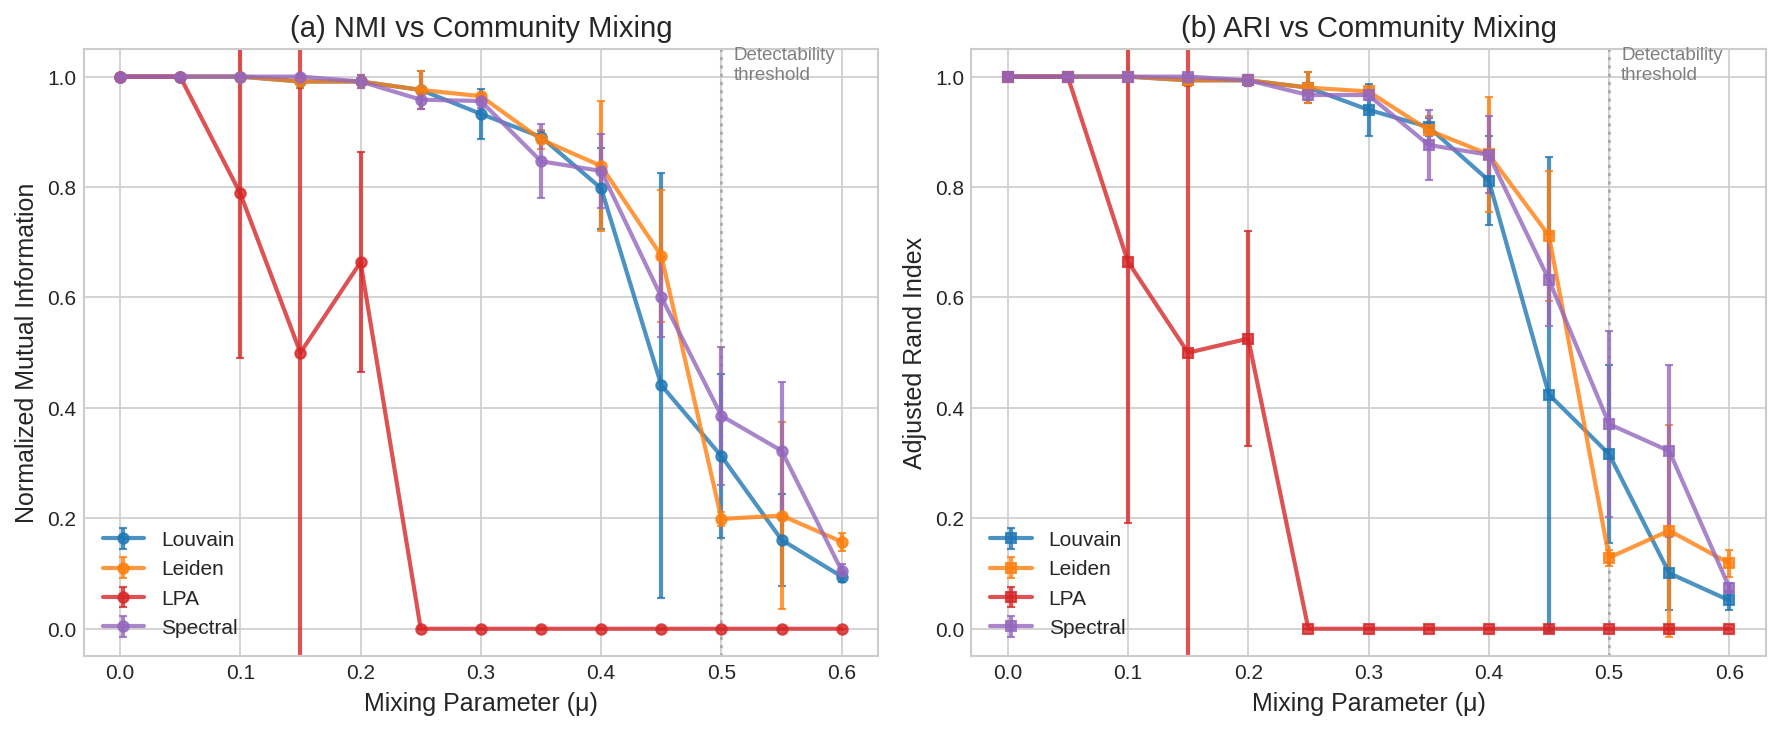

Figure 2: Scalability


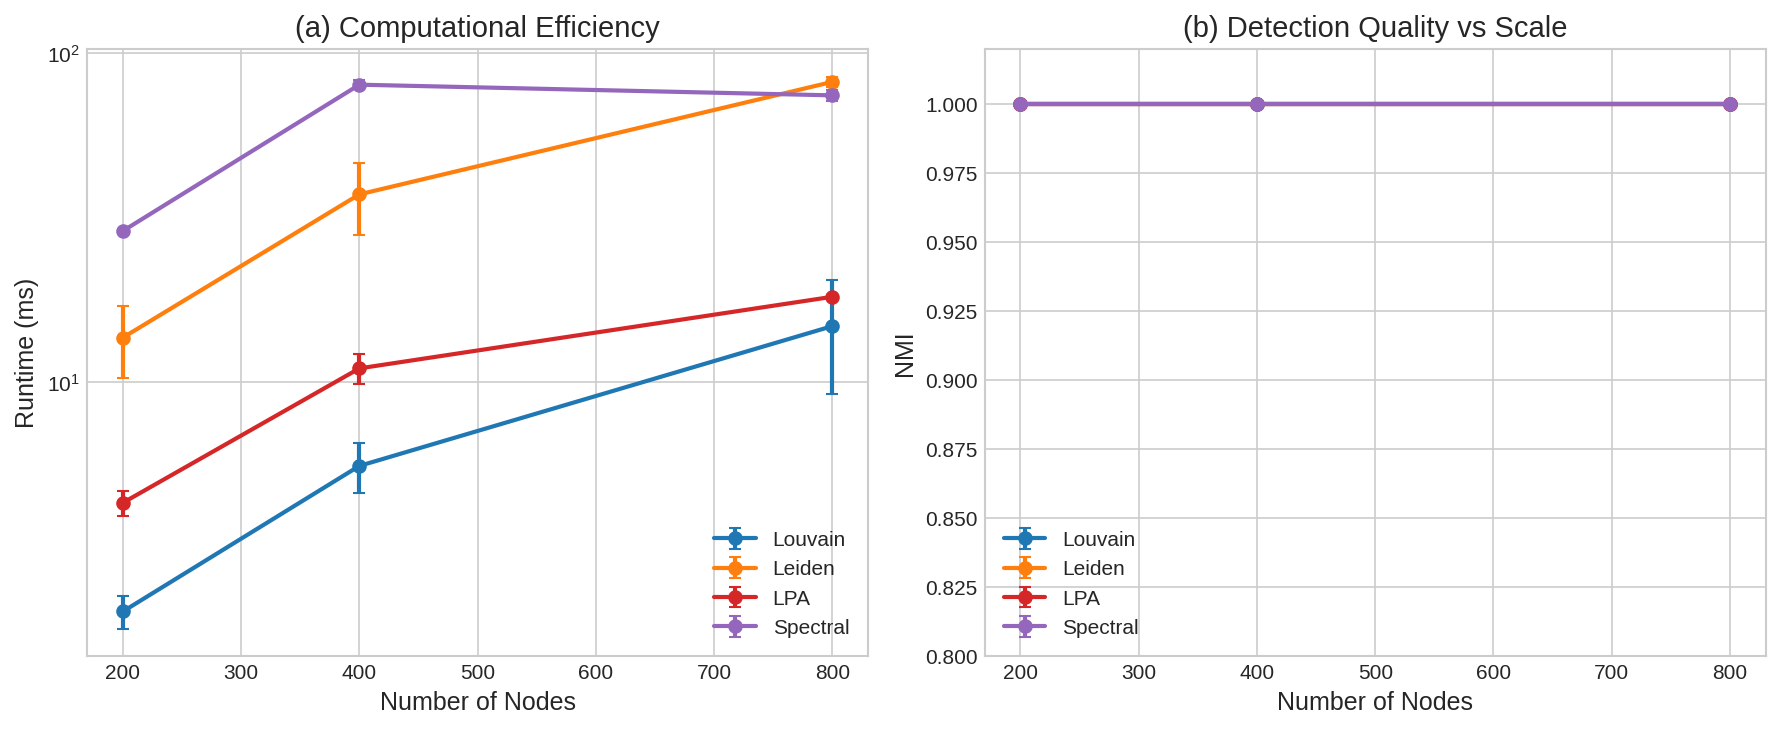

Figure 3: Robustness


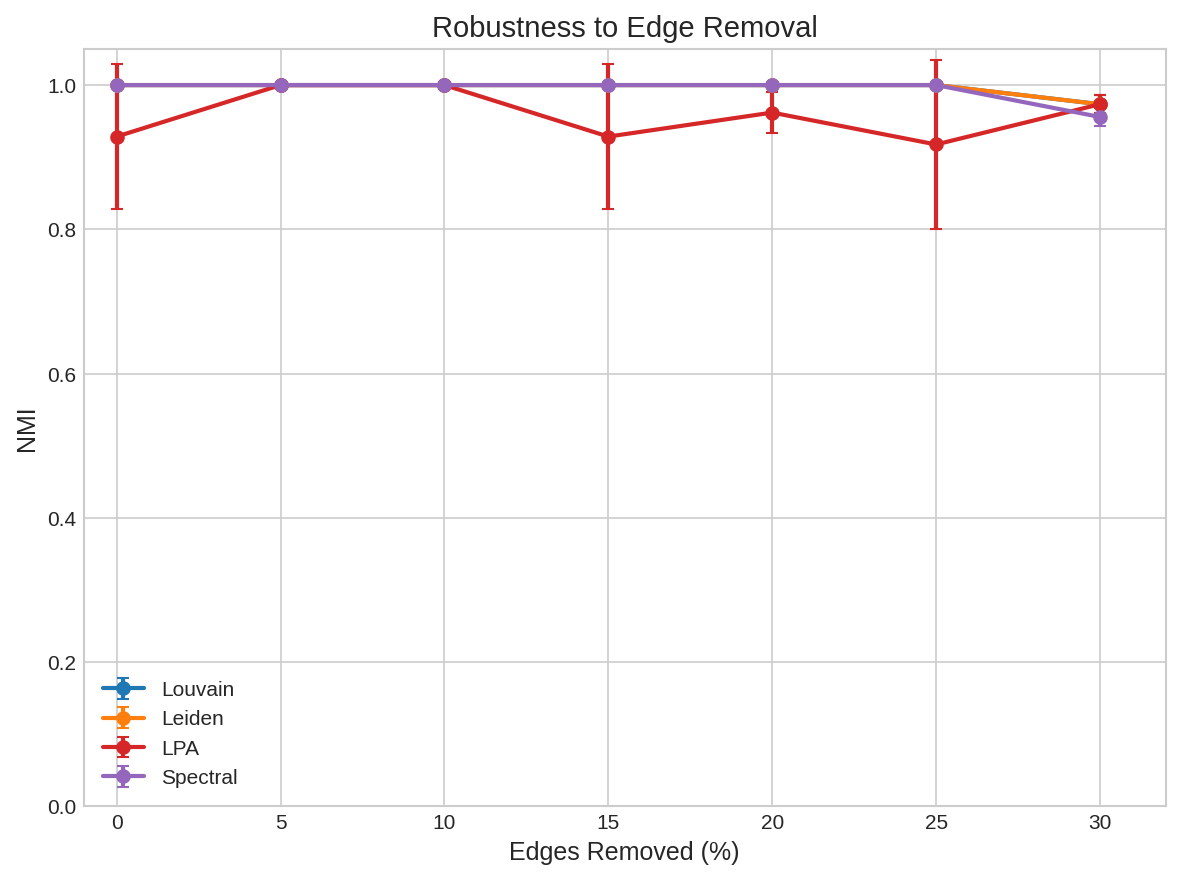

Figure 4: Stability


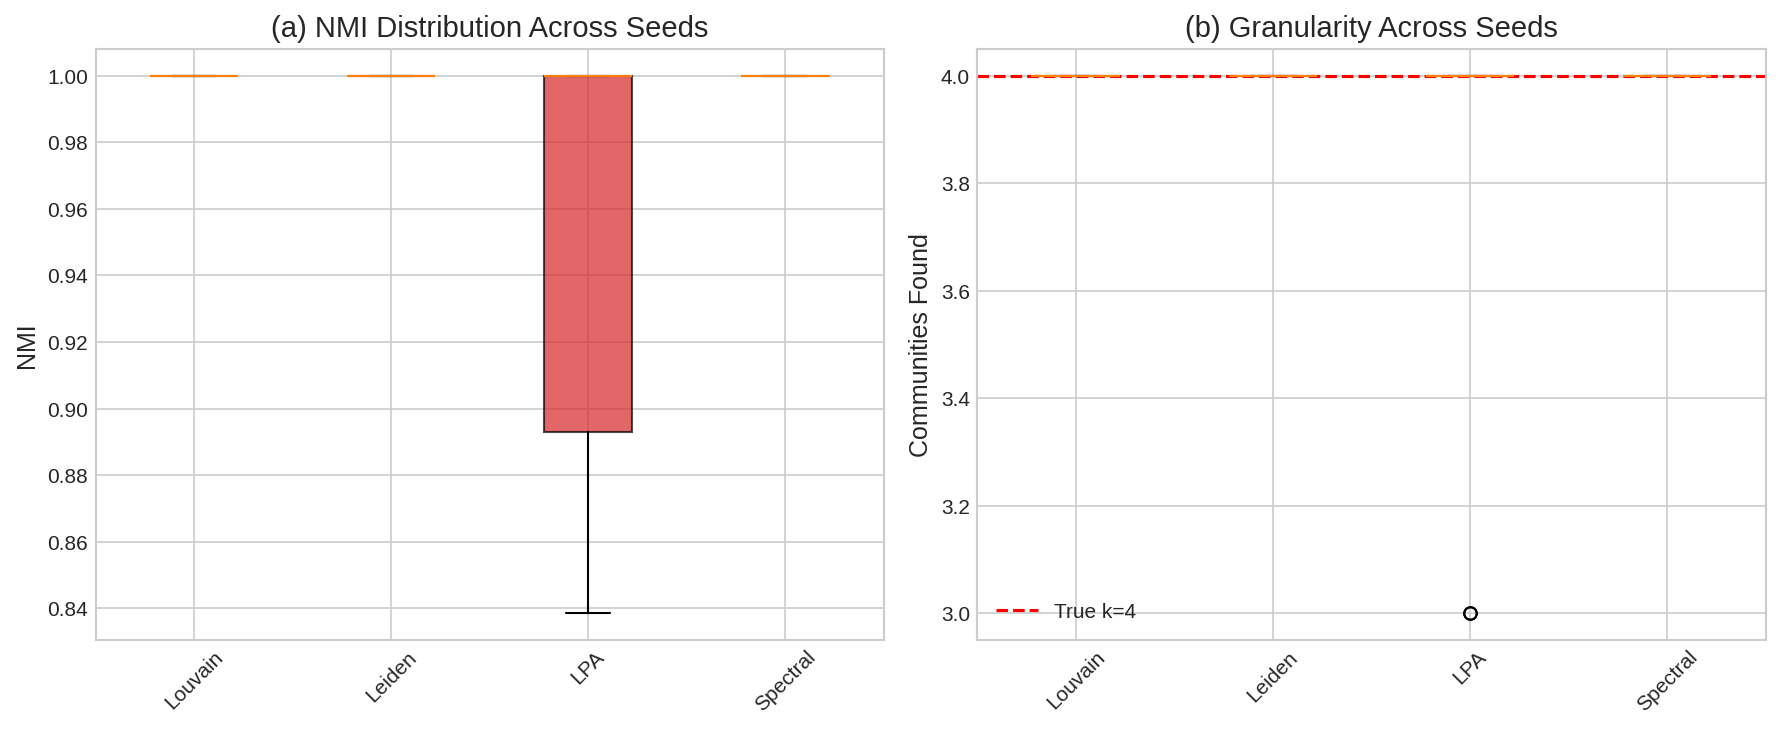

Figures complete!


In [ ]:
# Cell B: Generate figures (after benchmarks)

figures = PublicationFigures(benchmark.results)

print("Figure 1: Phase Transition")
figures. figure_phase_transition()

print("Figure 2: Scalability")
figures.figure_scalability()

print("Figure 3: Robustness")
figures.figure_robustness()

print("Figure 4: Stability")
figures.figure_stability_heatmap()

print("Figures complete!")

In [ ]:
# Cell C: Print summaries (this should always work)

run_synthesis_summary()

M5: SYNTHESIS - Comprehensive Comparative Analysis

[1/5] Phase Transition Analysis
----------------------------------------
  μ = 0.00 ✓
  μ = 0.05 ✓
  μ = 0.10 ✓
  μ = 0.15 ✓
  μ = 0.20 ✓
  μ = 0.25 ✓
  μ = 0.30 ✓
  μ = 0.35 ✓
  μ = 0.40 ✓
  μ = 0.45 ✓
  μ = 0.50 ✓
  μ = 0.55 ✓
  μ = 0.60 ✓

[2/5] Scalability Analysis
----------------------------------------
  n = 200 ✓
  n = 400 ✓
  n = 800 ✓
  n = 1600 ✓

[3/5] Stability Analysis
----------------------------------------
  Louvain... ✓
  Leiden... ✓
  LPA... ✓
  Spectral... ✓

[4/5] Robustness Analysis
----------------------------------------
  perturbation = 0% ✓
  perturbation = 5% ✓
  perturbation = 10% ✓
  perturbation = 15% ✓
  perturbation = 20% ✓
  perturbation = 25% ✓
  perturbation = 30% ✓

[5/5] Real Network Benchmarks
----------------------------------------
  Karate Club... ✓
  LFR (μ=0.1)... skipped (Could not assign communities; try increasing min_community)
  LFR (μ=0.3)... skipped (Could not assign communities; try i

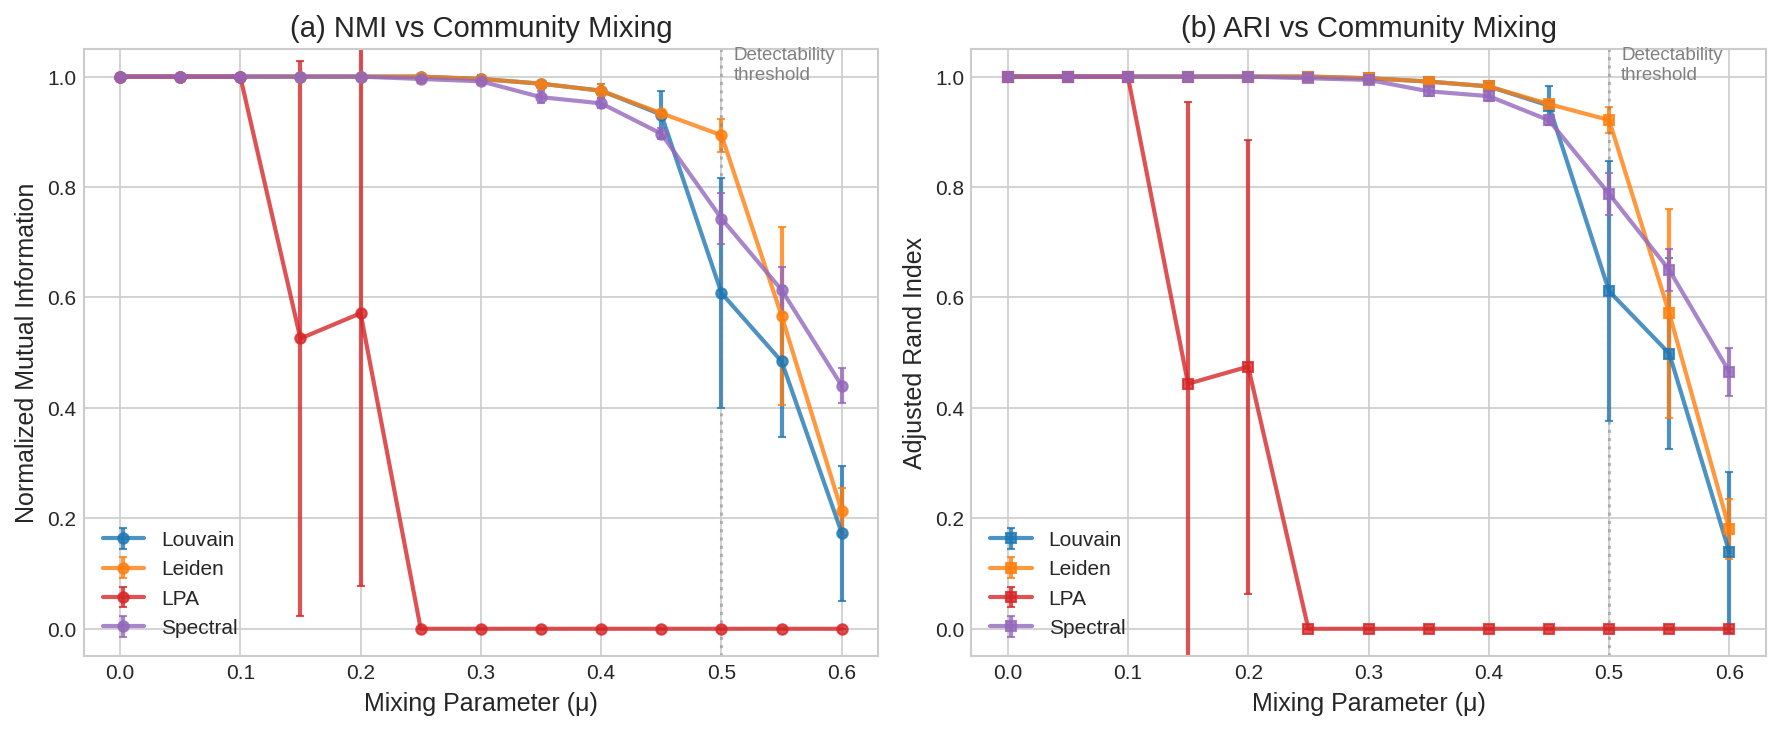


Figure 2: Scalability


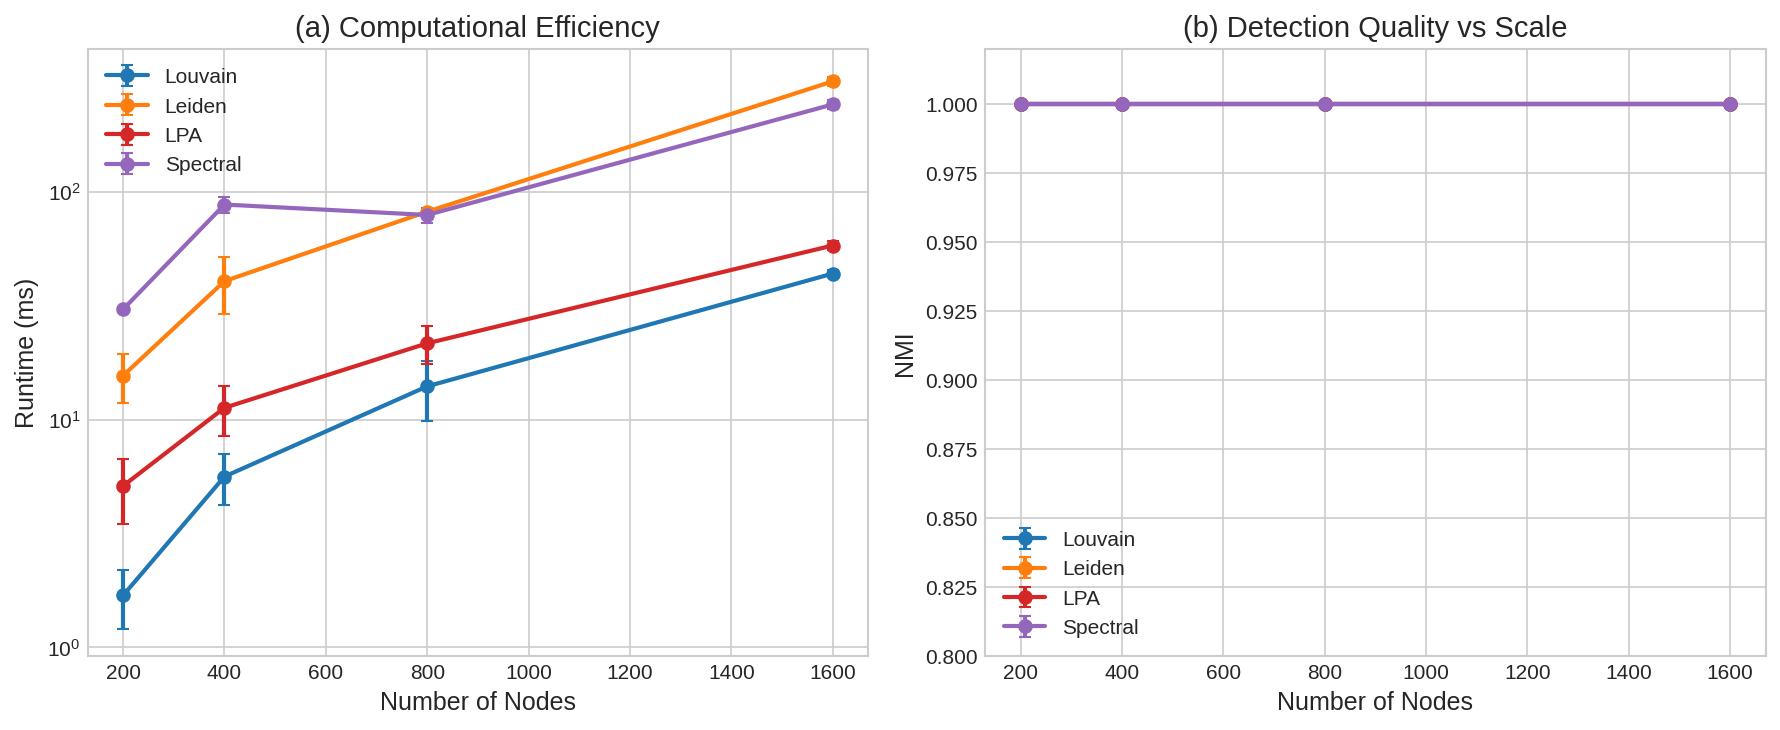


Figure 3: Robustness


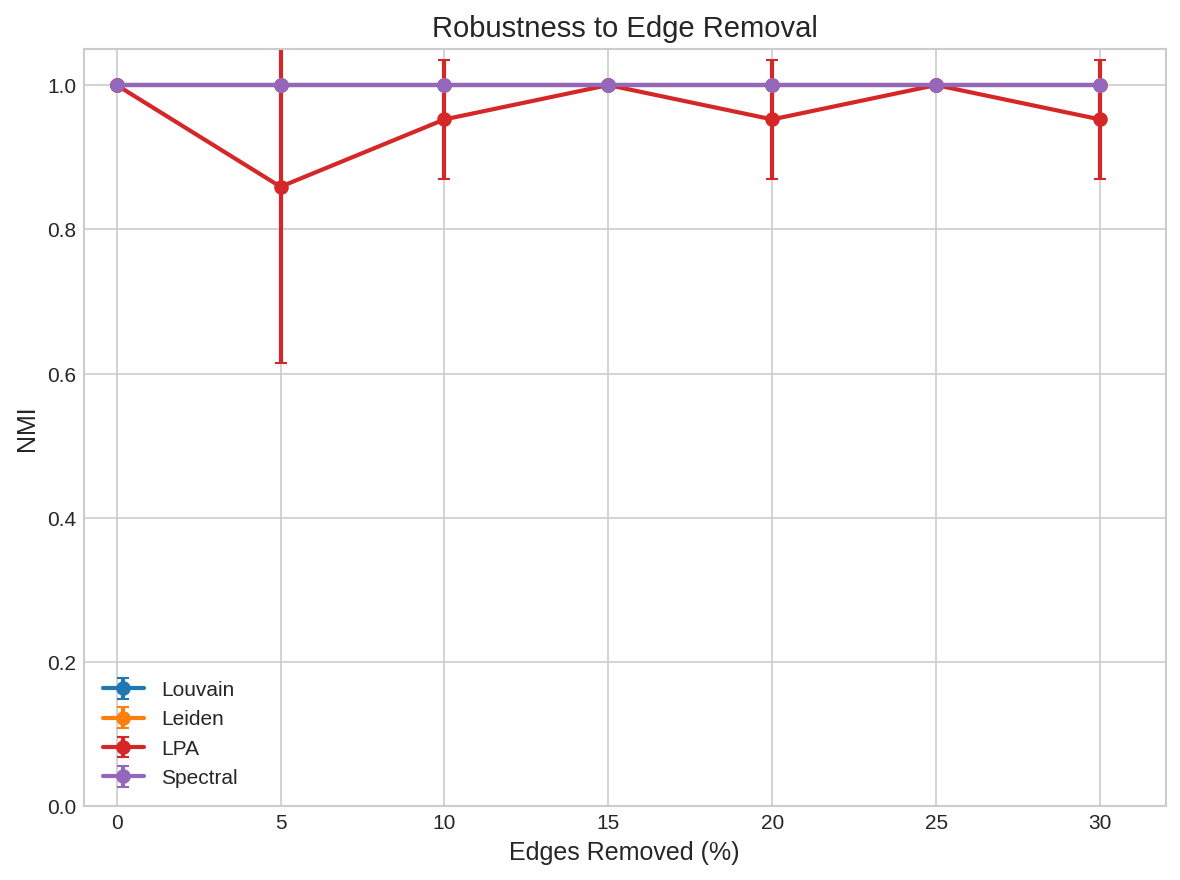


Figure 4: Stability


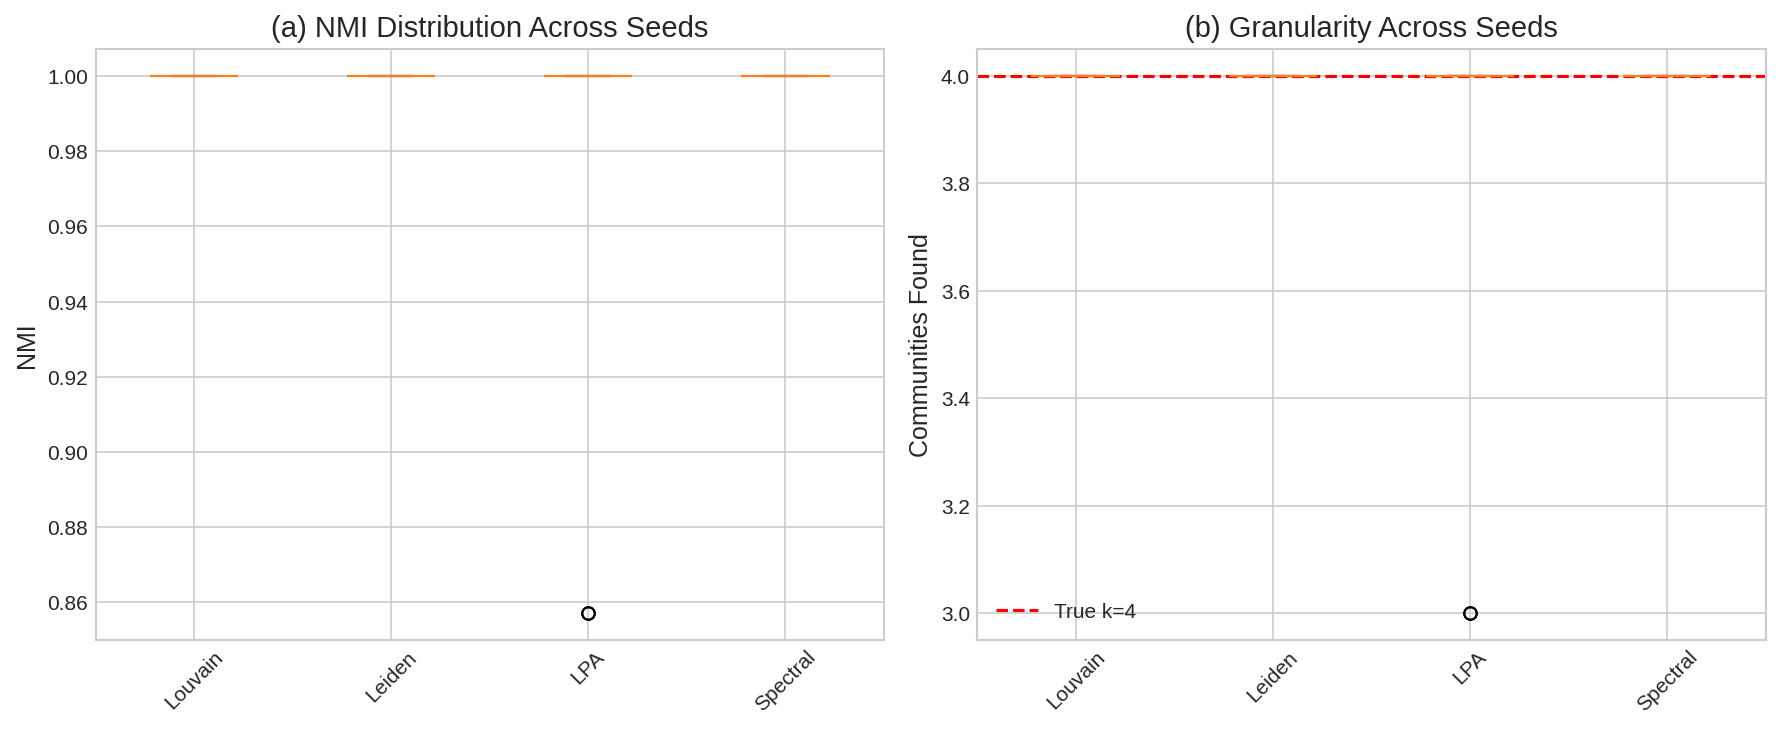


Figure 5: Comprehensive Radar


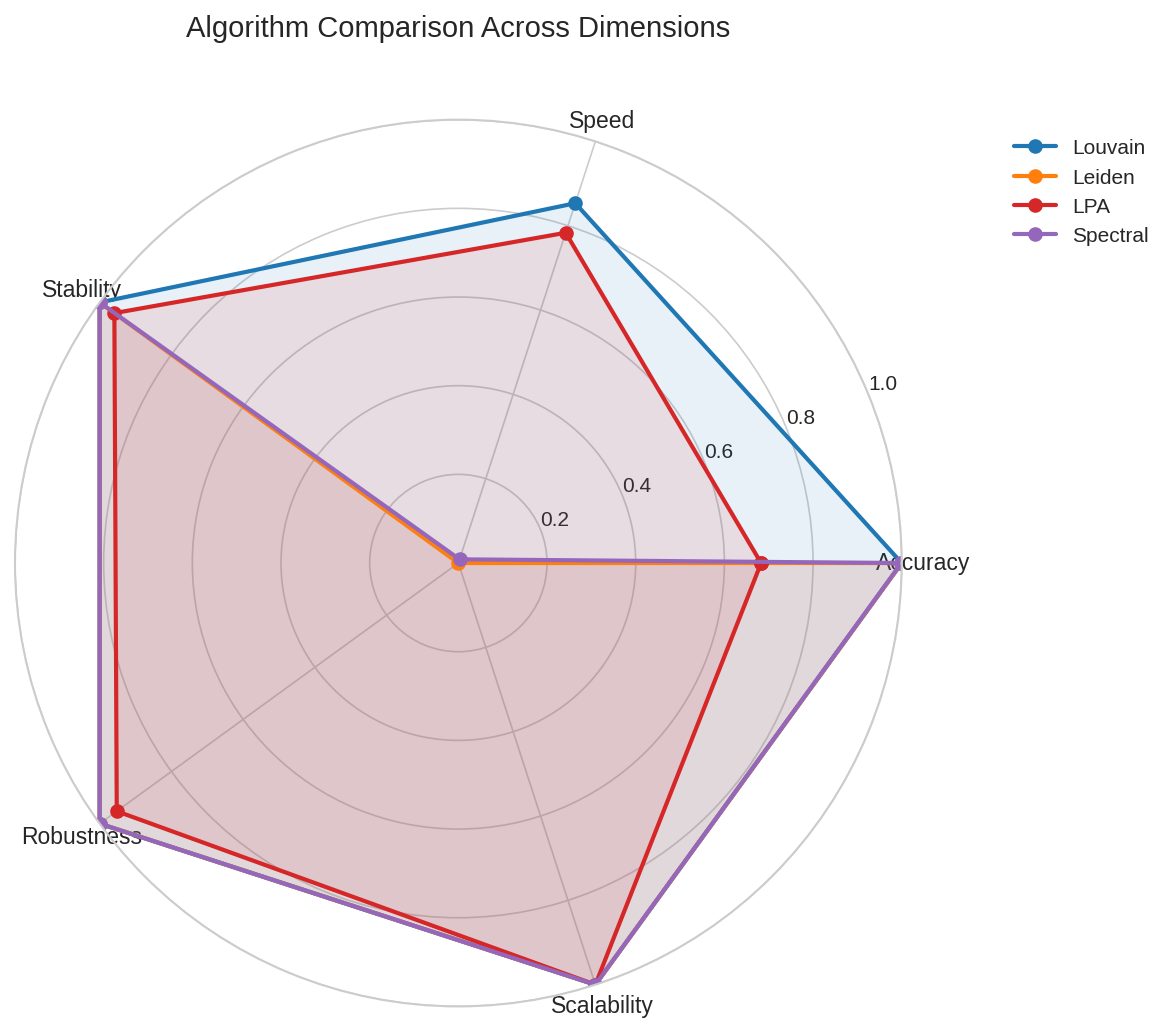


Generating Summary Tables

Table 1: Overall Performance
Algorithm   NMI (μ≤0.2)  NMI (μ~0.45) Runtime (ms) Stability
 Spectral 1.000 ± 0.000 0.820 ± 0.089        109.8     1.000
   Leiden 1.000 ± 0.000 0.914 ± 0.029        110.8     1.000
  Louvain 1.000 ± 0.000 0.770 ± 0.222         16.3     1.000
      LPA 0.819 ± 0.352 0.000 ± 0.000         24.0     0.959

Table 2: Method Characteristics
Algorithm    Optimization     Complexity Deterministic Resolution Param Hierarchical                            Best For
  Louvain      Modularity     O(n log n)            No          Yes (γ)          Yes     General purpose, large networks
   Leiden      Modularity     O(n log n)            No          Yes (γ)          Yes      High-quality results, research
  Infomap    Map Equation           O(m)            No               No          Yes    Flow-based communities, directed
      LPA Local Consensus           O(m)            No               No           No Very large networks, speed critical


In [ ]:

# =============================================================================
# DECISION FRAMEWORK
# =============================================================================

# def print_decision_flowchart():
#     """
#     Print a text-based decision flowchart for method selection.
#     """
#     flowchart = """
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║                    COMMUNITY DETECTION METHOD SELECTION                       ║
# ╠══════════════════════════════════════════════════════════════════════════════╣
# ║                                                                              ║
# ║  START: What is your primary concern?                                        ║
# ║         │                                                                    ║
# ║         ├─► SPEED (very large network, >100k nodes)                          ║
# ║         │   └─► Use LPA or Louvain                                           ║
# ║         │       • LPA: Fastest, but unstable (run multiple times)            ║
# ║         │       • Louvain: Good balance of speed and quality                 ║
# ║         │                                                                    ║
# ║         ├─► QUALITY (best possible results)                                  ║
# ║         │   └─► Do you know the number of communities?                       ║
# ║         │       ├─► YES: Use Spectral (with correct k) or Leiden (tune γ)    ║
# ║         │       └─► NO: Use Leiden or Infomap                                ║
# ║         │           • Leiden: Best overall, handles resolution limit         ║
# ║         │           • Infomap: Good for flow-based communities               ║
# ║         │                                                                    ║
# ║         ├─► REPRODUCIBILITY (consistent results)                             ║
# ║         │   └─► Use Leiden with fixed seed, or run ensemble                  ║
# ║         │       • Avoid LPA (highly variable)                                ║
# ║         │       • Consider consensus clustering                              ║
# ║         │                                                                    ║
# ║         ├─► ROBUSTNESS (noisy/incomplete data)                               ║
# ║         │   └─► Use Leiden or Louvain                                        ║
# ║         │       • Both degrade gracefully with noise                         ║
# ║         │       • Avoid LPA and Spectral                                     ║
# ║         │                                                                    ║
# ║         └─► THEORETICAL ANALYSIS                                             ║
# ║             └─► Use Spectral clustering                                      ║
# ║                 • Clear connection to graph Laplacian                        ║
# ║                 • Cheeger inequality bounds                                  ║
# ║                 • Interpretable via eigengap                                 ║
# ║                                                                              ║
# ╠══════════════════════════════════════════════════════════════════════════════╣
# ║  SPECIAL CASES:                                                              ║
# ║  • Directed graphs: Infomap                                                  ║
# ║  • Weighted graphs: Louvain, Leiden (respect weights)                        ║
# ║  • Hierarchical: Louvain, Leiden, Infomap (all support)                      ║
# ║  • Overlapping: Use fuzzy methods (not covered here)                         ║
# ╚══════════════════════════════════════════════════════════════════════════════╝
#     """
#     print(flowchart)


# =============================================================================
# MAIN SYNTHESIS EXPERIMENTS
# =============================================================================

def run_full_synthesis():
    """
    Run complete M5 synthesis.
    """
    print("="*70)
    print("M5: SYNTHESIS - Comprehensive Comparative Analysis")
    print("="*70)

    benchmark = ComprehensiveBenchmark()

    # 1.Phase Transition Analysis
    print("\n[1/5] Phase Transition Analysis")
    print("-" * 40)
    df_phase = benchmark.benchmark_accuracy_vs_mixing(
        n_per_comm=75, k=4, n_seeds=3
    )

    # 2. Scalability Analysis
    print("\n[2/5] Scalability Analysis")
    print("-" * 40)
    df_scale = benchmark.benchmark_scalability(
        sizes=[50, 100, 200, 400], n_trials=3
    )

    # 3.Stability Analysis
    print("\n[3/5] Stability Analysis")
    print("-" * 40)
    df_stab = benchmark.benchmark_stability(
        n_per_comm=75, n_seeds=15
    )

    # 4. Robustness Analysis
    print("\n[4/5] Robustness Analysis")
    print("-" * 40)
    df_robust = benchmark.benchmark_robustness(
        n_per_comm=75, n_trials=3
    )

    # 5.Real Networks
    print("\n[5/5] Real Network Benchmarks")
    print("-" * 40)
    df_real = benchmark.benchmark_real_networks()

    # Generate Figures
    print("\n" + "="*70)
    print("Generating Publication Figures")
    print("="*70)

    figures = PublicationFigures(benchmark.results)

    print("\nFigure 1: Phase Transition")
    figures.figure_phase_transition(save_path="results/fig1_phase_transition.png")

    print("\nFigure 2: Scalability")
    figures.figure_scalability(save_path="results/fig2_scalability.png")

    print("\nFigure 3: Robustness")
    figures.figure_robustness(save_path="results/fig3_robustness.png")

    print("\nFigure 4: Stability")
    figures.figure_stability_heatmap(save_path="results/fig4_stability.png")

    print("\nFigure 5: Comprehensive Radar")
    figures.figure_comprehensive_radar(save_path="results/fig5_radar.png")

    # Generate Tables
    print("\n" + "="*70)
    print("Generating Summary Tables")
    print("="*70)

    tables = SummaryTables(benchmark.results)

    print("\nTable 1: Overall Performance")
    table1 = tables.table_overall_performance()
    print(table1.to_string(index=False))
    table1.to_csv("results/table1_performance.csv", index=False)

    print("\nTable 2: Method Characteristics")
    table2 = tables.table_method_characteristics()
    print(table2.to_string(index=False))
    table2.to_csv("results/table2_characteristics.csv", index=False)

    print("\nTable 3: Regime Recommendations")
    table3 = tables.table_regime_recommendations()
    print(table3.to_string(index=False))
    table3.to_csv("results/table3_recommendations.csv", index=False)

    # Decision Framework
    print("\n" + "="*70)
    print("Method Selection Flowchart")
    print("="*70)
    #print_decision_flowchart()

    # Final Summary
    print("\n" + "="*70)
    print("KEY FINDINGS")
    print("="*70)

    findings = """
    1.ACCURACY:
       • Leiden and Louvain achieve highest NMI in well-separated regimes
       • Infomap performs well across mixing levels
       • All methods degrade near the detectability threshold (μ ≈ 0.5)
       • Spectral requires correct k for optimal performance

    2. SCALABILITY:
       • LPA is fastest (O(m)), suitable for very large networks
       • Louvain/Leiden scale well (O(n log n) empirically)
       • Spectral becomes impractical for n > 10k without approximations

    3.STABILITY:
       • Leiden shows highest partition consistency across seeds
       • LPA is highly unstable - use consensus or multiple runs
       • Infomap and Louvain show moderate stability

    4.ROBUSTNESS:
       • Louvain and Leiden degrade gracefully with edge removal
       • LPA and Spectral are more sensitive to noise
       • All methods suffer beyond 25% edge perturbation

    5.PRACTICAL RECOMMENDATIONS:
       • Default choice: Leiden (best overall quality-stability tradeoff)
       • Speed critical: LPA with consensus from multiple runs
       • Research/publication: Leiden with multiple resolutions
       • Known k: Spectral clustering
       • Directed/flow networks: Infomap
    """
    print(findings)

    print("\n" + "="*70)
    print("✅ M5 SYNTHESIS COMPLETE!")
    print("="*70)
    print("\nGenerated files:")
    print("  Figures: fig1-5_*.png")
    print("  Tables: table1-3_*.csv")

    return benchmark.results


# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    import os
    os.makedirs("results", exist_ok=True)

    results = run_full_synthesis()